In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import matplotlib as mpl
from pathlib import Path
import time
from copy import deepcopy
from scipy import ndimage
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
import itertools
import pickle
import seaborn as sn
import pandas as pd

from skimage import filters

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.pipeline import Pipeline
from sklearn.inspection import partial_dependence
from sklearn.inspection._partial_dependence import _partial_dependence_brute, _grid_from_X
from sklearn.utils.extmath import cartesian
from sklearn.metrics import r2_score

# from cmdstanpy import CmdStanModel


from skimage import filters, restoration

import pccmap
import pccmap.dataload as dl
from pccmap import clean
from pccmap import fit as pmfit
import pccmap.plot as pcp
from pccmap import stan_utils
    
import hybdrt
import hybdrt.fileload as fl
from hybdrt.models import DRT
from hybdrt.mapping import DRTMD
import hybdrt.plotting as hplt
from hybdrt.utils import stats
from hybdrt import mapping
from hybdrt import filters as hf
from hybdrt.utils.array import nearest_index
from hybdrt.mapping.stan_utils import load_model

import fig_funcs as ff
    
%load_ext autoreload
%autoreload 2

In [3]:
# Plot formatting
full_width, half_width, light_colors, base_colors, dark_colors = ff.set_plot_formatting()

# kwargs for data scatter plots
data_kw = dict(facecolors='none', edgecolors=[0.1] * 3)

# Matplotlib default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Directory in which to find pickled DRT fits generated by gen_pcec_fits.py
fit_path = Path('./fits/PCEC')

In [4]:
# Cell area
d_cell = 0.25
a_cell = np.pi * (d_cell * 2.54/ 2) ** 2

In [5]:
# Load DRT fits generated by gen_pcec_fits.py
mrt = None
suffix = '_doplambda=50_NormBySupergrid'
for step in range(23, 33):
    if mrt is None:
        mrt = DRTMD.from_source(fit_path.joinpath(f'FF3_wet_Step{step}d{suffix}.pkl'))
    else:
        mrt.load_observations(fit_path.joinpath(f'FF3_wet_Step{step}d{suffix}.pkl'))
        

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


In [39]:
mrt.obs_psi_df

T  ph2   po2   ph2o         j         V       eta         time
0    450.0  1.0  0.21  0.100 -0.004754  1.088135 -0.006747  8076.459043
1    450.0  1.0  0.21  0.100 -0.014069  1.060352 -0.034530  8076.459043
2    450.0  1.0  0.21  0.100 -0.023072  1.030744 -0.064137  8076.459043
3    450.0  1.0  0.21  0.100 -0.031861  1.002337 -0.092545  8076.459043
4    450.0  1.0  0.21  0.100 -0.040698  0.973002 -0.121880  8076.459043
..     ...  ...   ...    ...       ...       ...       ...          ...
378  450.0  0.5  0.21  0.035  0.210816  1.486462  0.383981  8828.513454
379  450.0  0.5  0.21  0.035  0.234859  1.515453  0.412972  8828.513454
380  450.0  0.5  0.21  0.035  0.259601  1.543028  0.440548  8828.513454
381  450.0  0.5  0.21  0.035 -0.173944  0.528524 -0.573956  8828.513454
382  450.0  0.5  0.21  0.035  0.272084  1.556159  0.453679  8828.513454

[383 rows x 8 columns]

array([<AxesSubplot:xlabel='$Z^\\prime$ (m$\\Omega\\cdot \\mathrm{cm}^2$)', ylabel='$-Z^{\\prime\\prime}$ (m$\\Omega\\cdot \\mathrm{cm}^2$)'>,
       <AxesSubplot:xlabel='$f$ (Hz)', ylabel='$|Z|$ (m$\\Omega$$\\cdot\\mathrm{cm}^2)$'>,
       <AxesSubplot:xlabel='$f$ (Hz)', ylabel='$-$$\\theta$ ($^\\circ$)'>],
      dtype=object)

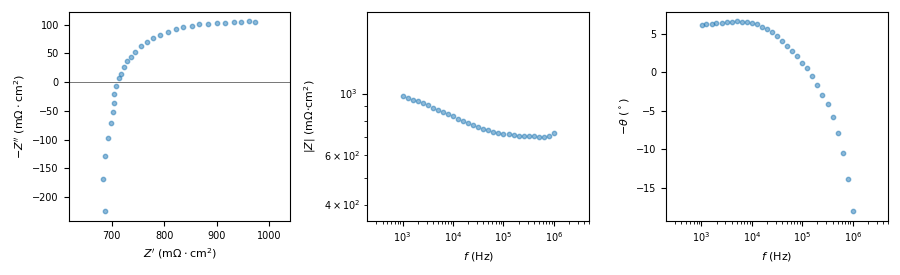

In [44]:
df = fl.read_eis(mrt.obs_data[0][1])
hplt.plot_eis(df, area=a_cell)

In [38]:
t = mrt.get_fit(0)
t.fit_parameters

{'x': array([5.89912338e-03, 1.27920206e-02, 2.20824488e-02, 3.26021332e-02,
        4.46157309e-02, 5.78327703e-02, 7.20897863e-02, 8.65785042e-02,
        9.95560955e-02, 1.07919836e-01, 1.08213543e-01, 9.92710861e-02,
        8.37731892e-02, 6.60375226e-02, 4.92596339e-02, 3.50930878e-02,
        2.44081210e-02, 1.78192645e-02, 1.57223508e-02, 1.81129117e-02,
        2.45476483e-02, 3.43462710e-02, 4.68152176e-02, 6.12730204e-02,
        7.68520100e-02, 9.22421680e-02, 1.05735723e-01, 1.15869603e-01,
        1.22255534e-01, 1.25694488e-01, 1.27497597e-01, 1.28754162e-01,
        1.29975610e-01, 1.31054643e-01, 1.31429739e-01, 1.30429312e-01,
        1.27694699e-01, 1.23424974e-01, 1.18266894e-01, 1.12980299e-01,
        1.08163554e-01, 1.04173071e-01, 1.01193948e-01, 9.93580735e-02,
        9.88323792e-02, 9.98452077e-02, 1.02651620e-01, 1.07455805e-01,
        1.14306147e-01, 1.22978922e-01, 1.32890356e-01, 1.43141009e-01,
        1.52820935e-01, 1.61538212e-01, 1.69828698e-01, 1.7

In [6]:
# Make overpotential grid
v_step = np.sqrt(2) * 0.02
v_base = np.arange(-20.5 * v_step, 17.5 * v_step, v_step)
v_base = np.insert(v_base, 0, 0)
v_base.sort()
v_base.shape

(39,)

In [7]:
# Get structure at 450 C from DRT fits
struct_results = pccmap.structure.structure_from_drtmd(mrt, v_base, group_by=['po2', 'ph2', 'ph2o'],
                                                        flag_kw={'thresh': 2},
                                                       remove_bad=True, resolve=True, impute=True)
struct_450 = struct_results[450]

23d num bad: 0
24d num bad: 1
25d num bad: 0
26d num bad: 1
27d num bad: 1
28d num bad: 0
29d num bad: 1
30d num bad: 2
31d num bad: 0
32d num bad: 1


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\filters\_filters.py:175: RuntimeWarning: invalid value encountered in true_divide
  return x_filt / mask_filt


## 3d path (sheet) finding
Use sheet-tracing to find sheets in the DRT surface.

In [8]:
def get_paths_3d(x, rp, tp, tau, ignore_paths=None, start_row=0, end_row=39, 
                 reverse=True, rss_thresh=1,
                 smooth_sigma=None,
                 reverse_kw=None, **kw):
    
    # Find paths
    print('Forward paths')
    paths, costs = mapping.path.find_paths_3d(rp, start_row, end_row, **kw)
    
    if reverse:
        print('Reverse paths')
        if reverse_kw is None:
            reverse_kw = kw
        rev_paths, _ = mapping.path.find_paths_3d(rp, end_row, start_row, **reverse_kw)
        paths, _ = mapping.path.merge_paths(paths, rev_paths, rss_thresh=rss_thresh)
    
    if ignore_paths is not None:
        paths = [p for i, p in enumerate(paths) if i not in ignore_paths]
        
    if smooth_sigma is not None:
        paths = mapping.path.smooth_paths(paths, smooth_sigma)

    path_mask = mapping.path.paths_to_mask_3d(rp.shape, paths, True, fill_nan=True)
    
    return {'paths': paths, 'path_mask': path_mask}
    

In [9]:
# Define path bounds
p2_bounds = (20, 26)  # 1e-6, 1e-5
p4_bounds = (38, 101)
p5_bounds = (0, 55)
p6_bounds = (0, 66)
p7_bounds = (66, 101)

In [10]:
# Paths through o2 slices
x = struct_450['x_filt'][:, 2, 0]
rp = struct_450['rp_mix'][:, 2, 0]
tp = struct_450['tp_filt'][:, 2, 0]
dim_grids = struct_450['dim_grids']
o2_vals = [dim_grids[0], dim_grids[1][2], dim_grids[2][0]]

rp = mapping.ndx.filter_ndx(rp, num_group_dims=1,
                            iterative=True, iter=3, nstd=5, dev_rms_size=5,
                            adaptive=True, impute=True, impute_groups=False,
                            max_sigma=(0, 2, 1), k_factor=(2, 2, 2),
                            presmooth_sigma=None,  # (1, 1, 1, 2, 1),
                            mode='nearest'
                           )

path_kw = dict(
    height=0.1, prominence=0.05, max_slope=3, 
    grad_sigma=2, grad_strength=5,
    min_prob=0.1, offset=2, offset_cost=0.1, momentum=0.5,
#     smooth_sigma=(1, 3)
)
o2_paths = get_paths_3d(x, rp + 0.01, tp, mrt.tau_supergrid, ignore_paths=None, start_row=0, end_row=len(v_base) - 1, 
                        reverse=True, rss_thresh=5,                        
                        bounds=[None, None, p4_bounds, p6_bounds, p7_bounds],
                         **path_kw, reverse_kw=path_kw | {'bounds': [None, None, p5_bounds, p6_bounds] }
                       )



Forward paths
best_slope: -0.25
best_slope: 0.0
best_slope: 0.0
best_slope: -1.25
best_slope: -2.5


Reverse paths
best_slope: 0.75
best_slope: -1.0
best_slope: 0.25
best_slope: 0.0


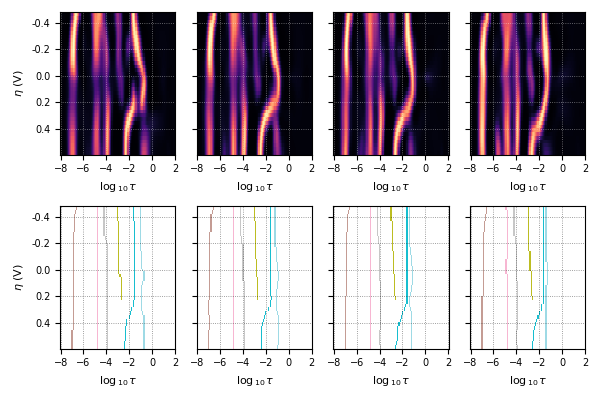

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(6, 4), sharey=True)

pm = o2_paths['path_mask']
for i in range(axes.shape[1]):
    pcp.plot_x_2d(v_base, rp[i], mrt, ax=axes[0, i], vmin=0, cmap='magma')
    pcp.plot_x_2d(v_base, pm[i], mrt, ax=axes[1, i], cmap='tab20', grid_kw={'c': 'k'})
    if i > 0:
        for ax in axes[:, i]:
            ax.set_ylabel('')
fig.tight_layout()

Forward paths
best_slope: -0.666666666666667
best_slope: 1.9999999999999991
best_slope: -0.666666666666667
best_slope: 0.6666666666666661
best_slope: -0.3333333333333337
best_slope: 1.666666666666666
Reverse paths
best_slope: -4.440892098500626e-16
best_slope: -1.0000000000000002
best_slope: -0.3333333333333337
best_slope: -4.440892098500626e-16
best_slope: -4.440892098500626e-16


c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\numpy\lib\function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\mapping\path.py:489: RuntimeWarning: invalid value encountered in double_scalars


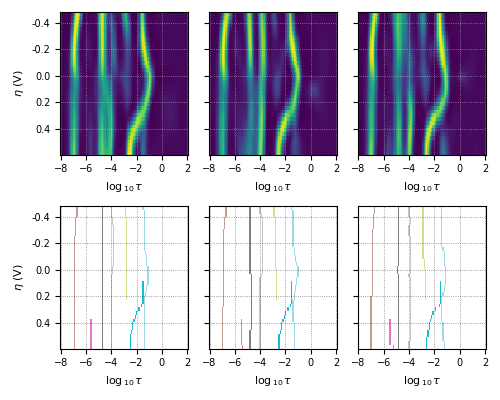

In [12]:
# Paths through H2 slices
x = struct_450['x_filt'][2, :, 0]
rp = struct_450['rp_mix'][2, :, 0]
tp = struct_450['tp_filt'][2, :, 0]

rp = mapping.ndx.filter_ndx(rp, num_group_dims=1,
                            iterative=True, iter=3, nstd=5, dev_rms_size=5,
                            adaptive=True, impute=True, impute_groups=False,
                            max_sigma=(0, 2, 1), k_factor=(2, 2, 2),
                            presmooth_sigma=None,  # (1, 1, 1, 2, 1),
                            mode='nearest'
                           )

# path_kw = dict(
#     height=0.1, prominence=0.05, max_slope=2, 
#     grad_sigma=1, grad_strength=5,
#     min_prob=0.1, offset=2, offset_cost=0.5, momentum=0.5
# )

path_kw = dict(
    height=0.1, prominence=0.01, max_slope=2, 
    grad_sigma=1, grad_strength=10,
    min_prob=0.1, offset=2, offset_cost=0.5, momentum=0.2,
#     smooth_sigma=None#(1, 3)
)

h2_paths = get_paths_3d(x, rp, tp, mrt.tau_supergrid, 
                        ignore_paths=None, start_row=0, end_row=len(v_base) - 1, 
                        reverse=True, rss_thresh=5,
                        **path_kw, bounds=[None, p2_bounds] + [None] * 2 + [p6_bounds, p7_bounds],
                        reverse_kw=path_kw | {'bounds': [None]  * 3 + [p5_bounds, p7_bounds]}
                       )
fig, axes = plt.subplots(2, 3, figsize=(5, 4), sharey=True)

pm = h2_paths['path_mask']
for i in range(axes.shape[1]):
    pcp.plot_x_2d(v_base, rp[i], mrt, ax=axes[0, i], vmin=0, cmap='viridis')
    pcp.plot_x_2d(v_base, pm[i], mrt, ax=axes[1, i], cmap='tab20', grid_kw={'c': 'k'})
    if i > 0:
        for ax in axes[:, i]:
            ax.set_ylabel('')
    
fig.tight_layout()


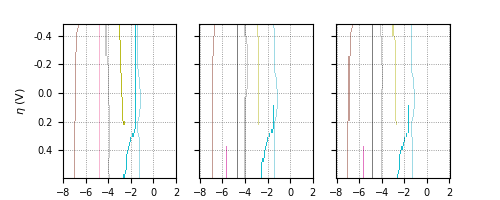

In [13]:
# Match paths in intersection slice
path_o2 = o2_paths['paths']
path_h2 = h2_paths['paths']
# Get matchiing slices
path_o2 = [(p[0], p[1][2]) for p in path_o2]
path_h2 = [(p[0], p[1][0]) for p in path_h2]

# mapping.path.match_paths(path_o2, path_h2, rss_thresh=7)
merged_paths, labels = mapping.path.merge_paths(path_o2, path_h2, rss_thresh=20)
o2_labels, h2_labels = labels

# Check merging
pm = mapping.path.paths_to_mask(o2_paths['path_mask'][0].shape, merged_paths, True, fill_nan=True)

fig, axes = plt.subplots(1, 3, figsize=(5, 2), sharey=True)
pcp.plot_x_2d(v_base, o2_paths['path_mask'][2], mrt, ax=axes[0], cmap='tab20', grid_kw={'c': 'k'})
pcp.plot_x_2d(v_base, h2_paths['path_mask'][0], mrt, ax=axes[1], cmap='tab20', grid_kw={'c': 'k'})
pcp.plot_x_2d(v_base, pm, mrt, ax=axes[2], cmap='tab20', grid_kw={'c': 'k'})
    
for ax in axes[1:]:
    ax.set_ylabel('')

## Path fitting and prediction via GP
We have an initial guess of sheet locations from the sheet-tracing algorithm shown above. However, since the shee-tracing algorithm was applied to two 3D subspaces (tau-eta-pO2 and tau-eta-pH2), there are some 2D slices (tau-eta) at pO2-pH2-pH2O coordinates through which the sheet tracing algorithm did not pass. Here, we simply fill these in by training a GP model on the sheet-tracing results and then predicting sheet positions at all coordinates.

In [14]:
def fill_path_data(y, paths, labels):
    for label, path in zip(labels, paths):
        y[label][:, path[0]] = path[1]
    return y


slice_data = {}
dim_grids = struct_450['dim_grids']
num_sheets = len(merged_paths)

n_o2 = np.prod(o2_paths['path_mask'].shape[:-1])
# X: po2, ph2, eta
o2_x = np.empty((n_o2, 3))
vv, oo = np.meshgrid(v_base, dim_grids[0])
o2_x [:, 0] = oo.flatten()
o2_x[:, 1] = dim_grids[1][2] # fixed h2
o2_x[:, 2] = vv.flatten()

# y: tau index for each sheet
o2_y = np.empty((num_sheets, *o2_paths['path_mask'].shape[:-1]))
o2_y.fill(np.nan)
o2_y = fill_path_data(o2_y, o2_paths['paths'], o2_labels)
o2_y = np.array([y_vec.flatten() for y_vec in o2_y]).T

slice_data['o2'] = {
    'n': n_o2,
    'x': o2_x,
    'y': o2_y
}

# H2 slices
n_h2 = np.prod(h2_paths['path_mask'].shape[:-1])
# X: po2, ph2, eta
h2_x = np.empty((n_h2, 3))
vv, hh = np.meshgrid(v_base, dim_grids[1])
h2_x[:, 0] = dim_grids[0][2] # fixed po2
h2_x [:, 1] = hh.flatten()
h2_x[:, 2] = vv.flatten()

# y: tau index for each sheet
h2_y = np.empty((num_sheets, *h2_paths['path_mask'].shape[:-1]))
h2_y.fill(np.nan)
h2_y = fill_path_data(h2_y, h2_paths['paths'], h2_labels)
h2_y = np.array([y_vec.flatten() for y_vec in h2_y]).T

slice_data['h2'] = {
    'n': n_h2,
    'x': h2_x,
    'y': h2_y
}

X_path = np.concatenate([v['x'] for v in slice_data.values()])
y_path = np.concatenate([v['y'] for v in slice_data.values()])

    
# Check for nans
print('nan count:', np.sum(np.isnan(X_path)), np.sum(np.isnan(y_path)))

nan count: 0 403


In [15]:
def multi_train(X, y, gp):
    gps = []
    for k in range(y.shape[1]):
        train_index = ~np.isnan(y[:, k])
        gp.fit(X[train_index], y[train_index, k])
        gps.append(deepcopy(gp))
    return gps

def multi_predict(X, gps):
    y_pred = np.empty((len(X), len(gps)))
    for k, gp in enumerate(gps):
        y_pred[:, k] = gp.predict(X)
    return y_pred

In [16]:
scaler = StandardScaler()
kernel = 1.0 * kernels.RBF(length_scale=(1, 1, 1)) + kernels.WhiteKernel(noise_level=0.1, noise_level_bounds='fixed')
gp_ = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp = Pipeline([('scale', scaler), ('gp', gp_)])

path_gps = multi_train(X_path, y_path, gp)

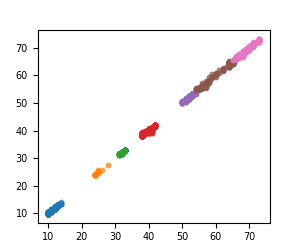

In [17]:
# Check fit closeness
y_pred = multi_predict(X_path, path_gps)

fig, ax = plt.subplots(figsize=(3, 2.5))
for k in range(num_sheets):
    ax.scatter(y_path[:, k], y_pred[:, k], s=10, alpha=0.7)

In [18]:
# Path prediction: 3-10% H2O
# Assume same path positions for 10% H2O as for 3.5% H2O
# Could repeat path-finding operation, but paths seem to be well-aligned
hh_pred, oo_pred, h2o_pred, vv_pred = np.meshgrid(dim_grids[1], dim_grids[0], dim_grids[2], v_base)
X_pred = np.stack([oo_pred.flatten(), hh_pred.flatten(), vv_pred.flatten()]).T
X_pred.shape

(936, 3)

In [19]:
# Use GPs to predict sheet positions for all coordinates
y_pred = multi_predict(X_pred, path_gps)
y_pred = np.round(y_pred, 0).astype(int)
pred_paths = [(np.arange(len(v_base)), y_k.reshape(oo_pred.shape)) for y_k in y_pred.T]

# Set decaying weights for paths that terminate
path_limits = [(p[0][0], p[0][-1]) for p in merged_paths]
path_weight_mult = []
base_weights = np.zeros(oo_pred.shape) + 0.05
for k in range(len(pred_paths)):
    w = base_weights.copy()
    w[..., path_limits[k][0]:path_limits[k][1] + 1] = 1
    w = ndimage.gaussian_filter1d(w, sigma=3, axis=-1)
    path_weight_mult.append(w[..., None])


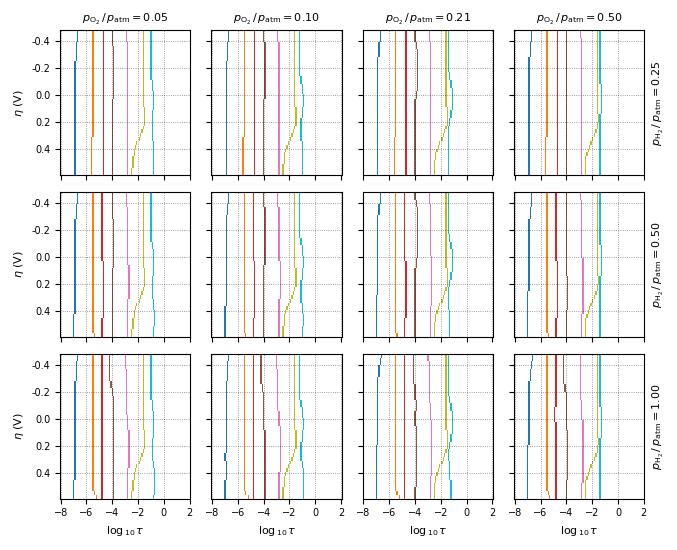

In [20]:
# Show predicted paths in all slices
pred_mask = mapping.path.paths_to_mask_3d(struct_450['x_filt'].shape, pred_paths, True, fill_nan=True)


# fig, axes, sm, cb = pcp.plot_oh_grid(struct_450['rp_raw'][:, :, 1], dim_grids, mrt, vmin=0, vmax=1, alpha=0.7)
_ = pcp.plot_oh_grid(pred_mask[:, :, 0], dim_grids, mrt, cmap='tab10', grid_kw={'c': 'k'})

## Sheet integration
Integrate DRT area in the vicinity of each sheet/path to obtain an initial estimate of the sheet resistance.

In [21]:
rp = struct_450['rp_raw']#[:, :, 0]
path_tau = mapping.path.get_path_tau(mrt.tau_supergrid, pred_paths, rp.shape)
    
# integrate
f = mrt.predict_drt(psi=None, x=struct_450['x_filt'], #[:, :, 0], 
                    tau=mrt.tau_supergrid)
path_dist, path_sizes = mapping.path.integrate_paths(mrt.tau_supergrid, f, pred_paths, 
                                                     troughs=None, widths=16, width_sigma=None,
                                                     weight_multipliers=path_weight_mult,
                                                    constrain_sign=True)

(4, 3, 2, 39, 101)
0 8.0
1.0
(4, 3, 2, 39, 101)
1 8.0
1.0
(4, 3, 2, 39, 101)
2 8.0
1.0
(4, 3, 2, 39, 101)
3 8.0
1.0
(4, 3, 2, 39, 101)
4 8.0
1.0
(4, 3, 2, 39, 101)
5 8.0
1.0
(4, 3, 2, 39, 101)
6 8.0
1.0


## Fit GP-ZARC model
Fit the GP-ZARC model to the DRT hypersurface using the sheet-tracing results for initialization.

In [22]:
# stan_dir = Path('C:\\Users\\jdh10\\OneDrive - Colorado School of Mines\\python\\projects\\hybrid-drt\\hybdrt\\mapping\\stan_models')
# model = CmdStanModel(stan_file=stan_dir.joinpath('gp_marginal_ZARC_lnR_aniso.stan'))

model = load_model('gp_marginal_ZARC_lnR_aniso')

In [23]:
def save_pickle(obj, dest):
    with open(dest, 'wb') as f:
        pickle.dump(obj, f, pickle.DEFAULT_PROTOCOL)
        
def load_pickle(src):
    with open(src, 'rb') as f:
        out = pickle.load(f)
    return out

# save_pickle(stan_results, fit_path.joinpath('FF3_450C_stan_results_230622_b.pkl'))
# save_pickle(stan_results, fit_path.joinpath('FF3_450C_stan_results_230711_prev.pkl'))
# save_pickle(stan_results, fit_path.joinpath('FF3_450C_stan_results_230711.pkl'))

# stan_results =  load_pickle(fit_path.joinpath('FF3_450C_stan_results_230711.pkl'))

In [24]:
# ln(R) ANISOTROPIC
nonneg = True


# Get surface and scale    
y = mrt.predict_drt(psi=None, x=struct_450['x_filt'], #[:, :, 0], 
                    tau=mrt.tau_supergrid)
R_scale_factor = 1 / np.nanstd(y)
y = y * R_scale_factor


ps_i = path_sizes * R_scale_factor
pt_i = path_tau.copy()

# Reshape inputs
# Make copy with original shape
ps_i_orig = ps_i.copy()

y = y.reshape((np.prod(y.shape[:-1]), y.shape[-1]))
# ps_i = ndimage.gaussian_filter1d(ps_i_orig, sigma=1, axis=-1)
ps_i = hybdrt.filters.nan_filter(ps_i, ndimage.gaussian_filter, 
                                 sigma=(0,) + (2,) * (np.ndim(path_sizes) - 1)
                                )
ps_i = ps_i.reshape((ps_i.shape[0], np.prod(ps_i.shape[1:])))


# pt_i = ndimage.gaussian_filter1d(path_tau, sigma=1, axis=-1)
pt_i = hybdrt.filters.nan_filter(path_tau, ndimage.gaussian_filter, 
                                 sigma=(0,) + (1,) * (np.ndim(path_sizes) - 1)
                                )
pt_i = pt_i.reshape((ps_i.shape[0], np.prod(ps_i.shape[1:])))

# Limit to nonneg values
R_sign = np.sign(np.median(ps_i, axis=1))
if nonneg:
    y = np.maximum(y, 0)
    ps_i = ps_i[R_sign > 0]
    ps_i_orig = ps_i_orig[R_sign > 0]
    pt_i = pt_i[R_sign > 0]

# Make data matrix
times = struct_450['psi'][..., mrt.psi_dim_names.index('time')]#[:, :, 0]
X = np.stack([
    np.log(oo_pred).flatten(), 
    np.log(hh_pred).flatten(), 
    np.log(h2o_pred).flatten(),
    vv_pred.flatten(), 
    times.flatten()
]).T

# Scale all pressures together
X[:, :3] /= np.nanstd(X[:, :3])
# Scale eta and time independently
X[:, 3:] /= np.nanstd(X[:, 3:], axis=0)#[:, None]

# Only include measured conditions
fit_index = ~np.max(np.isnan(y), axis=-1)
X = X[fit_index]
y = y[fit_index]
ps_i = ps_i[:, fit_index]
pt_i = pt_i[:, fit_index]

# Set a floor on initial R values to prevent R values from getting stuck at zero
lnr = np.log(np.sqrt(ps_i ** 2 + (1e-1) ** 2))

# y[y <= 0] = 1e-3

K = len(ps_i)
print('K:', K)

stan_data = {
    'N': len(X),
    'D': X.shape[1],
    'M': len(mrt.tau_supergrid),
    'K': K,
    'tau': mrt.tau_supergrid,
    'x': X,
    'y': y,
    'sigma_gp_scale': 0.05,
    'sigma_rel_y_scale': 0.001,
    'sigma_rel_Rp_scale': 1,
    'R_sign': R_sign  # np.sign(np.median(ps_i, axis=1))
}

# ZARC
inits = {
    'lnR_mu': np.median(lnr, axis=1),
    'lntau_mu': np.median(np.log(pt_i), axis=1),
    'beta_trans_mu': np.ones(ps_i.shape[0]),
    'lnR_scale': 2 * np.std(lnr, axis=1),
    'lntau_scale': 2 * np.std(np.log(pt_i), axis=1) + 1e-1,
    'beta_trans_scale': 1 * np.ones(ps_i.shape[0]),
    'sigma_rel_y_raw': 1,
    'sigma_rel_Rp_raw': 1,
    'rho': np.ones((K, X.shape[1])) * 5,
    'alpha': np.ones(K),
    'sigma': np.ones(K)
}

# Initialize long length scale for time
# to ensure it doesn't subsume physical relationships
inits['rho'][:, 4] = 10  

# Set a floor on mean lnR values
inits['lnR_mu'] = np.maximum(inits['lnR_mu'], -3)

# Initialize raw parameters
inits['lnR_raw'] = (lnr - inits['lnR_mu'][:, None]) / inits['lnR_scale'][:, None]
inits['lntau_raw'] = (np.log(pt_i) - inits['lntau_mu'][:, None]) / inits['lntau_scale'][:, None]
inits['beta_trans_raw'] = np.zeros(ps_i.shape)

# Add small amount of random noise to initial tau to facilitate optimization
rng = np.random.default_rng(34232)
inits['lntau_raw'] += np.zeros(pt_i.shape) + rng.normal(0, 0.1, size=pt_i.shape)

try:
    # Comment this or change filename if you want to run the Stan model yourself
    stan_results = load_pickle(fit_path.joinpath('stan_results.pkl'))
except FileNotFoundError:
    start_time = time.time()
    stan_mle = model.optimize(stan_data, iter=200, seed=24823, inits=inits, algorithm='lbfgs', init_alpha=1e-5)
    elapsed = time.time() - start_time
    print('Fit time: {:.1f} s'.format(elapsed))
    print('Converged:', stan_mle.converged)
    stan_results = {
        'mle': stan_mle, 
        'var': stan_mle.stan_variables(), 
        'R_scale': R_scale_factor,
        'orig_shape': ps_i_orig.shape,
        'fit_index': fit_index
    }
    
    save_pickle(stan_results, fit_path.joinpath('stan_results.pkl'))

K: 7


11:24:46 - cmdstanpy - INFO - Chain [1] start processing
11:30:07 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 322.8 s
Converged: True


In [40]:
# Original?
stan_results['var']['rho'], \
stan_results['var']['sigma_rel_y_raw'] * stan_data['sigma_rel_y_scale'],  \
stan_results['var']['sigma_rel_Rp_raw'] * stan_data['sigma_rel_Rp_scale']

(array([[ 5.45584 ,  4.84917 ,  5.25522 ,  0.88068 , 10.2573  ],
        [ 6.09681 ,  4.322   ,  5.24357 ,  1.02271 , 10.2303  ],
        [ 3.06313 ,  3.56897 ,  4.96122 ,  2.26188 ,  9.54068 ],
        [ 3.49272 ,  4.29172 ,  5.04284 ,  2.42748 ,  9.85497 ],
        [ 5.53588 ,  4.62044 ,  5.06156 ,  1.01065 ,  9.93319 ],
        [ 4.77715 ,  5.20567 ,  5.14249 ,  0.498135, 10.2841  ],
        [ 4.53894 ,  5.20286 ,  5.09635 ,  0.501838, 10.23    ]]),
 0.0010222100000000002,
 0.000721546)

In [32]:
# New
stan_results['var']['rho'], \
stan_results['var']['sigma_rel_y_raw'] * stan_data['sigma_rel_y_scale'],  \
stan_results['var']['sigma_rel_Rp_raw'] * stan_data['sigma_rel_Rp_scale']

(array([[ 5.18573 ,  4.78844 ,  5.19991 ,  0.950389, 10.2758  ],
        [ 5.90509 ,  4.1487  ,  5.20672 ,  0.83191 , 10.1363  ],
        [ 5.37655 ,  4.52449 ,  5.09977 ,  1.68347 , 10.0166  ],
        [ 4.49366 ,  4.22494 ,  5.09417 ,  1.21521 ,  9.90833 ],
        [ 5.68585 ,  4.65185 ,  5.11147 ,  0.794142, 10.109   ],
        [ 4.82903 ,  5.27114 ,  5.13265 ,  0.485546, 10.3384  ],
        [ 4.51023 ,  5.20196 ,  5.08248 ,  0.527285, 10.2416  ]]),
 0.00102529,
 0.00066278)

In [25]:
# Format stan output
def reshape_output(output, orig_shape, fit_index):
    out = np.empty((output.shape[0], len(fit_index)))
    out.fill(np.nan)
    out[:, fit_index] = output
    return out.reshape(orig_shape)

R_stack = reshape_output(stan_results['var']['R'], stan_results['orig_shape'], stan_results['fit_index'])
R_stack /= stan_results['R_scale']

lt_stack = reshape_output(stan_results['var']['lntau'], stan_results['orig_shape'], stan_results['fit_index'])

beta_stack = reshape_output(stan_results['var']['beta'], stan_results['orig_shape'], stan_results['fit_index'])

r2: 0.9979079902498171


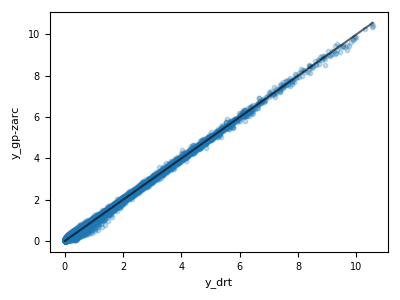

In [26]:
# Check GP-ZARC fit quality
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(stan_data['y'], stan_results['var']['y_hat'], s=10, alpha=0.25)
y_plot = [np.min(y), np.max(y)]
ax.plot(y_plot, y_plot, c='k', zorder=10, alpha=0.6)

r2 = r2_score(stan_data['y'].flatten(), stan_results['var']['y_hat'].flatten())
print('r2:', r2)
ax.set_xlabel('y_drt')
ax.set_ylabel('y_gp-zarc')
fig.tight_layout()

<IPython.core.display.Javascript object>


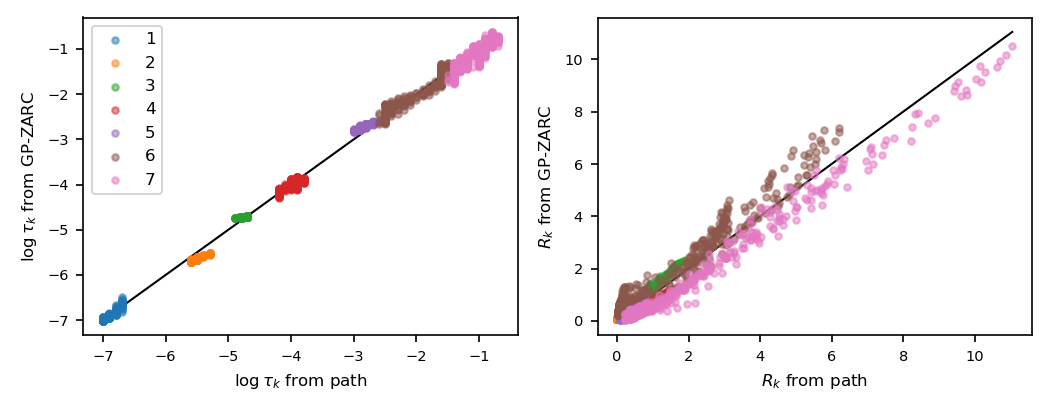

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(7, 2.75))

for k in range(R_stack.shape[0]):
    axes[0].scatter(np.log10(path_tau[k]).flatten(), np.log10(np.exp(lt_stack[k])).flatten(), 
                    s=10, alpha=0.5, label=k + 1)
    axes[1].scatter(path_sizes[k].flatten(), R_stack[k].flatten(), s=10, alpha=0.5)
    
lt_plot = [np.min(np.log10(path_tau)), np.max(np.log10(path_tau))]
axes[0].plot(lt_plot, lt_plot, c='k', lw=1, zorder=-10)
R_plot = [np.nanmin(path_sizes), np.nanmax(path_sizes)]
axes[1].plot(R_plot, R_plot, c='k', lw=1, zorder=-10)

axes[0].set_xlabel(r'$\log{\tau_k}$ from path')
axes[0].set_ylabel(r'$\log{\tau_k}$ from GP-ZARC')
axes[0].legend()

axes[1].set_xlabel('$R_k$ from path')
axes[1].set_ylabel('$R_k$ from GP-ZARC')
fig.tight_layout()

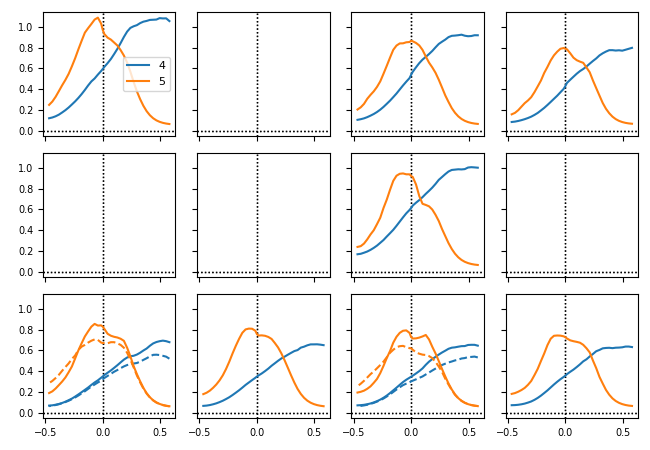

In [35]:
fig, axes = plt.subplots(3, 4, figsize=(6.5, 4.5), sharex=True, sharey=True)

lt_axes = []
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
#         ax2 = axes[i, j].twinx()
#         lt_axes.append(ax2)
        for k in range(3, 5):
            p = axes[i, j].plot(-v_base, R_stack[k, j, i, 0], label=k+1)
            axes[i, j].plot(-v_base, R_stack[k, j, i, 1], ls='--', c=p[0].get_color())
            
#             p = axes[i, j].plot(-v_base, path_sizes[k, j, i, 0], label=k+1)
#             axes[i, j].plot(-v_base, path_sizes[k, j, i, 1], ls='--', c=p[0].get_color())
            
#             ax2.plot(-v_base, lt_stack[k, j, i, 0] / np.log(10), c=p[0].get_color(), ls=':')
            axes[i, j].axvline(0, c='k', lw=1, zorder=-10, ls=':')
            axes[i, j].axhline(0, c='k', lw=1, zorder=-10, ls=':')
            
# lt_axes[0].get_shared_y_axes().join(*lt_axes)
# for i, ax in enumerate(lt_axes):
#     if i % 4 != 3:
#         ax.set_yticklabels([])
        
axes[0, 0].legend()
        
fig.tight_layout()

<IPython.core.display.Javascript object>


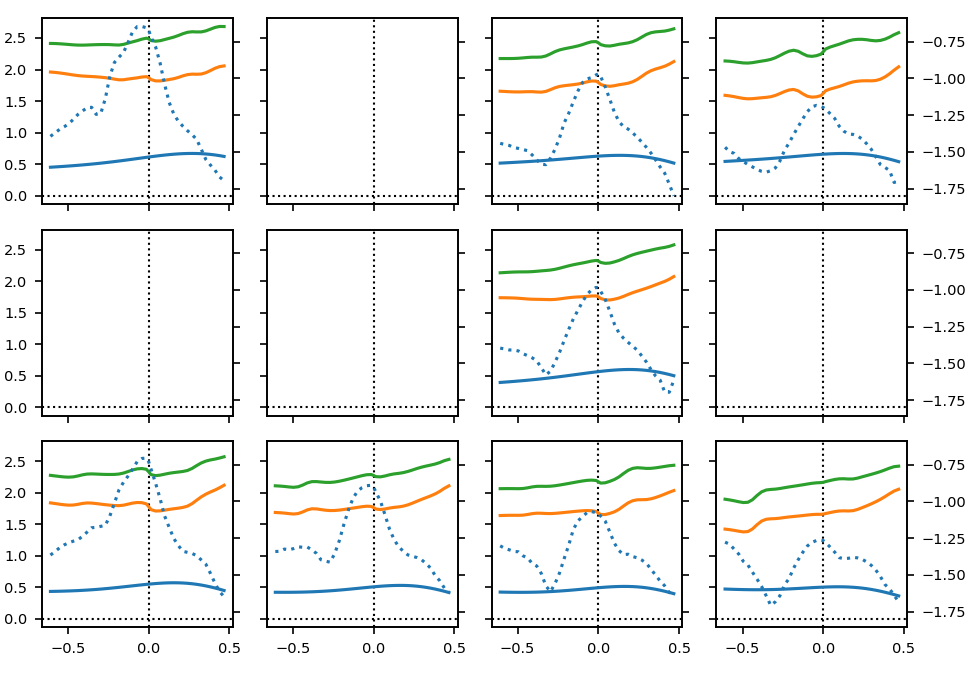

In [2985]:
fig, axes = plt.subplots(3, 4, figsize=(6.5, 4.5), sharex=True, sharey=True)

lt_axes = []
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax2 = axes[i, j].twinx()
        lt_axes.append(ax2)
        
        p = axes[i, j].plot(v_base, R_stack[0, j, i])
        ax2.plot(v_base, lt_stack[k, j, i] / np.log(10), c=p[0].get_color(), ls=':')
        axes[i, j].plot(v_base, struct_450['R_inf_filt'][:, :, 0][j, i])
        axes[i, j].plot(v_base, R_stack[0, j, i] + struct_450['R_inf_filt'][:, :, 0][j, i])
        axes[i, j].axvline(0, c='k', lw=1, zorder=-10, ls=':')
        axes[i, j].axhline(0, c='k', lw=1, zorder=-10, ls=':')
            
lt_axes[0].get_shared_y_axes().join(*lt_axes)
for i, ax in enumerate(lt_axes):
    if i % 4 != 3:
        ax.set_yticklabels([])
        
fig.tight_layout()

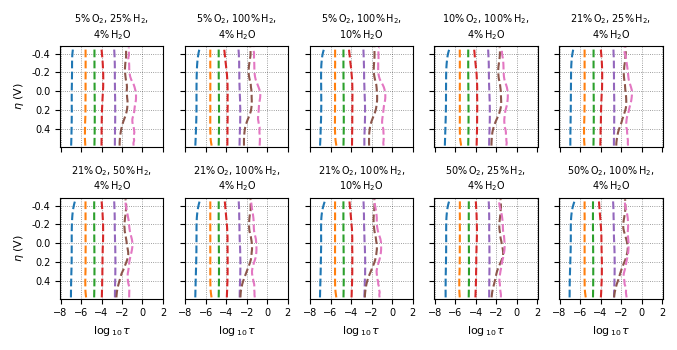

In [36]:
# Show optimized sheets in all slices
gamma = mrt.predict_drt(x=struct_450['x_filt']) * a_cell
f = hybdrt.filters.gaussian_laplace1d(gamma, axis=-1, sigma=4)
# dummy plot to set up axis formatting
fig, axes, sm, _  = pcp.plot_pres_grid(struct_450['x_norm'], struct_450['dim_grids'], mrt, 
                                       drt=True,
                                       cmap='viridis', cbar_h=False, alpha=0, grid_kw={'c': 'k'})

ii = 0
for i in range(4):
    for j in range(3):
        for k in range(2):
            if not np.min(np.isnan(struct_450['x_filt'][i, j, k])):
                for n in range(lt_stack.shape[0]):
                    axes.ravel()[ii].plot(np.log10(np.exp(lt_stack[n, i, j, k])), v_base, ls='--', alpha=1.0,
                                         label=f'P{k+1}')
                ii += 1
                

# Show illustrative slices

0.4101219330881979
0.0
-0.38183766184073564
0.4101219330881979
0.0
-0.38183766184073564


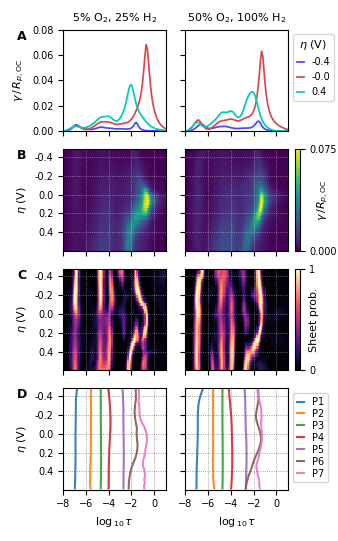

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(full_width * 0.5, full_width * 0.8), sharex=True, sharey=False)
dim_grids = struct_450['dim_grids']

slices = [(0, 0, 0), (3, 2, 0)]
for i, slice_index in enumerate(slices):
    x = struct_450['x_filt'][slice_index]
    rp = struct_450['rp_mix'][slice_index]
#     tp = struct_450['tp_mix'][slice_index]
    gamma = mrt.predict_drt(psi=None, x=x, tau=mrt.tau_supergrid)
    Rp = np.sum(gamma, axis=-1)
    Rp_oc = Rp[v_base == 0]
    
    gamma_norm = gamma / Rp_oc#[..., None]
    
    for j_i, j in enumerate([36, 21, 7]):
        axes[0, i].plot(np.log10(mrt.tau_supergrid), gamma_norm[j], label=-round(v_base[j], 1),
                       c=light_colors[j_i], lw=1.25)
        print(v_base[j])
    
    
    sm_gamma, _ = pcp.plot_x_2d(v_base, gamma_norm, mrt, ax=axes[1, i], cmap='viridis', 
                                vmin=0, vmax=0.075,
                                grid_kw={'c': 'white'}, normalize=False)
    
    
#     for j, ax in enumerate(axes[1:, i]):
#         if j == 1:
#             alpha = 0.
#         else:
#             alpha = 1
    sm_rp, _ = pcp.plot_x_2d(v_base, rp, mrt, ax=axes[2, i], cmap='magma', vmin=0, vmax=1,
                 grid_kw={'c': 'white'}, normalize=False)
    
    # Plot again just for grid formatting
    pcp.plot_x_2d(v_base, rp, mrt, ax=axes[3, i], cmap='magma', vmin=0, vmax=1,
                 grid_kw={'c': 'k'}, normalize=False, alpha=0)
    
    # Plot paths
    for k in range(len(lt_stack)):
        axes[3, i].plot(np.log10(np.exp(lt_stack[(k, ) + slice_index])), v_base, ls='-', alpha=0.9,
                       label=f'P{k + 1}')
        
    # label atmosphere
    
    axes[0, i].set_title('{:.0f}% O$_2$, {:.0f}% H$_2$'.format(100 * dim_grids[0][slice_index[0]], 
                                                               100 *dim_grids[1][slice_index[1]]),
                        fontsize=8)
        
axes[0, 1].legend(fontsize=7, title='$\eta$ (V)', loc='upper left', bbox_to_anchor=(1, 1),
                 handlelength=0.75)
    
axes[0, 0].set_ylabel('$\gamma \, / \, R_{p, \mathrm{OC}}$')
for ax in axes[0]:
    ax.set_ylim(0, 0.08)
    
for ax in axes[:, 1]:
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
for ax in axes[:-1].ravel():
    ax.set_xlabel('')
    
for ax in axes[1:, :].ravel():
    ax.set_xlim(-8, 1)
    
axes[3, 1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=7, handlelength=0.75, labelspacing=0.2)
    
fig.tight_layout()

# Add colorbars
fig.subplots_adjust(right=0.85)
caxes = []
for i in range(2):
    bbox = axes[i + 1, 1].get_position()
    cax = fig.add_axes([bbox.x1 + 0.02, bbox.y0, 0.015, bbox.y1 - bbox.y0])
    caxes.append(cax)
    
cb_gamma = fig.colorbar(sm_gamma, cax=caxes[0])
cb_gamma.set_ticks([0, 0.075])
cb_gamma.set_label(r'$\gamma \, / R_{p, \mathrm{OC}}$', labelpad=-15)

cb_rp = fig.colorbar(sm_rp, cax=caxes[1])
cb_rp.set_ticks([0, 1])
cb_rp.set_label('Sheet prob.', labelpad=-5)

ff.add_letters(axes[:, 0], loc=(-0.45, 1))
# fig.subplots_adjust(hspace=0.3)

ff.savefig(fig, 'PCEC_MapFig_left', ext='png')

# Direct parameter GP

In [52]:
# Train GPs on stan results
times = struct_450['psi'][..., mrt.psi_dim_names.index('time')] #[:, :, 0]
X_train = np.stack([
    oo_pred.flatten(), 
    hh_pred.flatten(), 
    h2o_pred.flatten(),
    vv_pred.flatten(), 
    times.flatten()
]).T
X_train = X_train[stan_results['fit_index']]

stan_gps = stan_utils.gps_from_stan(stan_data, stan_results, X_train, extract_kernel=False, noise_level=0.005)

c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\jdh10\anaconda3\envs\opencv\lib\site-pac

In [53]:
# Check kernels
for gpi in stan_gps['R']:
    print(gpi['gp'].reg.kernel_)

RBF(length_scale=[0.419, 1.08, 1.56, 1.25, 1e+03]) + WhiteKernel(noise_level=0.005)
RBF(length_scale=[6.88, 4.28, 1e+03, 0.922, 1e+03]) + WhiteKernel(noise_level=0.005)
RBF(length_scale=[0.9, 1.35, 6.32, 2.28, 1e+03]) + WhiteKernel(noise_level=0.005)
RBF(length_scale=[2.21, 0.474, 0.606, 1.59, 1e+03]) + WhiteKernel(noise_level=0.005)
RBF(length_scale=[1.21, 2.19, 0.343, 0.841, 31.1]) + WhiteKernel(noise_level=0.005)
RBF(length_scale=[0.507, 8.74, 233, 0.752, 47.8]) + WhiteKernel(noise_level=0.005)
RBF(length_scale=[0.421, 4.66, 0.426, 0.648, 44.3]) + WhiteKernel(noise_level=0.005)


In [40]:
# Make GP for R_inf
kernel_inf = 1.0 * kernels.RBF(length_scale=(1, 1, 1, 1, 2), length_scale_bounds=(0.1, 1000))

# Set a higher noise level because R_inf has not been through GP-ZARC optimization
kernel_inf += kernels.WhiteKernel(noise_level=0.2, noise_level_bounds='fixed')

# Transform partial pressures
pres_trans = stan_utils.PressureTransform(pres_indices=[0, 1, 2], log_scale=True)

gp_inf_ = GaussianProcessRegressor(kernel=kernel_inf, normalize_y=True)
gp_inf = Pipeline([('trans', pres_trans), ('gp', gp_inf_)])

R_inf = struct_450['R_inf'].copy()

# R_inf is unfiltered - must impute nans
R_inf = mapping.nddata.impute_nans(R_inf, sigma=(0, 0, 0, 1))
R_inf_train = R_inf.flatten()[stan_results['fit_index']]
gp_inf.fit(X_train, R_inf_train)

print(gp_inf['gp'].kernel_)

C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\filters\_filters.py:175: RuntimeWarning: invalid value encountered in true_divide
  return x_filt / mask_filt


2.84**2 * RBF(length_scale=[0.382, 4.44, 0.522, 2.57, 1e+03]) + WhiteKernel(noise_level=0.2)


c:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


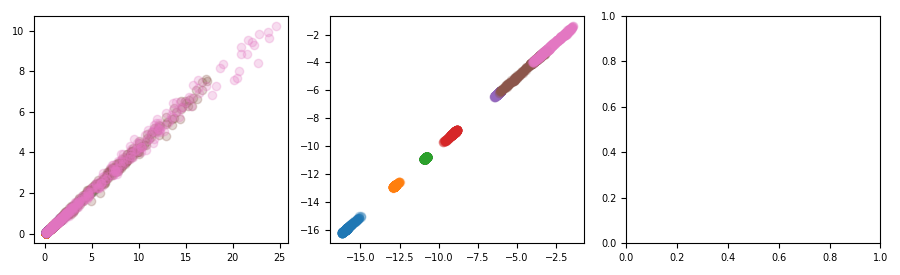

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(9, 2.75))

for k in range(len(stan_gps['R'])):
    R_pred = stan_gps['R'][k].predict(X_train)
    tau_pred = stan_gps['tau'][k].predict(X_train)
    # beta_pred = stan_gps['beta'][k].predict(X_train)

    axes[0].scatter(stan_results['var']['R'][k], R_pred, alpha=0.25)
    axes[1].scatter(stan_results['var']['lntau'][k], np.log(tau_pred), alpha=0.25)
    # axes[2].scatter(stan_results['var']['beta'][k], beta_pred, alpha=0.25)

fig.tight_layout()

## Partial dependence plots

In [43]:
def pdp_custom(gp, X_train, features, values):
    grid = cartesian(values)
    averaged_predictions, predictions = _partial_dependence_brute(gp, grid, features, X_train, 'auto')
    predictions = predictions.reshape(
                -1, X_train.shape[0], *[val.shape[0] for val in values]
            )

    averaged_predictions = averaged_predictions.reshape(
            -1, *[val.shape[0] for val in values]
        )
    
    return dict(values=values, average=averaged_predictions, individual=predictions)

In [44]:
#State variable grids for PDP calculation
po2_grid = struct_450['dim_grids'][0]
ph2_grid = struct_450['dim_grids'][1]
ph2o_grid = struct_450['dim_grids'][2]
v_grid = np.arange(-0.6, 0.46, 0.025)

values = [po2_grid, ph2_grid, ph2o_grid, v_grid]


In [54]:
# calculate PD
stan_pdps = {}

for name in stan_gps.keys():
    stan_pdps[name] = {}
    for i, gas in enumerate(['o2', 'h2', 'h2o']):
        pdp_list = []
        for k in range(len(stan_gps[name])):
            pdp_k = pdp_custom(stan_gps[name][k], X_train, [i, 3], [dim_grids[i], v_grid])
            pdp_list.append(pdp_k)

        stan_pdps[name][gas] = pdp_list
        
inf_pdps = {}
for i, gas in enumerate(['o2', 'h2', 'h2o']):
    inf_pdps[gas] = pdp_custom(gp_inf, X_train, [i, 3], [dim_grids[i], v_grid])

## ASR PDP

In [46]:
# Functions for calculating i-v data from predicted resistances
def predict_dv(current, r_tot, axis=-1):
    r_tot_swap = r_tot.swapaxes(-1, axis)

    op_axes = list(range(np.ndim(r_tot) - 1))
    it = np.nditer(r_tot_swap, op_axes=[op_axes], flags=['multi_index'])
    
    if np.shape(current) == np.shape(r_tot):
        dv_out = np.array([
            cumtrapz(r_tot_swap[it.multi_index], x=current[it.multi_index], initial=0)
            for _ in it
        ])
        
        it.reset()
        offsets = np.array([
            interp1d(current[it.multi_index], dv_out[i])(0)
            for i, _ in enumerate(it)
        ])
    else:
        # Assume current is 1d
        dv_out = np.array([
            cumtrapz(r_tot_swap[it.multi_index], x=current, initial=0)
            for _ in it
        ])
    
#     it = np.nditer(r_tot_swap, op_axes=[op_axes], flags=['multi_index'])
        offsets = np.array([
            interp1d(current, dv_out[i])(0)
            for i in range(dv_out.shape[0])
        ])
    
#     print(dv_out.shape, offsets.shape, np.expand_dims(offsets, axis=axis).shape)
    
    dv_out -= offsets[:, None]
    
    dv_out = dv_out.reshape(r_tot_swap.shape)
    
    return dv_out.swapaxes(-1, axis)


def predict_di(eta, r_tot, axis=-1):
    r_tot_swap = r_tot.swapaxes(-1, axis)
    
    op_axes = list(range(np.ndim(r_tot) - 1))
    it = np.nditer(r_tot_swap, op_axes=[op_axes], flags=['multi_index'])
    if np.shape(eta) == np.shape(r_tot):
        di_out = np.array([
            cumtrapz(r_tot_swap[it.multi_index] ** -1, x=eta[it.multi_index], initial=0)
            for _ in it
        ])
        
        it.reset()
        offsets = np.array([
            interp1d(eta[it.multi_index], di_out[i])(0)
            for i, _ in enumerate(it)
        ])
    else:
        di_out = np.array([
            cumtrapz(r_tot_swap[it.multi_index] ** -1, x=eta, initial=0)
            for _ in it
        ])
    
        offsets = np.array([
            interp1d(eta, di_out[i])(0)
            for i in range(di_out.shape[0])
        ])
    
#     print(di_out.shape, offsets.shape, np.expand_dims(offsets, axis=axis).shape)
    
    di_out -= offsets[:, None]
    
    di_out = di_out.reshape(r_tot_swap.shape)
    
    return di_out.swapaxes(-1, axis)

def plot_vlines(v_grid, y_arr, grid, alpha1, alpha2, ax, color):
    for i in range(len(y_arr)):
        alpha = ff.y_to_alpha(grid[i], grid[0], grid[-1], alpha1, alpha2)
        ax.plot(v_grid, y_arr[i], c=color, alpha=alpha)
        
        
def plot_vgrad(v_grid, y_arr, grid, alpha1, alpha2, ax, color, nx=500, ny=500, **kw):
    ff.gradient_fill_between(v_grid, y_arr[0], y_arr[-1],
                  alpha1=alpha1, alpha2=alpha2,
                  nx=nx, ny=ny,
                  fill_color=None, ax=ax, c=color, **kw)
    
def dy_dx(y, x, axis=0):
    dy = np.take(y, -1, axis=axis) - np.take(y, 0, axis=axis) 
    dx = x[-1] - x[0]
    return dy / dx

(2, 3)
(1, 3)
(1, 2)


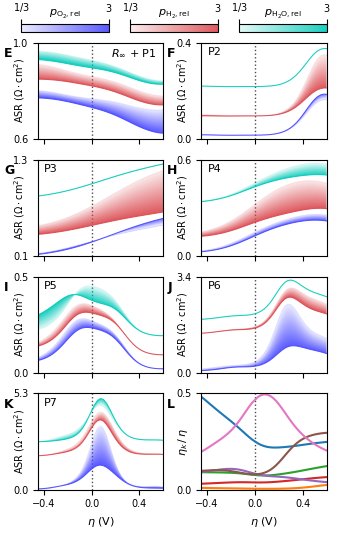

In [58]:
# NEW figure
fig, axes = plt.subplots(4, 2, figsize=(full_width * 0.5, full_width * 0.8), sharex=True, sharey=False)

R_k_dict = {}
R_inf_dict = {}
pres_ranges = {}
p_factor = 9
for i, gas in enumerate(stan_pdps['R'].keys()):
    ax_list = tuple([ii + 1 for ii in range(3) if ii != i])
    print(ax_list)
    
    y_k = np.stack([p['average'][0] for p in stan_pdps['R'][gas]])
    y_inf = inf_pdps[gas]['average'][0]
    x_i = np.log(stan_pdps['R'][gas][0]['values'][0])
    
    # Add ohmic to P1
    y_k[0] = y_k[0] + y_inf
    
#     y_i = np.mean(r_avg, axis=ax_list)
#     x_i = pdp_r['values'][i]
    
    x_cent = np.mean(x_i)
    ln_p_range = np.array([x_cent - 0.5 * np.log(p_factor), x_cent + 0.5 * np.log(p_factor)])
    pres_ranges[gas] = ln_p_range
    
    for y_i, R_dict in zip([y_k, y_inf], [R_k_dict, R_inf_dict]):
        if y_i is y_inf:
            axis = 0
        else:
            axis = 1
        dlnr_dlnp = dy_dx(np.log(y_i), x_i, axis=axis)
        y_cent = np.mean(y_i, axis=axis)
        y1 = y_cent * (p_factor ** -0.5) ** dlnr_dlnp
        y2 = y_cent * (p_factor ** 0.5) ** dlnr_dlnp
        y_range = np.stack([y1, y2], axis=axis)
        R_dict[gas] = y_range

    
# y_o2 = np.mean(r_avg, axis=(2, 3))
# y_h2 = np.mean(r_avg, axis=(1, 3))
# y_h2o = np.mean(r_avg, axis=(1, 2))
# y_tot = np.mean(r_avg, axis=(1, 2, 3))



# tau, capacitance
# lt_avg = pdp_lt['average'] * np.log10(np.exp(1))
# lc_avg = lt_avg - np.log10(r_avg)

alpha1 = 0.1
alpha2 = 0.9
grad_lw = 0.75

num_sheets = 7 # r_avg.shape[0]

# Ohmic
r_med = 1 / a_cell

# Low pressure to high
# R_inf_avg = pdp_inf['average'][0]
# y_inf_o2 = np.mean(R_inf_avg, axis=(1, 2))
# y_inf_h2 = np.mean(R_inf_avg, axis=(0, 2))
# y_inf_h2o = np.mean(R_inf_avg, axis=(0, 1))
# plot_vgrad(-v_grid, y_inf_o2 / r_med, lnpo2_grid, alpha1, alpha2, axes[0, 0], light_colors[0])
# plot_vgrad(-v_grid, y_inf_h2 / r_med, lnph2_grid, alpha1, alpha2, axes[0, 0], light_colors[1])
# plot_vgrad(-v_grid, y_inf_h2o / r_med, lnph2o_grid, alpha1, alpha2, axes[0, 0], light_colors[2])

# DRT peaks
for k in range(num_sheets):
    ax = axes.ravel()[k]
    
#     r_med = np.percentile(np.abs(r_avg[k]), 75) * R_sign[k]
#     r_med = np.mean(r_avg[k])
    r_med = 1 / a_cell

    # Low pressure to high
    y_prev = [0]
    offset = 0
    
    y_tot = []
    # Get all R_k values to determine offset
    for gas in R_k_dict.keys():
        y_tot.append(R_k_dict[gas][k])
    y_tot = np.stack(y_tot)
    y_tot_range = np.max(y_tot) - np.min(y_tot)
            
    for i, gas in enumerate(R_k_dict.keys()):
#         if k == -1:
#             y_i = R_inf_dict[gas]
#             # Get all R_inf values to determine offset
#             y_tot = np.stack([v for v in R_inf_dict.values()])
#         else:
        y_i = R_k_dict[gas][k]
            
#         offset = (np.max(y_tot) - np.min(y_tot)) * 0.6

        if i > 0:
            offset += np.max(np.max(y_prev, axis=0) - np.min(y_i, axis=0)) + y_tot_range * 0.1
        
        plot_vgrad(-v_grid, (y_i + offset) / r_med, pres_ranges[gas], alpha1, alpha2, ax, light_colors[i],
                  lw=grad_lw)
        
        
        y_prev = y_i.copy()
    
    
for k in range(1, num_sheets):
    ax = axes.ravel()[k]
    ax.text(0.05, 0.95, f'P{k + 1}', transform=ax.transAxes, ha='left', va='top')
    
axes[0, 0].text(0.95, 0.95, r'$R_{\infty}$ + P1', transform=axes[0, 0].transAxes, ha='right', va='top')
# axes[0, 1].text(0.05, 0.95, 'P1', transform=axes[0, 1].transAxes, ha='left', va='top')
    
for ax in axes.ravel():
    # Mark OCV
    ax.axvline(0, c='k', ls=':', lw=1, alpha=0.7, zorder=-10)
    #     ax.set_ylabel(fr'$R_{k + 1}$')

    # Expand ylim - not enough space for patch by default
    ylim = ax.get_ylim()
    y_rng = ylim[1] - ylim[0]
    ax.set_ylim(ylim[0] - y_rng * 0.05, ylim[1] + y_rng * 0.05)
    if ax.get_ylim()[0] < 0:
        ax.set_ylim(0, ax.get_ylim()[1])
        
    # Round ylim to 1 decimal place
    y0, y1 = ax.get_ylim()
    y0 = round(y0, 1) 
    y1 = round(y1, 1) 
#     y0 = np.floor(y0 * 10) / 10
#     y1 = np.ceil(y1 * 10) / 10
    ax.set_ylim(y0, y1)
    ax.set_yticks([y0, y1])
    
# for ax in axes[:, 0]:
#     ax.set_ylabel(r'$R_k$ ($\Omega \cdot \mathrm{cm}^2$)') #' \, / \, \overline{R_k}$')
for ax in axes.ravel()[:-1]:
    ax.set_ylabel(r'ASR ($\Omega \cdot \mathrm{cm}^2$)', labelpad=-10, fontsize=7)
    

# TODO: manually set ticks to reduce decimal places
# axes[0, -1].set_yticks([0., 0.4, 0.8])
# axes[1, -1].set_yticks([0., -0.5, -1])

# Cumulative losses
# ----------------------
X_pred = np.zeros((len(v_grid), X_train.shape[1]))
X_pred[:, 0] = 0.21
X_pred[:, 1] = 1.0
X_pred[:, 2] = 0.035
X_pred[:, 3] = v_grid
X_pred[:, 4] = np.median(X_train[:, 4])
R_pred = np.stack([gp.predict(X_pred) for gp in stan_gps['R']])
R_inf_pred = gp_inf.predict(X_pred)
R_pred[0] += R_inf_pred
# r_avg = np.stack([p['average'][0] for p in stan_v_pdps])
R_tot = np.sum(R_pred, axis=0) #+ R_inf_avg
R_tot = np.squeeze(R_tot)
i_tot = predict_di(v_grid, R_tot, axis=-1)

eta_k = np.zeros(R_pred.shape)
# eta_inf = predict_dv(i_tot, R_inf_avg[0])
for k in range(len(eta_k)):
    eta_k[k] = predict_dv(i_tot, R_pred[k])
plot_index = np.abs(v_grid) > 0.02
for k in range(eta_k.shape[0]):
    axes[3, 1].plot(-v_grid[plot_index], (eta_k[k] / v_grid)[plot_index], label=f'P{k + 1}')
    
axes[3, 1].set_ylim(0, 0.5)
axes[3, 1].set_yticks([0, 0.5])
axes[3, 1].set_ylabel('$\eta_k \, / \, \eta$', labelpad=-10)

for ax in axes[-1]:
    ax.set_xticks([-0.4, 0, 0.4])
    ax.set_xlabel('$\eta$ (V)')
    
fig.tight_layout()

# TODO: manually set ticks to reduce decimal places
# axes[0, -1].set_yticks([0., 0.4, 0.8])
# axes[1, -1].set_yticks([0., -0.5, -1])

fig.subplots_adjust(top=0.92)

# Make colorbars
cb_hspace = 0.02
cb_height = 0.015
bbox0 = axes[0, 0].get_position()
bbox1 = axes[0, 1].get_position()
caxes = []
x_expand_l = 0.05
x_expand_r = 0.0
x_range = bbox1.x1 + x_expand_r - (bbox0.x0 - x_expand_l)
x_space = x_range * 0.07
x_width = (x_range - 2 * x_space) / 3
for i in range(3):
    x0 = bbox0.x0 - x_expand_l + i * x_space + i * x_width
    caxes.append(fig.add_axes([x0, bbox0.y1 + cb_hspace, x_width, cb_height]))

chem_labels = [
    '$p_{\mathrm{O}_2, \mathrm{rel}}$', 
    '$p_{\mathrm{H}_2, \mathrm{rel}}$', 
    '$p_{\mathrm{H}_2 \mathrm{O}, \mathrm{rel}}$'
]
cbs = []
for i, gas in enumerate(R_k_dict.keys()):
    # pO2
    # norm_o2 = mpl.colors.LogNorm(vmin=np.exp(lnpo2_grid[0]), vmax=np.exp(lnpo2_grid[-1]))
    norm = mpl.colors.Normalize(vmin=p_factor ** -0.5, vmax=p_factor ** 0.5)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'px', [(*light_colors[i], alpha1), (*light_colors[i], alpha2)]
    )
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    cb = fig.colorbar(sm, ticks=[p_factor ** -0.5, p_factor ** 0.5], cax=caxes[i], orientation='horizontal')
#     cb.set_ticklabels(['{:.2g}'.format(p_factor ** a) for a in [-0.5, 0.5]])
    cb.set_ticklabels(['$1/{:.0f}$'.format(p_factor ** 0.5), '{:.0f}'.format(p_factor ** 0.5)])
    caxes[i].xaxis.set_ticks_position('top')
    cb.set_label(chem_labels[i], labelpad=-17)

# # pH2
# norm_h2 = mpl.colors.Normalize(vmin=np.exp(pres_ranges['h2'][0]), vmax=np.exp(pres_ranges['h2'][-1]))
# cmap_h2 = mpl.colors.LinearSegmentedColormap.from_list('ph2', [(*light_colors[1], alpha1), (*light_colors[1], alpha2)])
# sm_h2 = mpl.cm.ScalarMappable(norm=norm_h2, cmap=cmap_h2)

# cb_h2 = fig.colorbar(sm_h2, ticks=[np.log(0.25), np.log(1.0)], cax=caxes[1], orientation='horizontal')
# cb_h2.set_ticklabels([0.25, 1])
# caxes[1].xaxis.set_ticks_position('top')
# cb_h2.set_label('$p_{\mathrm{H}_2} \, / \, p_{\mathrm{atm}}$', labelpad=-20)



ff.add_letters(axes, start_index=4, loc=(-0.27, 0.95))

ff.savefig(fig, 'PCEC_MapFig_right', ext='png')

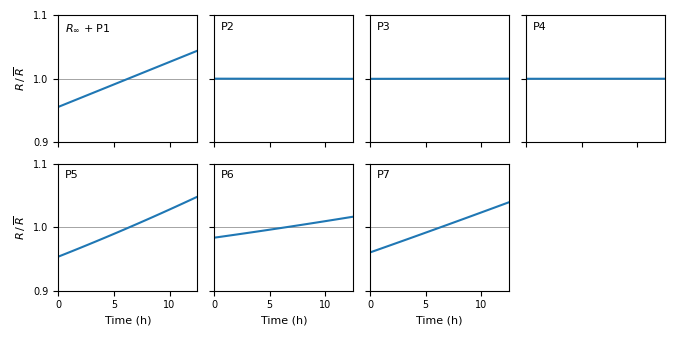

In [59]:
# Time PDP
time_grid = np.linspace(np.nanmin(times), np.nanmax(times), 20)
stan_time_pdps = {}
for name in ['R']:
    pdp_list = []
    for k in range(len(stan_gps[name])):
        pdp_k = pdp_custom(stan_gps[name][k], X_train, [4], [time_grid])
        pdp_list.append(pdp_k)
    stan_time_pdps[name] = pdp_list
    
inf_time_pdp = pdp_custom(gp_inf, X_train, [4], [time_grid])

# # eta 1d pdp
# stan_v_pdps = {}
# for name in ['R']:
#     pdp_list = []
#     for k in range(len(stan_gps[name])):
#         pdp_k = pdp_custom(stan_gps[name][k], X_train, [3], [v_grid])
#         pdp_list.append(pdp_k)
#     stan_v_pdps[name] = pdp_list
    
# inf_v_pdp = pdp_custom(gp_inf, X_train, [3], [v_grid])

fig, axes = plt.subplots(2, 4, figsize=(full_width, full_width * 0.5), sharex=True, sharey=True)

# axes[0, 0].get_shared_x_axes().join(*axes.ravel())
# axes[0, 0].get_shared_y_axes().join(*axes.ravel())

# # OLD: tau-capacitance distributions
# lc10 = np.log10(np.exp(lt_stack) / (a_cell * R_stack))
# lt10 = np.log10(np.exp(lt_stack))

# for k in range(lt10.shape[0]):
#     sn.kdeplot(x=lt10[k][~np.isnan(lt10[k])], y=lc10[k][~np.isnan(lt10[k])], 
#                ax=axes[0, 0], levels=[0.05], linewidths=1)
#     # Plot dummy line for legend
#     axes[0, 0].plot([100], [100], label=f'P{k + 1}', c=default_colors[k])

# axes[0, 0].set_xlim(-7.25, 0.25)
# axes[0, 0].set_ylim(-7., 0.5)
# axes[0, 0].legend(fontsize=7, handlelength=0.7, labelspacing=0.2, ncol=2, loc='lower right',
#                  columnspacing=0.35)

# axes[0, 0].set_xticks([-7, 0])
# axes[0, 0].set_yticks([-7, 0])

# axes[0, 0].set_xlabel(r'$\log_{10}(\tau_k)$', labelpad=-8)
# axes[0, 0].set_ylabel(r'$\log_{10}(C_k \, / \, A_{\mathrm{geo}})$', labelpad=-12)

# Remaining axes: time PDP
for k in range(len(stan_time_pdps['R'])):
    p = stan_time_pdps['R'][k]
    vals = p['average'][0]
    t_plot = p['values'][0]
    t_plot = (t_plot - t_plot[0]) / 60
    if k == 0:
        vals = vals + inf_time_pdp['values'][0]
        
    ax = axes.ravel()[k]
    ax.plot(t_plot, vals / np.mean(vals))
    if k == 0:
        text = '$R_\infty$ + P1'
    else:
        text = f'P{k + 1}'
    ax.text(0.05, 0.95, text, transform=ax.transAxes, ha='left', va='top')
#     ax.set_xticks([0, 12.5])
    ax.set_xlim(0, 12.5)
    ax.set_yticks([0.9, 1.0, 1.1])
    
    ax.axhline(1, c='k', lw=0.5, zorder=-10, alpha=0.5)

for ax in axes[1]:
    ax.set_xlabel('Time (h)')

for ax in axes[:, 0]:
    ax.set_ylabel('$R \, / \, \overline{R}$')

fig.tight_layout()
# loci = [(-0.25, 0.9)] + [(-0.1, 0.95)] * 3
# ff.add_letters(axes.ravel()[:-1], loc=loci * 2)

axes[1, -1].axis('off')


ff.savefig(fig, 'Supp_PCEC_TimePDP')

## Capacitance PDP

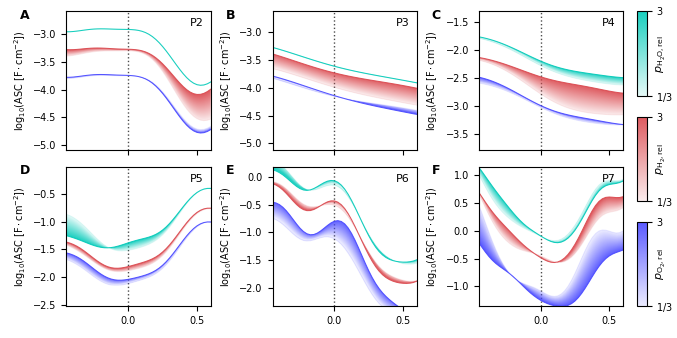

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.5), sharex=True, sharey=False)

C_k_dict = {}
pres_ranges = {}
p_factor = 9
for i, gas in enumerate(stan_pdps['R'].keys()):

    R_k = np.stack([p['average'][0] for p in stan_pdps['R'][gas]]) * a_cell
    tau_k = np.stack([p['average'][0] for p in stan_pdps['tau'][gas]])
    y_i = tau_k / R_k
    x_i = np.log(stan_pdps['R'][gas][0]['values'][0])
    
    x_cent = np.mean(x_i)
    ln_p_range = np.array([x_cent - 0.5 * np.log(p_factor), x_cent + 0.5 * np.log(p_factor)])
    pres_ranges[gas] = ln_p_range
    
    dlnc_dlnp = dy_dx(np.log(y_i), x_i, axis=1)
    y_cent = np.mean(y_i, axis=1)
    y1 = y_cent * (p_factor ** -0.5) ** dlnc_dlnp
    y2 = y_cent * (p_factor ** 0.5) ** dlnc_dlnp
    y_range = np.stack([y1, y2], axis=1)
    C_k_dict[gas] = y_range


alpha1 = 0.1
alpha2 = 0.9
grad_lw = 0.75

num_sheets = 7 # r_avg.shape[0]


# DRT peaks
for k in range(1, num_sheets):
    ax = axes.ravel()[k - 1]

    # Low pressure to high
    y_prev = [0]
    offset = 0
    
    y_tot = []
    # Get all R_k values to determine offset
    for gas in C_k_dict.keys():
        y_tot.append(C_k_dict[gas][k])
    y_tot = np.stack(y_tot)
    y_tot = np.log10(y_tot)
    y_tot_range = np.max(y_tot) - np.min(y_tot)
            
    for i, gas in enumerate(C_k_dict.keys()):
#         if k == -1:
#             y_i = R_inf_dict[gas]
#             # Get all R_inf values to determine offset
#             y_tot = np.stack([v for v in R_inf_dict.values()])
#         else:
        y_i = np.log10(C_k_dict[gas][k])
            
#         offset = (np.max(y_tot) - np.min(y_tot)) * 0.6

        if i > 0:
            offset += np.max(np.max(y_prev, axis=0) - np.min(y_i, axis=0)) + y_tot_range * 0.1
        
        plot_vgrad(-v_grid, (y_i + offset), pres_ranges[gas], alpha1, alpha2, ax, light_colors[i],
                  lw=grad_lw)
        
        
        y_prev = y_i.copy()
    
    # Label process
    ax.text(0.95, 0.95, f'P{k + 1}', transform=ax.transAxes, ha='right', va='top')
    
# axes[0, 0].text(0.95, 0.95, r'$R_{\infty}$ + P1', transform=axes[0, 0].transAxes, ha='right', va='top')
# axes[0, 1].text(0.05, 0.95, 'P1', transform=axes[0, 1].transAxes, ha='left', va='top')
    
y_range = 2.5
for ax in axes.ravel():
    # Mark OCV
    ax.axvline(0, c='k', ls=':', lw=1, alpha=0.7, zorder=-10)
    #     ax.set_ylabel(fr'$R_{k + 1}$')

#     # Expand ylim - not enough space for patch by default
#     ylim = ax.get_ylim()
#     y_rng = ylim[1] - ylim[0]
#     ax.set_ylim(ylim[0] - y_rng * 0.05, ylim[1] + y_rng * 0.05)
# #     if ax.get_ylim()[0] < 0:
# #         ax.set_ylim(0, ax.get_ylim()[1])
        
#     # Round ylim to 1 decimal place
#     y0, y1 = ax.get_ylim()
# #     y0 = round(y0, 1) 
# #     y1 = round(y1, 1) 
#     y0 = np.floor(y0 * 10) / 10
#     y1 = np.ceil(y1 * 10) / 10
    
    y_cent = np.mean(ax.get_ylim())
    y0 = y_cent - 0.5 * y_range
    y1 = y_cent + 0.5 * y_range
    
    ax.set_ylim(y0, y1)
#     ax.set_yticks([y0, y1])
    
# for ax in axes[:, 0]:
#     ax.set_ylabel(r'$R_k$ ($\Omega \cdot \mathrm{cm}^2$)') #' \, / \, \overline{R_k}$')
for ax in axes.ravel():
    ax.set_ylabel(r'$\log_{10}(\mathrm{ASC} \ [\mathrm{F}\cdot \mathrm{cm}^{-2}])$',
                  fontsize=7) #(F$\cdot \mathrm{cm}^{-2}$)
    

# TODO: manually set ticks to reduce decimal places
# axes[0, -1].set_yticks([0., 0.4, 0.8])
# axes[1, -1].set_yticks([0., -0.5, -1])

    
fig.tight_layout()

# TODO: manually set ticks to reduce decimal places
# axes[0, -1].set_yticks([0., 0.4, 0.8])
# axes[1, -1].set_yticks([0., -0.5, -1])

fig.subplots_adjust(right=0.92)

# Make colorbars
cb_wspace = 0.02
cb_width = 0.015
bbox0 = axes[0, -1].get_position()
bbox1 = axes[1, -1].get_position()
caxes = []
y_range = bbox0.y1 - bbox1.y0
y_space = y_range * 0.07
y_height = (y_range - 2 * y_space) / 3
for i in range(3):
    y0 = bbox1.y0 + i * y_space + i * y_height
    caxes.append(fig.add_axes([bbox1.x1 + cb_wspace, y0, cb_width, y_height]))

chem_labels = [
    '$p_{\mathrm{O}_2, \mathrm{rel}}$', 
    '$p_{\mathrm{H}_2, \mathrm{rel}}$', 
    '$p_{\mathrm{H}_2 \mathrm{O}, \mathrm{rel}}$'
]
cbs = []
for i, gas in enumerate(C_k_dict.keys()):
    # pO2
    # norm_o2 = mpl.colors.LogNorm(vmin=np.exp(lnpo2_grid[0]), vmax=np.exp(lnpo2_grid[-1]))
    norm = mpl.colors.Normalize(vmin=p_factor ** -0.5, vmax=p_factor ** 0.5)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'px', [(*light_colors[i], alpha1), (*light_colors[i], alpha2)]
    )
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    cb = fig.colorbar(sm, ticks=[p_factor ** -0.5, p_factor ** 0.5], cax=caxes[i])
#     cb.set_ticklabels(['{:.2g}'.format(p_factor ** a) for a in [-0.5, 0.5]])
    cb.set_ticklabels(['$1/{:.0f}$'.format(p_factor ** 0.5), '{:.0f}'.format(p_factor ** 0.5)])
    cb.set_label(chem_labels[i], labelpad=-13)

# # Manually adjust y-axis for P2
# axes[0, 1].set_ylim(0, 0.35)
# axes[0, 1].set_yticks([0, 0.35])
# axes[0, 1].set_ylabel(r'ASR ($\Omega \cdot \mathrm{cm}^2$)', labelpad=-14, fontsize=7)

ff.add_letters(axes, loc=(-0.325, 1.02))

ff.savefig(fig, 'Supp_PCEC_CapPDP_bias-pressure')

# Supplemental figures

## Polarization curves

In [61]:
def get_jv(psi_df, offset=False):
    # Get jV data from hybrid measurements
    j = psi_df['j'].values
    v = psi_df['V'].values
    sort_index = np.argsort(j)
    j = j[sort_index]
    v = v[sort_index]
    
    if offset:
        v_oc = np.interp(0, j, v)
    else:
        v_oc = 0
    return j, v - v_oc

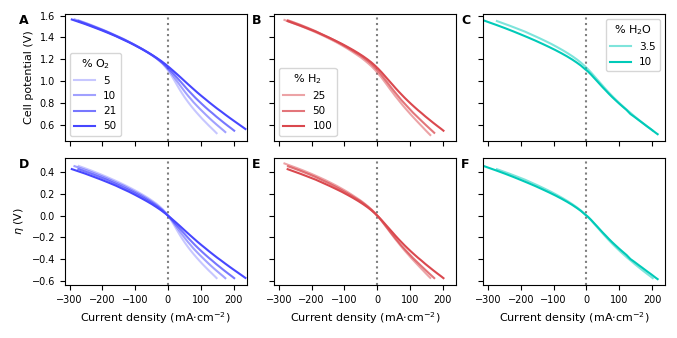

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.5), sharex=True)

gas_axes = {'o2': axes[:, 0], 'h2': axes[:, 1], 'h2o': axes[:, 2]}
axes[0, 0].get_shared_y_axes().join(*axes[0])
axes[1, 0].get_shared_y_axes().join(*axes[1])

gas_colors = {}
alpha2 = 1
for i, gas in enumerate(gas_axes.keys()):
    norm = mpl.colors.LogNorm(vmin=np.min(mrt.obs_psi_df[f'p{gas}']), vmax=np.max(mrt.obs_psi_df[f'p{gas}']))
    if gas == 'o2':
        alpha1 = 0.3
    else:
        alpha1 = 0.5
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        f'p_{gas}', [(*light_colors[i], alpha1), (*light_colors[i], alpha2)]
    )
    gas_colors[gas] = {'cmap': cmap, 'norm': norm}

for group_id in np.unique(mrt.obs_group_id):
    index = mrt.get_group_index(group_id)
    group_df = mrt.obs_psi_df.loc[index]
    po2 = group_df['po2'].values[0]
    ph2 = group_df['ph2'].values[0]
    ph2o = group_df['ph2o'].values[0]
    
    plot_gases = []
    if ph2 == 1 and ph2o == 0.035:
        plot_gases.append('o2')
    
    if po2 == 0.21 and ph2o == 0.035:
        plot_gases.append('h2')
        
    if po2 == 0.21 and ph2 == 1:
        plot_gases.append('h2o')
    
    for gas in plot_gases:
        axcol = gas_axes[gas]
        c_pres = group_df[f'p{gas}'].values[0]
        
        j = group_df['j'].values
        v = group_df['V'].values
        sort_index = np.argsort(j)
        j = j[sort_index]
        v = v[sort_index]
        
        v_oc = np.interp(0, j, v)
        
        c = gas_colors[gas]['cmap'](gas_colors[gas]['norm'](c_pres))
        axcol[0].plot(-1000 * j, v, c=c, label='{:.3g}'.format(round(100 * c_pres, 1)))
        axcol[1].plot(-1000 * j, v - v_oc, c=c, label='{:.3g}'.format(round(100 * c_pres, 1)))
        
gas_labels = ['% O$_2$', '% H$_2$', '% H$_2$O']
for ax, gas_label in zip(axes[0], gas_labels):
    handles, labels = ax.get_legend_handles_labels()
    sort_index = np.argsort([float(l) for l in labels])
    ax.legend(handles=list(np.array(handles)[sort_index]), labels=list(np.array(labels)[sort_index]),
             title=gas_label, fontsize=7.5)
    
for ax in axes[1]:
    ax.set_xlabel('Current density (mA$\cdot \mathrm{cm}^{-2}$)')
    
axes[0, 0].set_ylabel('Cell potential (V)')
axes[1, 0].set_ylabel('$\eta$ (V)')
    
for ax in axes.ravel():
    ax.axvline(0, c='k', ls=':', alpha=0.5, zorder=-10)
    ax.set_xticks(np.arange(-300, 201, 100))
    
axes[0, 0].set_xlim(-315, 240)

for ax in axes[:, 1:].ravel():
    ax.set_yticklabels([])

# axes[0].plot(-1000 * j_tot, v_grid + 1.1)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.15)
loci = [(-0.25, 1)] + [(-0.12, 1)] * 2
ff.add_letters(axes, loc=loci * 2)

ff.savefig(fig, 'Supp_PCEC_PolCurves')

### Illustrate stairstep current pattern for hybrid polarization maps

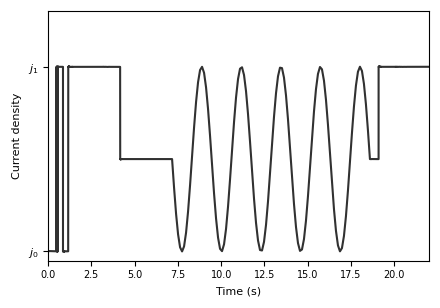

In [55]:
step_id = '27d'
index = mrt.get_group_index(step_id)
eta = mrt.obs_psi_df.loc[index, 'eta'].values
sort_index = np.argsort(eta)
index = index[sort_index]
eta = eta[sort_index]


ocv_index = hybdrt.utils.array.nearest_index(eta, 0)

cp_files = []
for i in range(1):
    cp_file, eis_file = mrt.obs_data[index[ocv_index - i]]
    cp_file2 = cp_file.parent.joinpath(cp_file.name.replace('-a_Filtered', '-b'))
    
    cp_df1 = fl.read_chrono(cp_file)
    cp_df2 = fl.read_chrono(cp_file2)
    
    delta_t = (cp_df2.loc[0, 'timestamp'] - cp_df1['timestamp'].values[-1]).total_seconds()
    
    # Make illustrative EIS df
    eis_times = np.linspace(0, delta_t, 100)
    # Round to nearest ms - required for timedelta
    eis_times_ms = np.round(eis_times, 3)
    i_step = cp_df1['Im'].max() - cp_df1['Im'].min()
    i_mid = cp_df1['Im'].values[-1]
    
    i_eis = i_mid + 0.5 * i_step * np.sin(10 * np.pi * eis_times_ms / delta_t)
    
    x_eis = np.empty((len(eis_times), len(cp_df1.columns)))
    x_eis[:, list(cp_df1.columns).index('Time')] = eis_times
    x_eis[:, list(cp_df1.columns).index('Im')] = i_eis
    
    eis_df = pd.DataFrame(x_eis, columns=list(cp_df1.columns))
    eis_df['timestamp'] = [cp_df1['timestamp'].values[-1] + np.timedelta64(int(1000 * t), 'ms') for t in eis_times_ms]
    
    cp_files += [cp_df1, eis_df, cp_df2]
    

cp_df = fl.concatenate_chrono_data(cp_files)
fig, ax = plt.subplots(figsize=(half_width, half_width * 0.7))

ax.plot(cp_df['elapsed'], -cp_df['Im'], c=data_kw['edgecolors'], alpha=0.9)

ax.set_xlim(0, 22)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current density')

ax.set_yticks([0, i_step])
ax.set_yticklabels(['$j_0$', '$j_1$'], fontsize=8)
ax.set_ylim(0 - 0.05 * i_step, 1.3 * i_step)

fig.tight_layout()
ff.savefig(fig, 'Supp_PCEC_Stairstep', ext='png')

### Illustrate surface refinement and filtering

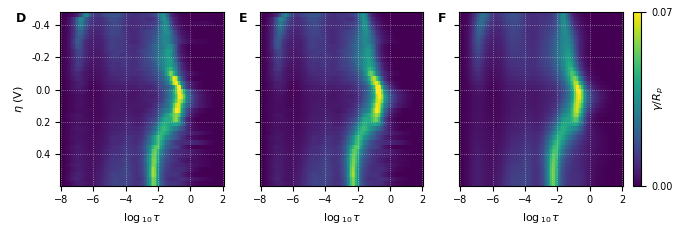

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(full_width, full_width * 0.35), sharex=True, sharey=True)

ijk = (0, 2, 0)

# oc_index = hybdrt.utils.array.nearest_index(v_base, 0)
for i, stage in enumerate(['raw', 'res', 'filt']):
    x = struct_450[f'x_{stage}']
    gamma = mrt.predict_drt(x=x[ijk])
    Rp = np.sum(gamma, axis=-1)
    sm, _ = pcp.plot_x_2d(v_base, gamma / Rp[..., None], mrt, ax=axes[i], 
                          cmap='viridis', vmin=0, vmax=0.07) #, vmin=0, vmax=10)
    
fig.tight_layout()

# add colorbar
fig.subplots_adjust(right=0.92)
bbox = axes[2].get_position()
cax = fig.add_axes([bbox.x1 + 0.015, bbox.y0, 0.012, bbox.height])
cb = fig.colorbar(sm, cax=cax)
cb.set_ticks([0, 0.07])
cb.set_label(r'$\gamma / R_p$', labelpad=-15)

for ax in axes[1:]:
    ax.set_ylabel('')

loci = [(-0.27, 1)] + [(-0.13, 1)] * 2
ff.add_letters(axes, loc=loci, start_index=3)

ff.savefig(fig, 'Supp_PCEC_RefineFilterExample', ext='png')

### Show 2D Surfaces for all conditions

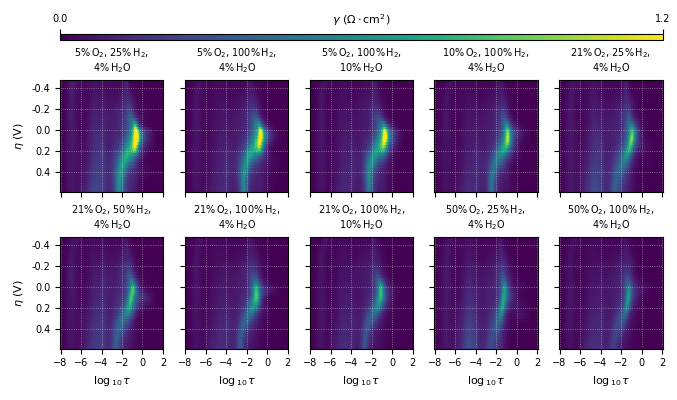

In [67]:
# Absolute DRT magnitude
oc_index = np.where(v_base==0)[0][0]
x = struct_450['x_filt']
fig, axes, sm, cbar = pcp.plot_pres_grid(x * a_cell, struct_450['dim_grids'], mrt, cmap='viridis',
                   normalize=False, cbar_h=True, drt=True, vmin=0, vmax=1.2)

cbar.set_ticks([0, 1.2])
cbar.set_label(r'$\gamma$ ($\Omega \cdot \mathrm{cm}^2$)', labelpad=-20)

ff.savefig(fig, 'Supp_PCEC_DrtSurfaces2d')

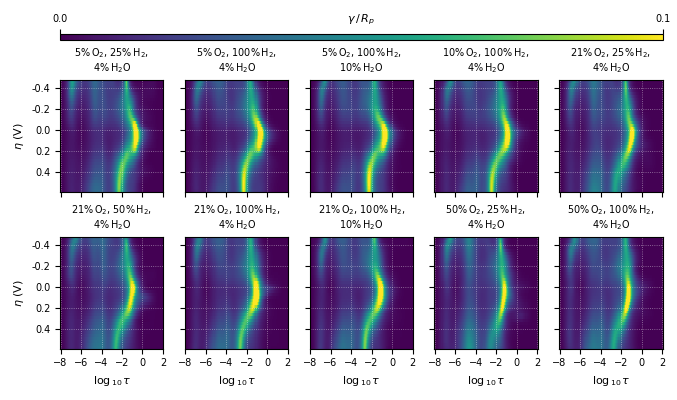

In [68]:
# DRT normalized to Rp
x = struct_450['x_filt']

Rp = np.sum(x, axis = -1)
fig, axes, sm, cbar = pcp.plot_pres_grid(x / Rp[..., None], struct_450['dim_grids'], mrt, cmap='viridis',
                   normalize=False, cbar_h=True, drt=True, vmin=0, vmax=0.1)

cbar.set_ticks([0, 0.1])
cbar.set_label(r'$\gamma \, / \, R_p$', labelpad=-20)

ff.savefig(fig, 'Supp_PCEC_DrtNormSurfaces2d')

In [73]:
norm_tau

(1.5915494309189535e-07, 1.5915494309189535)

In [30]:
struct_450['R_inf_filt'][0]

array([[[2.0215908 , 2.01567604, 2.00687938, 1.99347457, 1.9771652 ,
         1.96238723, 1.95262895, 1.94919529, 1.94789725, 1.94294394,
         1.93291277, 1.92052726, 1.90834809, 1.896393  , 1.88647917,
         1.88494217, 1.88970861, 1.89459832, 1.90091767, 1.90859174,
         1.91538538, 1.91956742, 1.92097716, 1.92173656, 1.92587012,
         1.93573109, 1.94790107, 1.96052818, 1.97880124, 2.00711975,
         2.03556696, 2.04428286, 2.02063793, 1.98177535, 1.96292401,
         1.97536933, 2.00809534, 2.0449255 , 2.0712509 ],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan, 

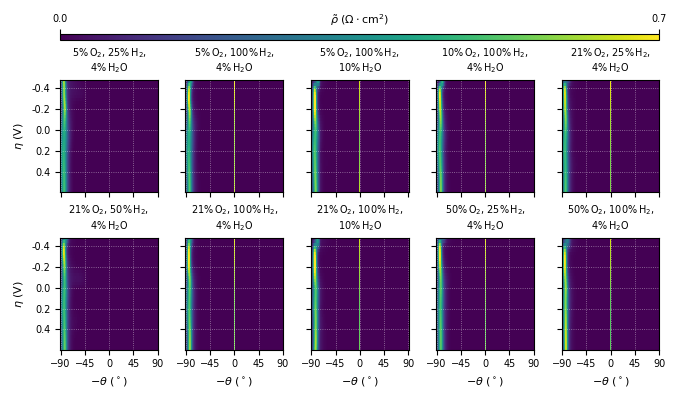

In [48]:
# DOP surface
vmax = 0.7
norm_tau = (3e-8, 1)
fig, axes, sm, cbar = pcp.plot_pres_grid(struct_450['x_dop_filt'] * a_cell, struct_450['dim_grids'],
                                       mrt, cmap='viridis',
                                       cbar_h=True, dop=True, normalize=True, vmin=0, vmax=vmax,
                                       normalize_tau=norm_tau, include_ohmic=True,
                                       x_ohmic=struct_450['R_inf_filt'] * a_cell
                                      )

for ax in axes.ravel():
    ax.set_xticks(np.arange(-90, 90.1, 45))
    
# for ax in axes[1]:
#     ax.set_xlabel('$\theta \ (^\circ)$')

cbar.set_ticks([0, vmax])
cbar.set_label(r'$\tilde{\rho}$ ($\Omega \cdot \mathrm{cm}^2$)', labelpad=-20)

ff.savefig(fig, 'Supp_PCEC_DopSurfaces2d')

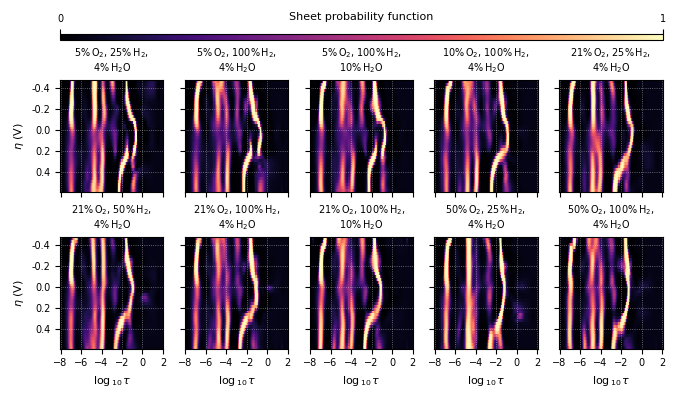

In [49]:
# Sheet prob 
fig, axes, sm, cbar = pcp.plot_pres_grid(struct_450['rp_raw'], struct_450['dim_grids'],
                                       mrt, cmap='magma',
                                       cbar_h=True, vmin=0, vmax=1
                                      )

cbar.set_ticks([0, 1])
cbar.set_label(r'Sheet probability function', labelpad=-20)

ff.savefig(fig, 'Supp_PCEC_SheetProb2d')

## 1d ridge prob example

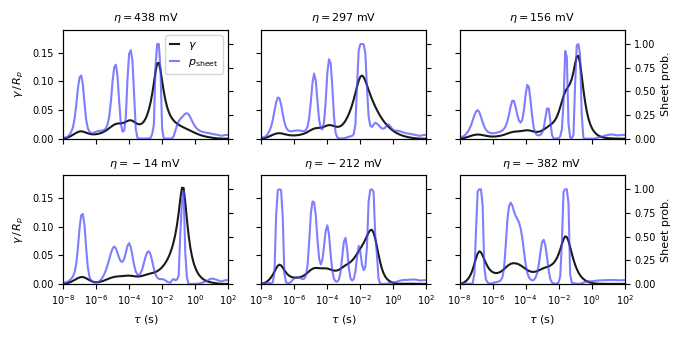

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.5), sharex=True, sharey=True)

ijk = (0, 2, 0)

# Get DRT surface
x = struct_450['x_filt'][ijk]
rp = struct_450['rp_raw'][ijk]
tau_plot = np.logspace(-8, 2, 201)
gamma = mrt.predict_drt(x=x)
Rp = np.sum(gamma, axis=-1) * mrt.tau_basis_area

# Plot 1d DRT and ridge prob
for ii, i in enumerate([5, 10, 15, 22, 29, 35]):
    ax = axes.ravel()[ii]
    ax2 = ax.twinx()
    
    ax.plot(mrt.tau_supergrid, gamma[i] / Rp[i], c=data_kw['edgecolors'], label='$\gamma$')
    ax2.plot(mrt.tau_supergrid, rp[i], c=light_colors[0], alpha=0.7, label='$p_{\mathrm{sheet}}$')
    ax2.set_ylim(0, 1.15)
    ax.set_xscale('log')
    
    # Label eta
    v = v_base[i]
    # Prevent "-0.0" label
    if v == 0:
        sign = 1
    else:
        sign = -1
    ax.set_title(r'$\eta={:.0f}$ mV'.format(sign * 1000 * v), fontsize=8)
    
    if ii % 3 == 2:
        ax2.set_ylabel('Sheet prob.')
    else:
        ax2.set_yticklabels([])
    
for ax in axes[:, 0]:
    ax.set_ylabel('$\gamma \, / \, R_p$')
    
for ax in axes[1]:
    ax.set_xlabel(r'$\tau$ (s)')
    
axes[0, 0].set_xlim(1e-8, 1e2)
axes[0, 0].set_xticks(np.logspace(-8, 2, 6))
axes[0, 0].set_ylim(0, 0.19)

h, l = axes[0, 0].get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
axes[0, 0].legend(handles=h + h2, labels=l + l2, loc='upper right', handlelength=0.8)
    
fig.tight_layout()
ff.savefig(fig, 'Supp_PCEC_SheetProb1dExamples', ext='png')

## Example ZARC deconvolution

In [4303]:
fig.get_size_inches()

array([6.77, 3.38])

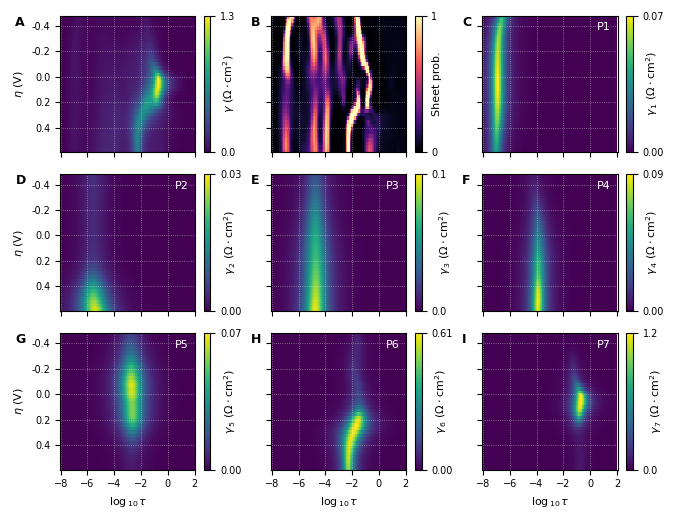

In [51]:
ijk = (0, 2, 0)

# Get DRT surface
x = struct_450['x_filt'][ijk]
rp = struct_450['rp_raw'][ijk]
tau_plot = np.logspace(-8, 2, 201)
gamma = mrt.predict_drt(x=x, tau=tau_plot)
Rp = np.sum(gamma, axis = -1) * mrt.tau_basis_area

# Get GP-ZARC surface
f_rq = hybdrt.models.elements.element_distribution_function('RQ')
rq_dist = np.array([f_rq(t, R_stack, lt_stack, beta_stack) for t in tau_plot])
rq_dist = np.moveaxis(rq_dist, 0, -1)
gamma_rq = np.sum(rq_dist, axis=0)

fig, axes = plt.subplots(3, 3, figsize=(full_width, full_width * 0.77), sharex=True, sharey=True)

plot_kw = dict(
    tau=tau_plot,
    cmap='viridis'
)

# Plot DRT surface
sm, _ = pcp.plot_x_2d(v_base, gamma * a_cell, mrt, ax=axes[0, 0], vmin=0, vmax=1.3, **plot_kw)
cb = fig.colorbar(sm, ax=axes[0, 0])
cb.set_ticks([0, 1.3])
cb.set_label('$\gamma$ ($\Omega \cdot \mathrm{cm}^2$)', labelpad=-10)

sm, _ = pcp.plot_x_2d(v_base, rp, mrt, ax=axes[0, 1], vmin=0, vmax=1, cmap='magma')
cb = fig.colorbar(sm, ax=axes[0, 1])
cb.set_ticks([0, 1])
cb.set_label('Sheet prob.', labelpad=-4)

# Plot individual ZARC distributions
for k in range(rq_dist.shape[0]):
    ax = axes.ravel()[k + 2]
    f_k = rq_dist[k][ijk] * a_cell
    f_max = np.max(f_k)
    # Select number of decimal places for vlimits
    pwr = max(np.floor(np.log10(f_max)), -1)
    ndec = int(1 - pwr)
    vmax = round(f_max, ndec)
    sm, _ = pcp.plot_x_2d(v_base, f_k, mrt, ax=ax, **plot_kw, vmin=0, vmax=vmax)
    cb = fig.colorbar(sm, ax=ax)
    cb.set_ticks([0, vmax])
    
    # If vmax happens to round to a multiple of the base, 
    # we don't need to pad by as much
    div = vmax / (10 ** pwr)
    if abs(div - round(div, 0)) < 1e-4:
        ndec -= 1
    
    cb.set_label(f'$\gamma_{{\,{k + 1}}}$ ($\Omega \cdot \mathrm{{cm}}^2$)', labelpad=-7 + (1 - ndec) * 7)
    
    ax.text(0.95, 0.95, f'P{k + 1}', transform=ax.transAxes, ha='right', va='top', color='white')
    
for ax in axes[:2].ravel():
    ax.set_xlabel('')
for ax in axes[:, 1:].ravel():
    ax.set_ylabel('')
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)

loci = [(-0.33, 1)] + [(-0.15, 1)] * 2
loci *= 3
ff.add_letters(axes, loc=loci)

ff.savefig(fig, 'Supp_PCEC_GPZARC_DeconvExample')

## GP-ZARC validation

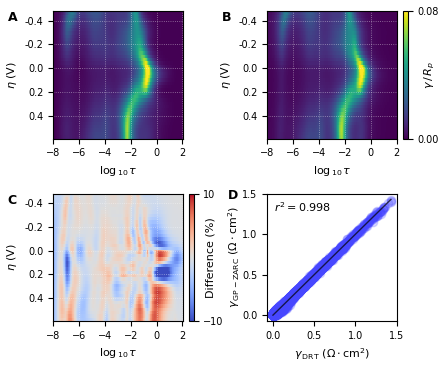

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(half_width, half_width * 0.85))

ijk = (0, 2, 0)

tau_plot = np.logspace(-8, 2, 201)

# Get DRT surface
x = struct_450['x_filt'][ijk]
gamma = mrt.predict_drt(x=x, tau=tau_plot)
gamma_norm = gamma / (np.sum(gamma, axis=-1)[..., None] * mrt.tau_basis_area)

# Get GP-ZARC surface
f_rq = hybdrt.models.elements.element_distribution_function('RQ')
rq_dist = np.array([f_rq(t, R_stack, lt_stack, beta_stack) for t in tau_plot])
rq_dist = np.moveaxis(rq_dist, 0, -1)
gamma_rq = np.sum(rq_dist, axis=0)

gamma_rq_norm = gamma_rq / (np.sum(gamma_rq, axis=-1)[..., None] * mrt.tau_basis_area)

# PLot DRT surfaces
drt_kw = dict(
    tau=tau_plot, cmap='viridis', vmin=0, vmax=0.08
)

sm_drt, _ = pcp.plot_x_2d(v_base, gamma_norm, mrt, ax=axes[0, 0], **drt_kw)

pcp.plot_x_2d(v_base, gamma_rq_norm[ijk], mrt, ax=axes[0, 1], **drt_kw)


# Plot diff
diff = gamma - gamma_rq[ijk]
sm_diff, _ = pcp.plot_x_2d(v_base, 100 * diff / (gamma + np.std(gamma)), mrt, ax=axes[1, 0], tau=tau_plot, 
              vmin=-10, vmax=10)


# Get GP-ZARC surface at 10 ppd for pred vs. actual
f_rq = hybdrt.models.elements.element_distribution_function('RQ')
rq_dist = np.array([f_rq(t, R_stack, lt_stack, beta_stack) for t in mrt.tau_supergrid])
rq_dist = np.moveaxis(rq_dist, 0, -1)
gamma_rq = np.sum(rq_dist, axis=0)

y_drt = mrt.predict_drt(x=struct_450['x_filt']).flatten()
y_rq = gamma_rq.flatten()
nan_index = np.isnan(y_drt)
y_drt = y_drt[~nan_index]
y_rq = y_rq[~nan_index]

axes[1, 1].scatter(y_drt * a_cell, y_rq * a_cell, color=light_colors[0], alpha=0.2)
y_lin = [0, np.max(y_drt * a_cell)]
axes[1, 1].plot(y_lin, y_lin, c='k', lw=1, alpha=0.7)

# Show r2 score
r2 = r2_score(y_drt, y_rq)
axes[1, 1].text(0.05, 0.95, '$r^2={:.3f}$'.format(r2), transform=axes[1, 1].transAxes, ha='left', va='top')
axes[1, 1].set_xlabel('$\gamma_{\, \mathrm{DRT}}$ ($\Omega \cdot \mathrm{cm}^2$)')
axes[1, 1].set_ylabel('$\gamma_{\, \mathrm{GP-ZARC}}$ ($\Omega \cdot \mathrm{cm}^2$)', labelpad=0)

fig.tight_layout()

# Add colorbars
fig.subplots_adjust(left=0.12, right=0.9, wspace=0.65)

# DRT colorbar
cb_width = 0.01
cb_sep = 0.015
caxes = []
for ax in [axes[0, 1], axes[1, 0]]:
    bbox = ax.get_position()
    caxes.append(fig.add_axes([bbox.x1 + cb_sep, bbox.y0, cb_width, bbox.height]))
    
cb_drt = fig.colorbar(sm_drt, cax=caxes[0])
cb_drt.set_ticks([0, 0.08])
cb_drt.set_label(r'$\gamma \, / \, R_p$', labelpad=-12)

cb_diff = fig.colorbar(sm_diff, cax=caxes[1])
cb_diff.set_ticks([-10, 10])
cb_diff.set_label(r'Difference (%)', labelpad=-13)

loci = [(-0.35, 1)] * 3 + [(-0.3, 1.04)]
ff.add_letters(axes, loc=loci)

ff.savefig(fig, 'Supp_PCEC_GPZARC_Validation')

In [4388]:
np.std(gamma)

0.337208216592874

# Draw sheets

In [141]:
X_train

array([[ 5.00000000e-02,  2.50000000e-01,  3.50000000e-02,
        -5.79827561e-01,  8.65488006e+03],
       [ 5.00000000e-02,  2.50000000e-01,  3.50000000e-02,
        -5.51543289e-01,  8.65488006e+03],
       [ 5.00000000e-02,  2.50000000e-01,  3.50000000e-02,
        -5.23259018e-01,  8.65488006e+03],
       ...,
       [ 5.00000000e-01,  1.00000000e+00,  3.50000000e-02,
         4.10121933e-01,  8.40589270e+03],
       [ 5.00000000e-01,  1.00000000e+00,  3.50000000e-02,
         4.38406204e-01,  8.40589270e+03],
       [ 5.00000000e-01,  1.00000000e+00,  3.50000000e-02,
         4.66690476e-01,  8.40589270e+03]])

<IPython.core.display.Javascript object>


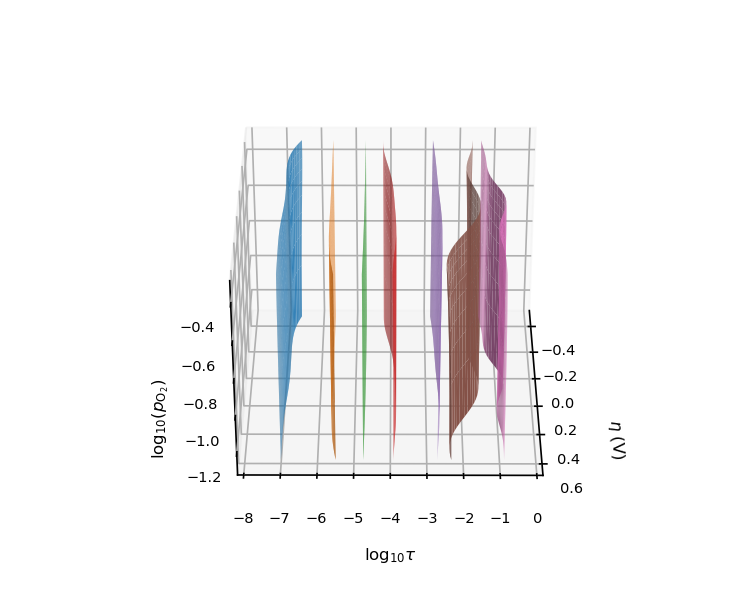

Text(0.5, 0, '$\\log_{10}(p_{\\mathrm{O}_2})$')

In [171]:
fig = plt.figure(figsize=(5, 4))

ax = fig.add_subplot(111, projection='3d')

v_pred = np.arange(-0.6, 0.46, 0.025)

po2_pred = np.linspace(0.05, 0.5, 10)
# ph2_pred = np.linspace(0.25, 1.0, 10)
# ph2o_grid = np.logspace(0.035, 0.1, 10)

pp_pred, vv_pred = np.meshgrid(po2_pred, v_pred)
X_pred = np.empty((len(vv_pred.flatten()), X_train.shape[1]))
X_pred[:, 0] = pp_pred.flatten()
X_pred[:, 1] = 1.0 # ph2
X_pred[:, 2] = 0.035 # ph2o
X_pred[:, 3] = vv_pred.flatten()
X_pred[:, 4] = np.median(X_train[:, 4])  # time

for k in range(len(stan_gps['R'])):
    R_k = stan_gps['R'][k].predict(X_pred)
    lt_k = np.log10(stan_gps['tau'][k].predict(X_pred))
    R_k = R_k.reshape(vv_pred.shape)
    lt_k = lt_k.reshape(vv_pred.shape)
    
    vmax = np.max(R_k)
    vmin = np.min(R_k)
    
    # Map temperatures to colors (no shading)
    c_k = mpl.colors.to_rgb(default_colors[k])
    cmin = c_k + (0.6,)
    cmax = c_k + (1.0,)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(f'R{k}', colors=[cmin, cmax])
    
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    flat_colors = cmap(norm(R_k))

#     # Create custom light source for surface shading
#     light_source = mpl.colors.LightSource()
#     surface_colors = light_source.shade_rgb(flat_colors, gamma, vert_exag=2, fraction=0.45)

    ax.plot_surface(-vv_pred, lt_k, np.log10(pp_pred), facecolors=flat_colors, lw=0, antialiased=True,
                   rcount=100, ccount=100)
    
# # sm = mpl.colors.ScalarMappable(norm=norm, cmap=cmap)
# # cbar = fig.colorbar(sm, label)
ax.view_init(azim=20, elev=30)

ax.set_ylim(-8, 0)

ax.set_xlabel(r'$\eta$ (V)', labelpad=12)
ax.set_ylabel(r'$\log_{10} \tau$')

# soc_ticks = np.arange(50, 101, 10)
# ax.set_xticks(-soc_ticks)
# ax.set_xticklabels(soc_ticks)

# Enable manual label rotation
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('$\log_{10}(p_{\mathrm{O}_2})$', rotation=90)
# ax.zaxis._axinfo['juggled'] = (1,2,2)
# ax.set_zlabel('C rate', rotation=0, labelpad=15)

# fig.tight_layout()
# fig.savefig(postdoc_dir.joinpath('PCEC_Map_Sheets'), transparent=True, dpi=300)

In [145]:
X_pred

array([[ 1.12201845e+00,  1.00000000e+00,  3.50000000e-02,
        -4.24264069e-02,  3.73389427e-33],
       [ 1.12201845e+00,  1.00000000e+00,  3.50000000e-02,
        -4.24264069e-02,  5.05253694e-38],
       [ 1.12201845e+00,  1.00000000e+00,  3.50000000e-02,
        -4.24264069e-02,  1.11004743e-47],
       ...,
       [ 3.16227766e+00,  1.00000000e+00,  3.50000000e-02,
        -4.24264069e-02,  0.00000000e+00],
       [ 3.16227766e+00,  1.00000000e+00,  3.50000000e-02,
        -4.24264069e-02,  0.00000000e+00],
       [ 3.16227766e+00,  1.00000000e+00,  3.50000000e-02,
        -4.24264069e-02,  0.00000000e+00]])

<IPython.core.display.Javascript object>


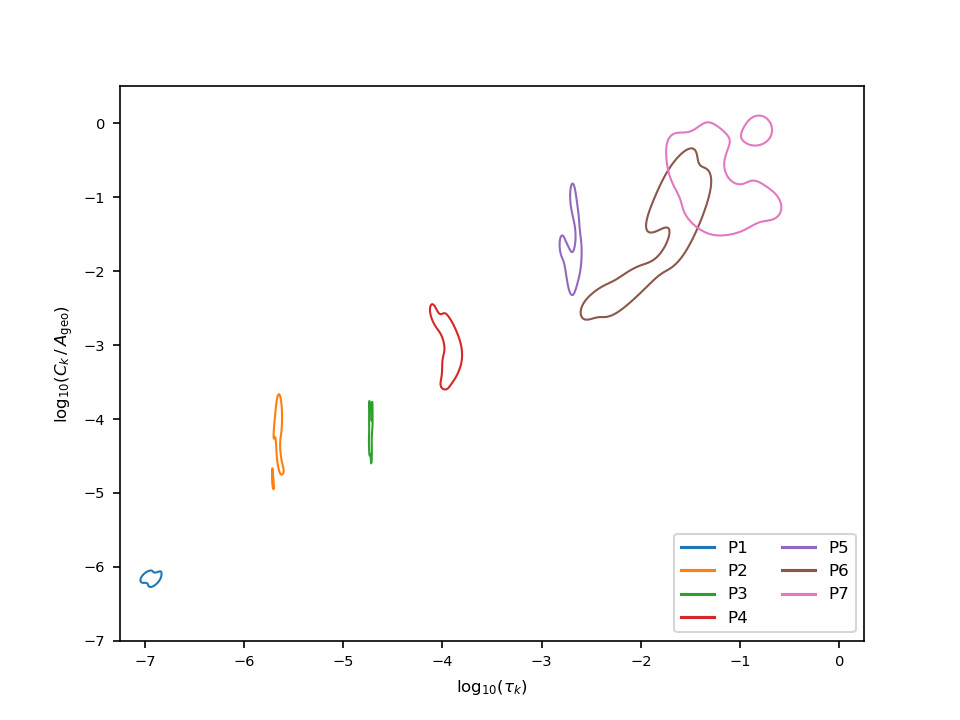

0 -6.159133858657935 6.932121105926694e-07
1 -4.000896582895322 9.979376761035116e-05
2 -4.167749060394482 6.795961997218866e-05
3 -3.0439107470968114 0.0009038485249178495
4 -1.8274140088794197 0.014879426093228131
5 -1.1470907309508402 0.07127109855242494
6 -0.8065368125973009 0.15612168052192402


Text(0, 0.5, '$\\log_{10}(C_k \\, / \\, A_{\\mathrm{geo}})$')

In [592]:
# Larger plot to check values
fig, ax = plt.subplots()
lc10 = np.log10(np.exp(lt_stack) / (a_cell *R_stack))
lt10 = np.log10(np.exp(lt_stack))

for k in range(lt10.shape[0]):
    sn.kdeplot(x=lt10[k][~np.isnan(lt10[k])], y=lc10[k][~np.isnan(lt10[k])], ax=ax, levels=[0.25], linewidths=1)
    # Plot dummy line for legend
    ax.plot([100], [100], label=f'P{k + 1}', c=default_colors[k])
    print(k, np.nanmedian(lc10[k]), np.nanmedian(10 ** lc10[k]))
    
ax.set_xlim(-7.25, 0.25)
ax.set_ylim(-7., 0.5)
ax.legend(ncol=2, loc='lower right')

ax.set_xlabel(r'$\log_{10}(\tau_k)$')
ax.set_ylabel(r'$\log_{10}(C_k \, / \, A_{\mathrm{geo}})$')

In [1722]:
## PDP: limiting processes
# For n different gas conditions, show cumulative losses for each peak as a function of eta

(0.2791053921568627, 0.2791053921568627, 1.0)

<IPython.core.display.Javascript object>


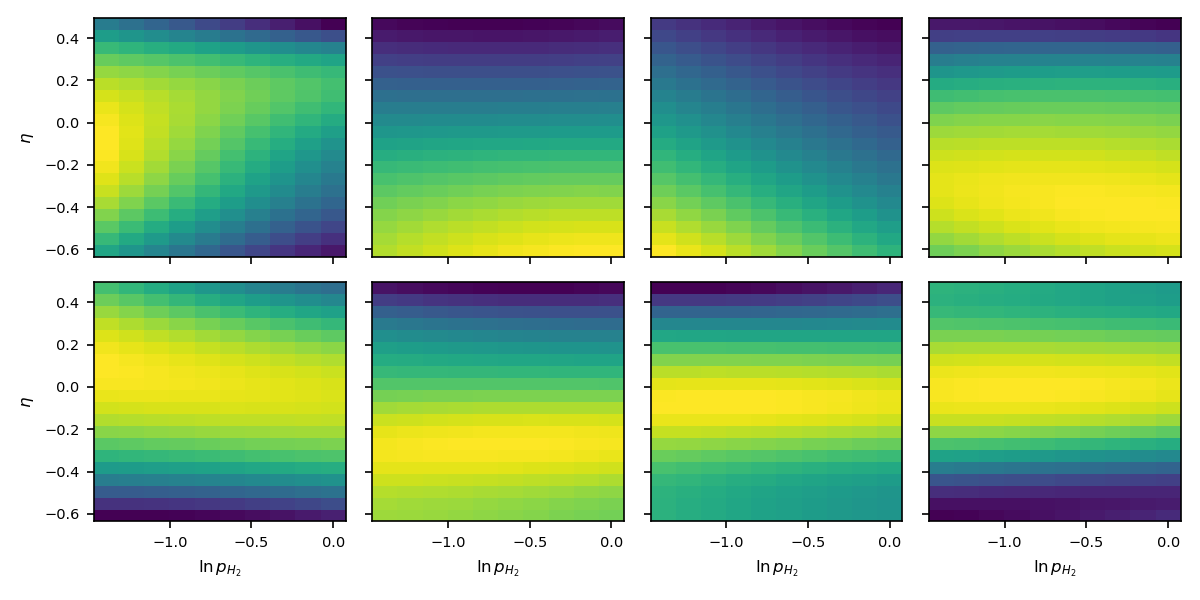

In [1648]:
y_h2 = np.mean(pdp_r['average'], axis=1)

xx, yy = np.meshgrid(pdp_r['values'][1], pdp_r['values'][2])

fig, axes = plt.subplots(2, 4, figsize=(8, 4), sharex=True, sharey=True)

for k in range(y_o2.shape[0]):
    ax = axes.ravel()[k]
    ax.pcolormesh(xx, yy, y_h2[k].T)
    
for ax in axes[1]:
    ax.set_xlabel('$\ln p_{H_2}$')
for ax in axes[:, 0]:
    ax.set_ylabel(r'$\eta$')
    
fig.tight_layout()

# ECR

In [188]:
ecr_path = cell_path.joinpath('run2.5_ecr')
os.listdir(ecr_path)

['25%H2-100%H2',
 '21%O2-5%O2',
 'CHRONOP_Chrono_Pulse_tstep=5s_Iac=0.96mA_pre.DTA',
 'CHRONOP_100%H2_21%O2_Hybrid_pre.DTA',
 'CHRONOP_100%H2_21%O2_HybridPot_tstep=3s_pre_2.DTA',
 'CHRONOP_Chrono_Pulse_tstep=3s_Iac=0.96mA_pre.DTA',
 'OCP_100%H2_21%O2_pre.DTA',
 'OCP_100%H2_21%O2_pre_LF.DTA',
 'CHRONOP_100%H2_21%O2_HybridPot_tstep=5s_pre.DTA',
 'EISPOT_100%H2_21%O2_HybridPot_tstep=3s_pre_2.DTA',
 'EISPOT_100%H2_21%O2_HybridPot_tstep=5s_pre_2.DTA',
 'EISPOT_100%H2_21%O2_pre.DTA',
 'EISGALV_100%H2_21%O2_Hybrid_pre.DTA',
 'EISPOT_100%H2_21%O2_pre_LF.DTA',
 'EISPOT_100%H2_21%O2_HybridPot_tstep=5s_pre.DTA',
 'EISPOT_100%H2_21%O2_HybridPot_tstep=3s_pre.DTA',
 'python_log_230503_0709.txt',
 'conditions_log_230503_0709.csv',
 '100%H2-25%H2',
 'CHRONOP_100%H2_21%O2_HybridPot_tstep=3s_pre.DTA',
 'CHRONOP_100%H2_21%O2_HybridPot_tstep=5s_pre_2.DTA',
 'exp_notes.txt',
 '5%O2-21%O2']

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


<IPython.core.display.Javascript object>


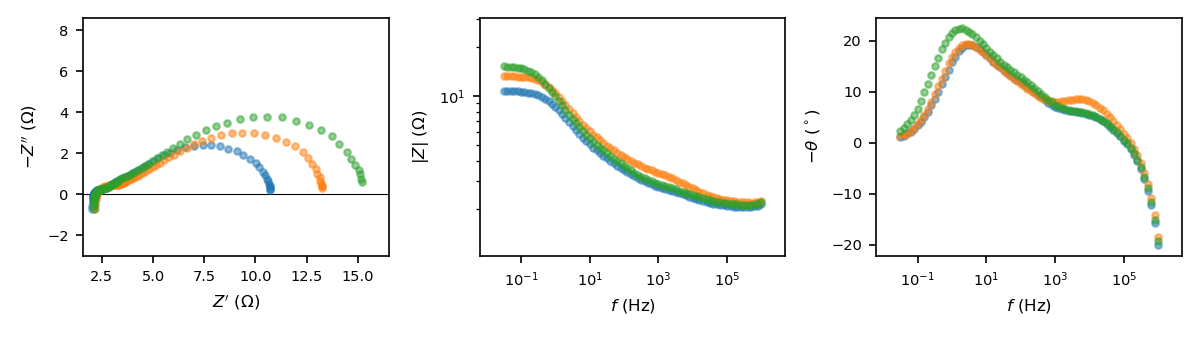

In [189]:
eis_pre_file = ecr_path.joinpath('EISPOT_100%H2_21%O2_pre_LF.DTA')
eis_h2_file = ecr_path.joinpath('100%H2-25%H2/EISPOT_Post_LF.DTA')
eis_o2_file = ecr_path.joinpath('21%O2-5%O2/EISPOT_Post_LF.DTA')

static_files = {
    'std': eis_pre_file,
    'low_h2': eis_h2_file,
    'low_o2': eis_o2_file
}


drt = DRT()
static_fits = {}

fig, axes = plt.subplots(1, 3, figsize=(8, 2.25))

for key, file in static_files.items():
    eis_tup = fl.read_eis(file, return_tuple=True)
    hplt.plot_eis(eis_tup, axes=axes)
    drt.fit_eis(*eis_tup, iw_l2_lambda_0=1e-6)
    static_fits[key] = deepcopy(drt)

In [219]:
10 ** -3.5

0.00031622776601683794

<IPython.core.display.Javascript object>


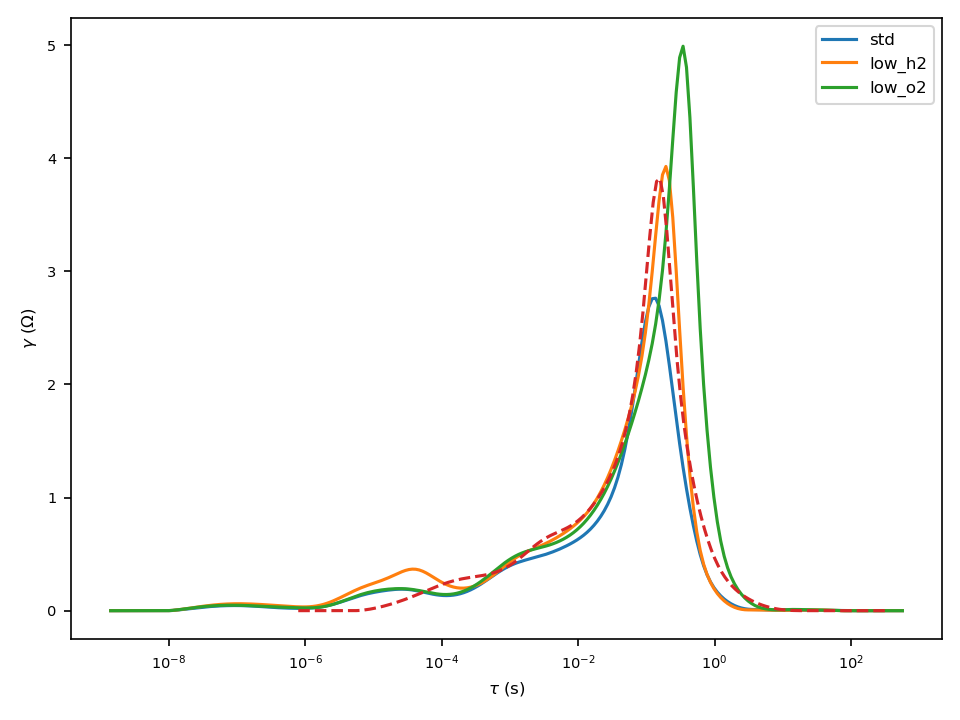

In [218]:
fig, ax = plt.subplots()
for key, fit in static_fits.items():
    fit.plot_distribution(ax=ax, label=key)
    
tmp = mrt_ecr.get_fit(50)
tmp.plot_distribution(ax=ax, ls='--')
    
ax.legend()

In [600]:
mrt_ecr = DRTMD.from_source(fit_path.joinpath('FF3_ECR_WithBkg.pkl'))
# mrt_ecr = deepcopy(mrt)

# mrt_ecr.tau_supergrid = np.logspace(-6, 2, 81)
# mrt_ecr.fit_dop = False
# mrt_ecr.fit_kw['nonneg'] = True
# mrt_ecr.fit_kw['subtract_background'] = True
# mrt_ecr.psi_dim_names = ['time']
# mrt_ecr.clear_obs()

In [192]:
def get_ecr_run(file):
    run = Path(file).name.split('_')[2].replace('.DTA', '')
    return int(run)

In [193]:
# os.listdir(ecr_path)
h2_path = ecr_path.joinpath('100%H2-25%H2')
o2_path = ecr_path.joinpath('21%O2-5%O2')

# mrt_ecr.clear_obs()

ecr_results = {
    'h2': {'step_time': 31, 'step_file_index': 4},
    'o2': {'step_time': 19, 'step_file_index': 2},
}

for group_id, file_path in zip(['h2', 'o2'], [h2_path, o2_path]):
    obs_id_offset = deepcopy(mrt_ecr.num_obs)
    files = list(file_path.glob('CHRONOP_ECR*.DTA'))
    files = sorted(files, key=get_ecr_run)

    df_init = fl.read_chrono(files[0])
    init_timestamp = df_init.loc[0, 'timestamp']
    df_list = []
    for file in files[:90]:
        df = fl.read_chrono(file)
        df_list.append(df)
        timedelta = fl.get_time_offset(df, df_init)
#         mrt_ecr.add_observation([timedelta], file, None, group_id=group_id)
        
    # Ignore the single measurement corrupted by the gas step
#     mrt_ecr.obs_ignore_flag[obs_id_offset + ecr_results[group_id]['step_file_index']] = True

    # Estimate background induced by gas switch
    chrono_seq_df = pccmap.sequence.get_sequence_data(df_list)
    drt_seq = pccmap.sequence.fit_sequence_data(chrono_seq_df, downsample=False, 
                                                step_time=ecr_results[group_id]['step_time'],
                                                bkg_sample_interval=1)
    mrt_ecr.chrono_reader = pccmap.sequence.make_chrono_reader(init_timestamp, drt_seq)
    ecr_results[group_id]['chrono_seq_df'] = chrono_seq_df
    ecr_results[group_id]['drt_seq'] = drt_seq
    ecr_results[group_id]['chrono_reader'] = mrt_ecr.chrono_reader
    
#     mrt_ecr.fit_all()
    

bkg_sample_interval: 1
Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:206: UserWarning: For best results, set solve_rp=True when performing DRT-DOP fits or DRT fits without a non-negativity constraint
  warnings.warn('For best results, set solve_rp=True when performing DRT-DOP fits '
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:979: UserWarning: Solution did not converge within 10 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


linear downsample size: 163


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:979: UserWarning: Solution did not converge within 10 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


bkg_sample_interval: 1
Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready
linear downsample size: 72


C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:206: UserWarning: For best results, set solve_rp=True when performing DRT-DOP fits or DRT fits without a non-negativity constraint
  warnings.warn('For best results, set solve_rp=True when performing DRT-DOP fits '
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:979: UserWarning: Solution did not converge within 10 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')
C:\Users\jdh10\anaconda3\envs\opencv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__length_scale is close to the specified lower bound 2. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:979: UserWarning: Solution

In [194]:
mrt_ecr.num_obs

115

In [191]:
for group_id in np.unique(mrt_ecr.obs_group_id):
    mrt_ecr.resolve_group(group_id, psi_sort_dims=['time'], sigma=0.75, lambda_psi=150)
    
# mrt_ecr.save_attributes('all', fit_path.joinpath('FF3_ECR_WithBkg.pkl'))


Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


In [195]:
def get_ecr_structure(drtmd, group_id, sigma):
    results = {}
    
    index = drtmd.get_group_index(group_id, exclude_flagged=True)
    tau_eval = drtmd.tau_supergrid
    
    # Get DRT coef
    x_drt = drtmd.obs_x_resolved[index]
    
    results['time_grid'] = drtmd.obs_psi[index, drtmd.psi_dim_names.index('time')]
    results['x_raw'] = x_drt

    x_filt = mapping.ndx.filter_ndx(x_drt, num_group_dims=0,
                                    iterative=True, iter=3, nstd=5, dev_rms_size=5,
                                    adaptive=True, impute=False, impute_groups=False,
                                    max_sigma=sigma, k_factor=(4, 2),
                                    presmooth_sigma=None,
                                    mode='nearest'
                                    )
    results['x_filt'] = x_filt
    
    gamma = drtmd.predict_drt(psi=None, x=x_filt, tau=tau_eval)
    results['gamma'] = gamma

    Rp = np.sum(np.abs(x_filt), axis=-1)
    x_norm = x_filt / Rp[..., None]
    results['x_norm'] = x_norm

    # Calculate structure functions
    results.update(pccmap.structure.structure_from_x(x_norm, drtmd, 0, drt_var=None))

    # Get R_inf
    R_inf = drtmd.obs_special_resolved['R_inf'][index]
    results['R_inf'] = R_inf

    R_inf_filt = mapping.ndx.filter_ndx(R_inf, num_group_dims=0,
                                        iterative=True, iter=3, nstd=5, dev_rms_size=5,
                                        adaptive=True, impute=False, impute_groups=False,
                                        max_sigma=(sigma[0],), k_factor=(4,),
                                        presmooth_sigma=None,
                                        mode='nearest'
                                        )

    results['R_inf_filt'] = R_inf_filt
    
    # Find paths
    gamma = drtmd.predict_drt(psi=None, x=x_filt, tau=tau_eval)
    rp = results['rp_raw'].copy()
    
    paths, costs = mapping.path.find_paths_2d(rp, [len(rp) - 1], [0], 
                                          grad_strength=1, grad_sigma=1,
                                          height=0.1, prominence=0.01,
                                          min_prob=0, offset=1, offset_cost=0.2)

    # Highest-freq path not quite resolved for O2 transition - add manually
    if group_id == 'o2':
        first_path = (np.arange(len(rp) - 1, -1, -1), np.ones(len(rp), dtype=int) * 23)
        paths = [first_path] + paths

    # Get path positions from surface mapping
    oc_index = np.where(v_base==0)[0][0]
    if group_id == 'h2':
        lt_k = lt_stack[:, 2, :, 0, oc_index]
    else:
        lt_k = lt_stack[:, :2, 2, 0, oc_index]
        
    map_paths = [(np.arange(len(rp)), 
              np.ones(len(rp), dtype=int) * hybdrt.utils.array.nearest_index(np.log(drtmd.tau_supergrid), np.mean(lt_k[k]))) 
              for k in range(3, 7)]
    
    # Average found paths with surface mapping paths
    p_paths = paths
    paths = []
    for i, path in enumerate(p_paths):
        new_path = 0.5 * (path[1].astype(float) + map_paths[i][1].astype(float))
        new_path = np.round(new_path, 0).astype(int)
        paths.append((path[0], new_path))

    path_mask = mapping.path.paths_to_mask(rp.shape, paths, increment_labels=True, fill_nan=True)

    # integrate
    tau_eval = mrt_ecr.tau_supergrid
    
    ecr_path_dist, ecr_path_sizes = mapping.path.integrate_paths(tau_eval, gamma, paths, troughs=None, widths=8)
#                                                                 weight_multipliers=rp ** 0.5)
    
    # Get path tau
    ecr_path_tau = mapping.path.get_path_tau(tau_eval, paths, rp.shape)
    
    results['paths'] = paths
    results['path_mask'] = path_mask
    results['path_dist'] = ecr_path_dist
    results['path_sizes'] = ecr_path_sizes
    results['path_tau'] = ecr_path_tau

    return results
    

In [196]:
for group_id in list(ecr_results.keys()):
    ecr_results[group_id]['struct'] = get_ecr_structure(mrt_ecr, group_id, sigma=(2, 0.5))

(79, 81)
0 4.0
(79, 81)
1 4.0
(79, 81)
2 4.0
(79, 81)
3 4.0
(34, 81)
0 4.0
(34, 81)
1 4.0
(34, 81)
2 4.0
(34, 81)
3 4.0


<IPython.core.display.Javascript object>


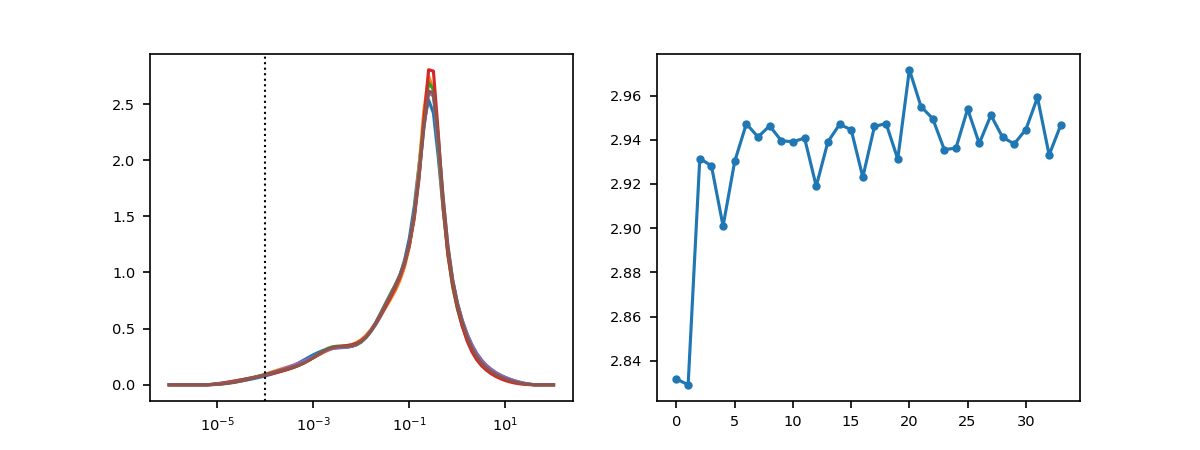

In [244]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
key = 'o2'
index = mrt_ecr.get_group_index(key, exclude_flagged=True)
for i in range(4, 10):
    axes[0].plot(mrt_ecr.tau_supergrid, mrt_ecr.obs_x_resolved[index[i]])
    
axes[0].set_xscale('log')
axes[0].axvline(1e-4, ls=':', c='k', lw=1)

x_drt = ecr_results[key]['struct']['x_raw']
r_inf = ecr_results[key]['struct']['R_inf']
t_grid = ecr_results[key]['struct']['time_grid']
t_step = ecr_results[key]['step_time']

gamma = mrt_ecr.predict_drt(x=x_drt)

r_p = np.trapz(gamma, x=np.log(mrt_ecr.tau_supergrid), axis=-1)
r_tot = r_inf + r_p
r_hf = r_inf + np.trapz(gamma[..., mrt_ecr.tau_supergrid <= tau_split], 
                        x=np.log(mrt_ecr.tau_supergrid[mrt_ecr.tau_supergrid <= tau_split]), axis=-1)
r_lf = np.trapz(gamma[..., mrt_ecr.tau_supergrid > tau_split], 
                        x=np.log(mrt_ecr.tau_supergrid[mrt_ecr.tau_supergrid > tau_split]), axis=-1)

axes[1].plot(r_hf, marker='.')

C:\Users\jdh10\AppData\Local\Temp\ipykernel_17284\2089418219.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(3, 2))


<IPython.core.display.Javascript object>


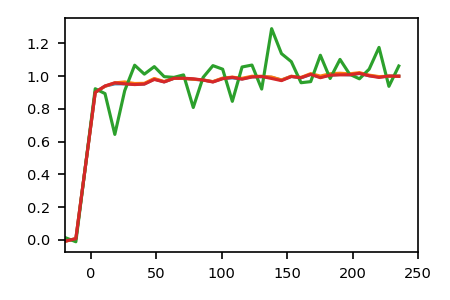

In [232]:
key = 'o2'
tau_split = 10 ** -3.5
x_drt = ecr_results[key]['struct']['x_raw']
r_inf = ecr_results[key]['struct']['R_inf']
t_grid = ecr_results[key]['struct']['time_grid']
t_step = ecr_results[key]['step_time']

gamma = mrt_ecr.predict_drt(x=x_drt)

r_p = np.trapz(gamma, x=np.log(mrt_ecr.tau_supergrid), axis=-1)
r_tot = r_inf + r_p
r_hf = r_inf + np.trapz(gamma[..., mrt_ecr.tau_supergrid <= tau_split], 
                        x=np.log(mrt_ecr.tau_supergrid[mrt_ecr.tau_supergrid <= tau_split]), axis=-1)
r_lf = np.trapz(gamma[..., mrt_ecr.tau_supergrid > tau_split], 
                        x=np.log(mrt_ecr.tau_supergrid[mrt_ecr.tau_supergrid > tau_split]), axis=-1)

# fig, axes = plt.subplots(1, 4, figsize=(8, 2), sharex=True)
fig, ax = plt.subplots(figsize=(3, 2))

for i, r in enumerate([r_tot, r_p, r_hf, r_lf]):
#     ax = axes[i]
    td = t_grid - t_step
    r_end = np.mean(r[(td >= 225) & (td <= 250)])
    ax.plot(t_grid - t_step, get_eq_frac(r, t_grid, t_step, y1=r_end))
    ax.set_xlim(-20, 250)
    
fig.tight_layout()

<IPython.core.display.Javascript object>


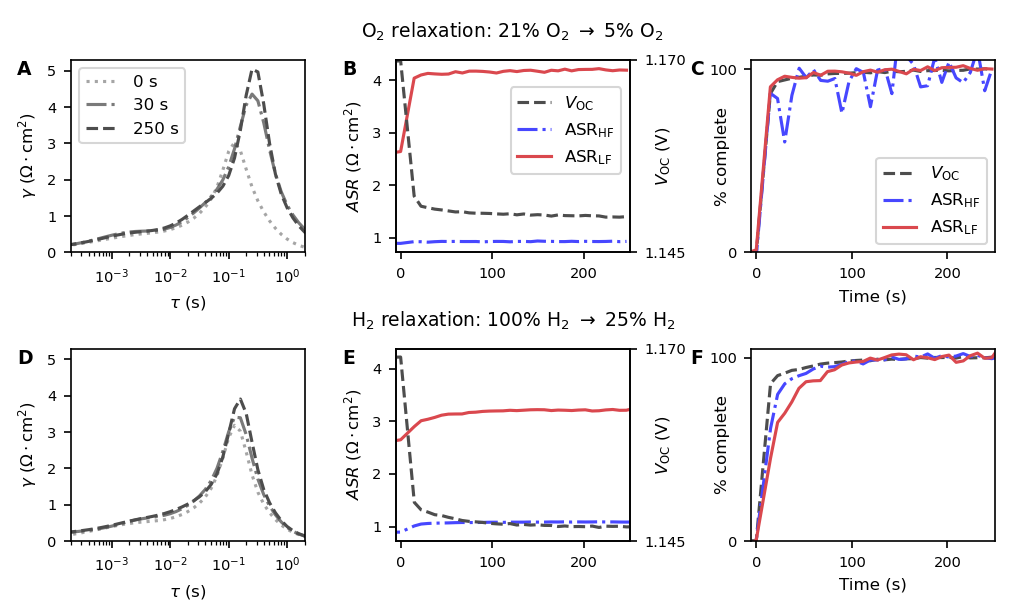

In [283]:
# fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.6), sharey=False)
fig = plt.figure(figsize=(full_width, full_width * 0.6))
gs_kw = dict(top=0.9, hspace=0.5)
gs0 = fig.add_gridspec(2, 1, left=0.07, right=0.3, **gs_kw)
gs1 = fig.add_gridspec(2, 1, left=0.39, right=0.62, **gs_kw)
gs2 = fig.add_gridspec(2, 1, left=0.74, right=0.98, **gs_kw)

axcols = [gs.subplots() for gs in [gs0, gs1, gs2]]
axes = np.array(axcols).T


def get_eq_frac(y, t, t_step, y1=None):
    y0 = np.median(y[t < t_step])
    if y1 is None:
        y1 = np.median(y[-10:])
    return (y - y0) / (y1 - y0)


axes[0, 0].get_shared_y_axes().join(*axes[:, 0])
axes[0, 1].get_shared_y_axes().join(*axes[:, 1])
axes[0, 1].get_shared_x_axes().join(*axes[:, 1:].ravel())

tau_split = 10 ** -3.5

tau_plot = mrt_ecr.tau_supergrid
for i, key in enumerate(['o2', 'h2']):
    res = ecr_results[key]
    
    # Get lumped resistances
    x_drt = res['struct']['x_raw']
    R_inf = res['struct']['R_inf']
    R_p = np.sum(x_drt, axis=-1) * mrt_ecr.tau_basis_area
    
    # Evaluate DRT for integration
    gamma = mrt_ecr.predict_drt(x=x_drt)
    
    R_tot = R_inf + R_p
    R_hf = R_inf + np.trapz(gamma[..., mrt_ecr.tau_supergrid <= tau_split], 
                            x=np.log(mrt_ecr.tau_supergrid[mrt_ecr.tau_supergrid <= tau_split]), axis=-1)
    R_lf = np.trapz(gamma[..., mrt_ecr.tau_supergrid > tau_split], 
                            x=np.log(mrt_ecr.tau_supergrid[mrt_ecr.tau_supergrid > tau_split]), axis=-1)
    
    
    t_grid = res['struct']['time_grid']
    
    start_index = res['step_file_index'] - 1    
    #     t_step = res['step_time']
    t_step = t_grid[start_index]
    t_plot = t_grid - t_step
    # DRT vs. time
    j_arr = np.array([0, 3, 32])
#     j_arr = np.arange(0, 10, 2)
    for n, (j, ls) in enumerate(zip(j_arr, [':', '-.', '--', '-'])):
        alpha = 0.5 + 0.5 * n / (len(j_arr) - 1)
        axes[i, 0].plot(tau_plot, gamma[start_index + j], c=(0.3, 0.3, 0.3), alpha=alpha, ls=ls,
                       label='{:.0f} s'.format(round(t_plot[start_index + j], -1)))

            
    v_oc = res['drt_seq'].predict_response(t_grid, subtract_background=False)
    quants = {
            '$V_{\mathrm{OC}}$': (v_oc, {'ls': '--', 'c': (0.3, 0.3, 0.3)}),
            '$\mathrm{ASR}_{\mathrm{HF}}$': (a_cell * R_hf, {'ls': '-.', 'c': light_colors[0]}),
            '$\mathrm{ASR}_{\mathrm{LF}}$': (a_cell * R_lf, {'c': light_colors[1]})
    }

#     quants['P6+P7'] = (np.sum(R_k[2:], axis=0), {'c': 'brown'})
        
#     quants['$R_{\mathrm{HF}}$'] = (R_HF, {'c': 'magenta', 'ls': '-.'})

    v_ax = axes[i, 1].twinx()

    for label, quant in quants.items():
        y_end = np.median(quant[0][(t_plot >= 225) & (t_plot <= 250)])
        
        # Raw values
        if label == '$V_{\mathrm{OC}}$':
            raw_ax = v_ax
            v_ax.set_ylabel(label+ ' (V)')
        else:
            raw_ax = axes[i, 1]
        raw_ax.plot(t_plot, quant[0], label=label, **quant[1])
        
        # Equil fracion
        f_eq = get_eq_frac(quant[0], t_grid, t_step, y1=y_end)
        axes[i, 2].plot(t_plot, 100 * f_eq, label=label, **quant[1])

    for ax in axes[i, 1:]:
        ax.set_xlim(0, t_plot[-1])
        
    v_ax.set_ylim(1.145, 1.17)
    v_ax.set_yticks([1.145, 1.17])
    v_ax.set_ylabel(v_ax.get_ylabel(), labelpad=-15)
            
        
axes[0, 0].legend()

h1, l1 = axes[0, 1].get_legend_handles_labels()
h2, l2 = v_ax.get_legend_handles_labels()
axes[0, 1].legend(handles=h2 + h1, labels=l2 + l1, loc='upper right', bbox_to_anchor=(1, 0.9))

axes[0, 2].legend()

    

for ax in axes[:, 0]:
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau$ (s)')
    ax.set_xlim(2e-4, 2e0)
    ax.set_ylim(0, 5.3)
    
for ax in axes[:, 0]:
    ax.set_ylabel(r'$\gamma$ ($\Omega \cdot \mathrm{cm}^2$)')
    
for ax in axes[:, 1]:
    ax.set_ylabel(r'$ASR$ ($\Omega \cdot \mathrm{cm}^2$)')
    
for ax in axes[:, 2]:
    ax.set_xlim(-5, 250)
    ax.set_ylim(0, 105)
    ax.set_yticks([0, 100])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('% complete', labelpad=-10)
    
axes[0, 1].set_title(r'O$_2$ relaxation: 21% O$_2$ $\rightarrow$ 5% O$_2$', y=1.05, fontsize=9)
axes[1, 1].set_title(r'H$_2$ relaxation: 100% H$_2$ $\rightarrow$ 25% H$_2$', y=1.05, fontsize=9)

    
# fig.tight_layout()
# fig.subplots_adjust(hspace=0.6)

ff.add_letters(axes[0, :2], loc=(-0.23, 1))
ff.add_letters(axes[0, 2:], start_index=2, loc=(-0.25, 1))
ff.add_letters(axes[1, :2], start_index=3, loc=(-0.23, 1))
ff.add_letters(axes[1, 2:], start_index=5, loc=(-0.25, 1))

ff.savefig(fig, 'PCEC_relaxation')

## GP-ZARC ECR deconvolution (OBSOLETE)

Too hard to separate processes at OCV - this creates some misleading results

<IPython.core.display.Javascript object>


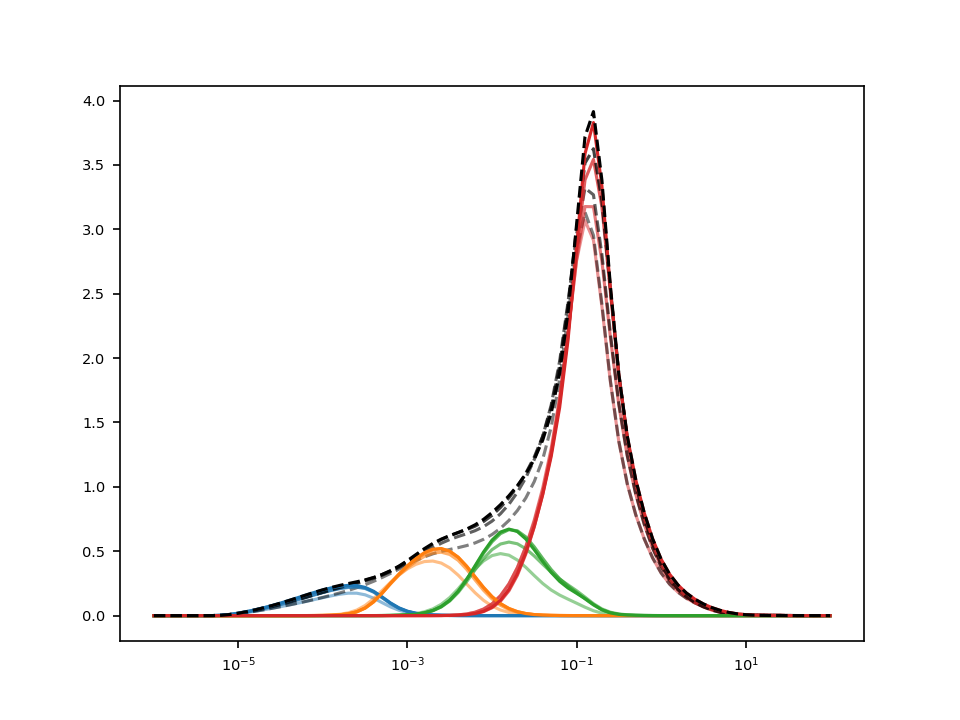

In [697]:
fig, ax = plt.subplots()

key = 'h2'
tau_eval = mrt_ecr.tau_supergrid
ecr_path_dist = ecr_results[key]['struct']['path_dist']
gamma = ecr_results[key]['struct']['gamma']

for i in [0, 5, 10, 20]:
    for k in range(4):
        c = default_colors[k]
        ax.plot(tau_eval, ecr_path_dist[k, i], c=c, alpha=0.5 + 0.5 * (i / 20))
    ax.plot(tau_eval, gamma[i], alpha=0.5 + 0.5 * (i / 20), c='k', ls='--')
        
        
ax.set_xscale('log')

<IPython.core.display.Javascript object>


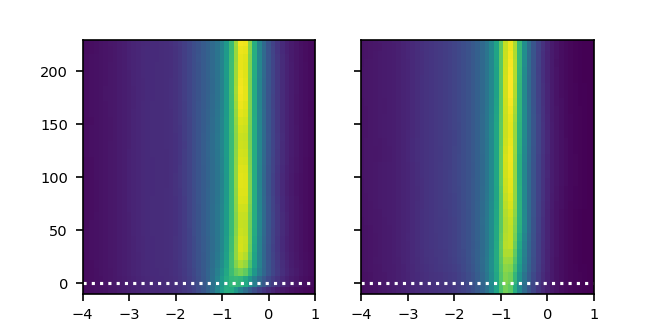

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(half_width, half_width * 0.5), sharex=True, sharey=True)

for i, key in enumerate(['o2', 'h2']):
    x = ecr_results[key]['struct']['x_filt'].copy()
    tau_eval = mrt_ecr.tau_supergrid
    gamma = mrt_ecr.predict_drt(psi=None, x=x, tau=tau_eval)
    rp = ecr_results[key]['struct']['rp_raw'].copy()
    tp = ecr_results[key]['struct']['tp_raw'].copy()
    t_step = ecr_results[key]['step_time']
    # rp = ndimage.gaussian_filter(rp, sigma=(1, 0.5))

    times = ecr_results[key]['struct']['time_grid']
    lt = np.log10(tau_eval)
    ll, tt = np.meshgrid(lt, times - t_step)

    axes[i].pcolormesh(ll, tt, gamma)
    axes[i].axhline(0, ls=':', c='white')
    axes[i].set_xlim(-4, 1)
    axes[i].set_ylim(-10, 230)
    
    
    
# axes[1].plot(lt, gamma[-1], ls='--')

<IPython.core.display.Javascript object>


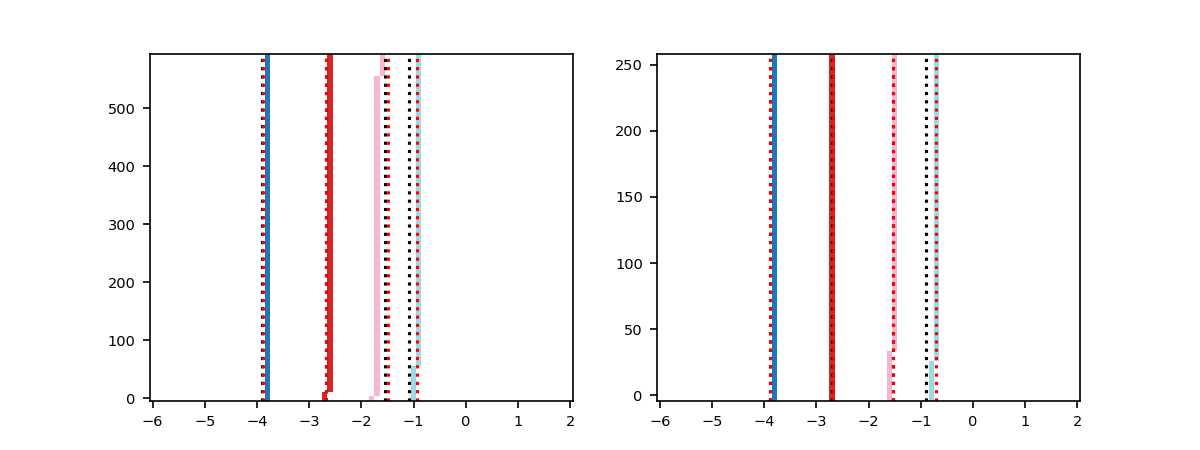

In [699]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))




lt_stack[:, :2, 2, 0] # o2
lt_stack[:, 2, :, 0] # h2

for i, group_id in enumerate(ecr_results.keys()):
    times = ecr_results[group_id]['struct']['time_grid']
    lt = np.log10(tau_eval)
    ll, tt = np.meshgrid(lt, times)
    axes[i].pcolormesh(ll, tt, ecr_results[group_id]['struct']['path_mask'], cmap='tab20')
    
for k in range(3, 7):
    lt_k_h2 = np.log10(np.exp(lt_stack[k, 2, :, 0, oc_index]))
    axes[0].axvline(np.min(lt_k_h2), c='k', ls=':')
    axes[0].axvline(np.max(lt_k_h2), c='r', ls=':')
    
    lt_k_o2 = np.log10(np.exp(lt_stack[k, :2, 2, 0, oc_index]))
    axes[1].axvline(np.min(lt_k_o2), c='k', ls=':')
    axes[1].axvline(np.max(lt_k_o2), c='r', ls=':')

0 4.0
1 4.0
2 4.0
3 4.0


<IPython.core.display.Javascript object>


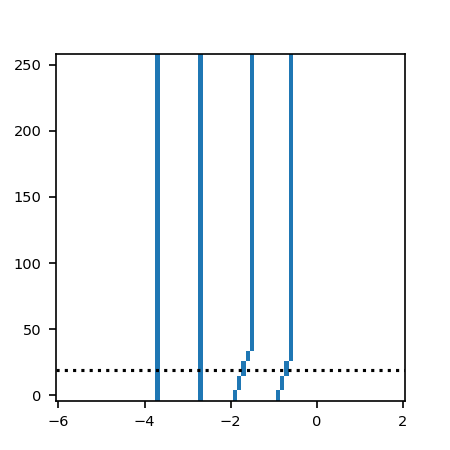

In [2482]:
# paths, costs = mapping.path.find_paths_2d(rp, [len(rp) - 1], [0], 
#                                           grad_strength=1, grad_sigma=1,
#                                           height=0.1, prominence=0.01,
#                                           min_prob=0, offset=1, offset_cost=0.2)

# # Highest-freq path not quite resolved for O2 transition - add manually
# if key == 'o2':
#     first_path = (np.arange(len(rp) - 1, -1, -1), np.ones(len(rp), dtype=int) * 23)
#     paths = [first_path] + paths

# path_mask = mapping.path.paths_to_mask(rp.shape, paths, fill_nan=True)

# # Find troughs
# tpf = ndimage.gaussian_filter(tp, sigma=(1, 0))
# trough_mask = mapping.surface.find_ridges(tpf, 0)

# troughs = []
# for path in paths:
#     troughs.append(mapping.path.find_bounding_troughs(trough_mask, path, tidy=True))

# # integrate
# tau_eval = mrt_ecr.tau_supergrid
# f = mrt_ecr.predict_drt(psi=None, x=x, tau=tau_eval)
# ecr_path_dist, ecr_path_sizes = mapping.path.integrate_paths(tau_eval, f, paths, troughs=None, widths=8)

# fig, ax = plt.subplots(figsize=(3, 3))
# ax.pcolormesh(ll, tt, path_mask, cmap='tab20')
# ax.axhline(t_step, ls=':', c='k')

In [2481]:
first_path

(array([33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17,
        16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1]),
 array([23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23]))

<IPython.core.display.Javascript object>


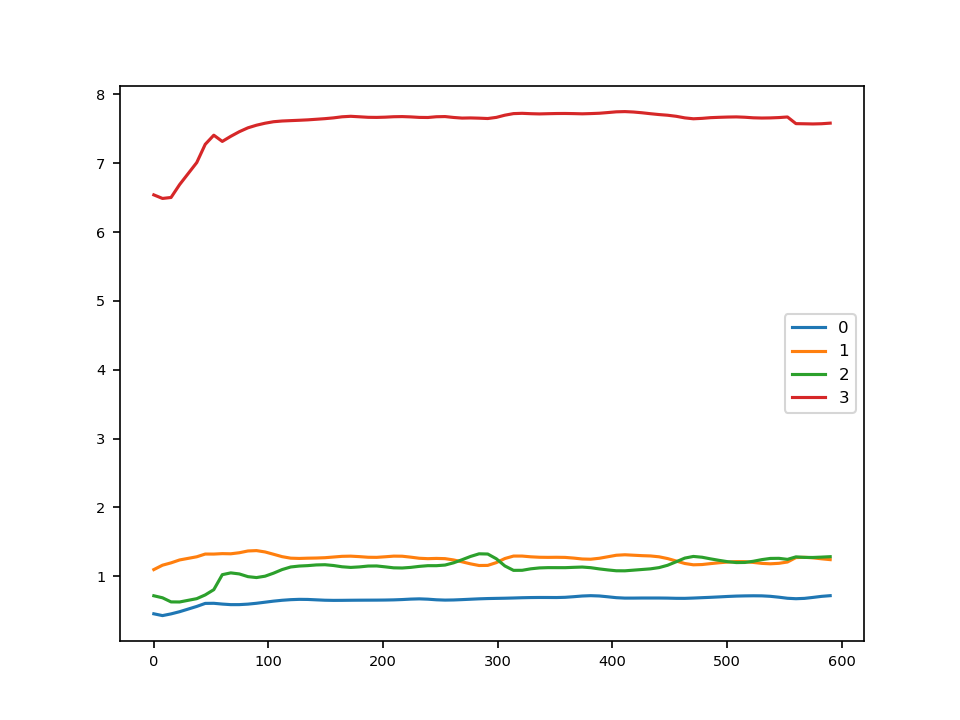

In [2604]:
fig, ax = plt.subplots()

key = 'h2'
times = ecr_results[key]['struct']['time_grid']
for k in range(ecr_path_sizes.shape[0]):
    y_k = ecr_results[key]['struct']['path_sizes'][k]
    y0 = np.median(y_k[times < 31])
    y1 = np.median(y_k[times > 550])
#     ax.plot(times, (y_k - y0) / (y1 - y0), label=k)
    ax.plot(times, y_k, label=k)
    
ax.legend()

In [201]:
# ln(R) stan model

for group_id, res in ecr_results.items():

    # Get surface and scale    
    y = res['struct']['gamma'].copy()
    R_scale_factor = 1 / np.nanstd(y)
    y = y * R_scale_factor

    # Reshape inputs
    ps_i = res['struct']['path_sizes'].copy()
    K = len(ps_i)
    pt_i = res['struct']['path_tau'].copy()
#     y = y.reshape((np.prod(y.shape[:-1]), y.shape[-1]))
    ps_i = ps_i * R_scale_factor
    ps_i = ndimage.gaussian_filter1d(ps_i, sigma=2, axis=-1)
    ps_i = ps_i.reshape((ps_i.shape[0], np.prod(ps_i.shape[1:])))

    # pt_i = ndimage.gaussian_filter1d(path_tau, sigma=5, axis=-1)
    pt_i = pt_i.reshape((ps_i.shape[0], np.prod(ps_i.shape[1:])))

    # Make data matrix
    # Log-scaled time since step
    t_grid = res['struct']['time_grid'].copy()
    t_trans = np.log((t_grid - res['step_time']))
    t_trans[t_grid <= res['step_time']] = -10
    t_trans = np.maximum(t_trans, -5)
    
    X = t_trans[:, None]
    X /= np.nanstd(X, axis=0)

    # Prevent log(0)
    lnr = np.log(np.abs(ps_i) + 1e-4)

    stan_data = {
        'N': len(X),
        'D': X.shape[1],
        'M': len(mrt_ecr.tau_supergrid),
        'K': K,
        'tau': mrt_ecr.tau_supergrid,
        'x': X,
        'y': y,
        'sigma_gp_scale': 0.05,
        'sigma_rel_y_scale': 0.001,
        'sigma_rel_Rp_scale': 1,
        'R_sign': np.sign(np.median(ps_i, axis=1))
    }

    # ZARC
    inits = {
        'lnR_mu': np.median(lnr, axis=1),
        'lntau_mu': np.median(np.log(pt_i), axis=1),
        'beta_trans_mu': np.ones(ps_i.shape[0]),
        'lnR_scale': 2 * np.std(lnr, axis=1),
        'lntau_scale': 5 * np.std(np.log(pt_i), axis=1) + 1e-1,
        'beta_trans_scale': 0.5 * np.ones(ps_i.shape[0]),
#         'lnR_scale': 5 * np.std(lnr, axis=1),
#         'lntau_scale': 5 * np.std(np.log(pt_i), axis=1) + 1e0,
#         'beta_trans_scale': 0.5 * np.ones(ps_i.shape[0]),
        'sigma_rel_y_raw': 1,
        'sigma_rel_Rp_raw': 1,
        'rho': np.ones((K, X.shape[1])) * 5,
#         'rho': np.ones(K) * 10,
        'alpha': np.ones(K),
        'sigma': np.ones(K)
    }

    # inits['rho'][5:7] = 10

    # Place floor on mean resistance
    inits['lnR_mu'] = np.maximum(inits['lnR_mu'], -3)

    rng = np.random.default_rng(34232)

    inits['lnR_raw'] = (lnr - inits['lnR_mu'][:, None]) / inits['lnR_scale'][:, None]
#     inits['lnR_raw'] = np.zeros(ps_i.shape) #+ rng.normal(0, 0.05, size=pt_i.shape)
#     inits['lntau_raw'] = (np.log(pt_i) - inits['lntau_mu'][:, None]) / inits['lntau_scale'][:, None]
    inits['lntau_raw'] = np.zeros(pt_i.shape) + rng.normal(0, 0.05, size=pt_i.shape)
    inits['beta_trans_raw'] = np.zeros(ps_i.shape)


    start_time = time.time()
    stan_mle = model.optimize(stan_data, iter=100, seed=24825, inits=inits, algorithm='lbfgs', init_alpha=1e-5)
    elapsed = time.time() - start_time
    print('Fit time: {:.1f} s'.format(elapsed))
    print('Converged:', stan_mle.converged)
    stan_var = stan_mle.stan_variables()
    ecr_results[group_id]['stan'] = {
        'mle': stan_mle, 
        'var': stan_var,
        'R_scale': R_scale_factor,
        'R_stack': np.exp(stan_var['lnR']) / R_scale_factor,
        'lt_stack': stan_var['lntau'],
        'beta_stack': stan_var['beta']
    }
    
    f_rq = hybdrt.models.elements.element_distribution_function('RQ')
    rq_dist = np.array([f_rq(
        t, 
        ecr_results[group_id]['stan']['R_stack'], 
        ecr_results[group_id]['stan']['lt_stack'], 
        ecr_results[group_id]['stan']['beta_stack']
    ) for t in mrt_ecr.tau_supergrid])
    ecr_results[group_id]['stan']['rq_dist'] = np.moveaxis(rq_dist, 0, -1)


C:\Users\jdh10\AppData\Local\Temp\ipykernel_17284\2632226978.py:25: RuntimeWarning: invalid value encountered in log
  t_trans = np.log((t_grid - res['step_time']))
12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:52 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 5.9 s
Converged: True


12:00:53 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing


Fit time: 1.9 s
Converged: True


<IPython.core.display.Javascript object>


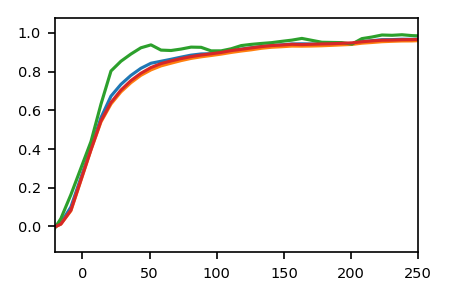

In [206]:
key = 'h2'

def get_eq_frac(y, t, t_step, y1=None):
    y0 = np.median(y[t < t_step])
    if y1 is None:
        y1 = np.median(y[-10:])
    return (y - y0) / (y1 - y0)


tau_split = 10 ** -3.5
r_inf = ecr_results[key]['struct']['R_inf']
t_grid = ecr_results[key]['struct']['time_grid']
t_step = ecr_results[key]['step_time']

gamma = ecr_results[key]['stan']['var']['y_hat']

r_p = np.trapz(gamma, x=np.log(mrt_ecr.tau_supergrid), axis=-1)
r_tot = r_inf + r_p
r_hf = r_inf + np.trapz(gamma[..., mrt_ecr.tau_supergrid <= tau_split], 
                        x=np.log(mrt_ecr.tau_supergrid[mrt_ecr.tau_supergrid <= tau_split]), axis=-1)
r_lf = np.trapz(gamma[..., mrt_ecr.tau_supergrid > tau_split], 
                        x=np.log(mrt_ecr.tau_supergrid[mrt_ecr.tau_supergrid > tau_split]), axis=-1)

# fig, axes = plt.subplots(1, 4, figsize=(8, 2), sharex=True)
fig, ax = plt.subplots(figsize=(3, 2))

for i, r in enumerate([r_tot, r_p, r_hf, r_lf]):
#     ax = axes[i]
    ax.plot(t_grid - t_step, get_eq_frac(r, t_grid, t_step))
    ax.set_xlim(-20, 250)
    
fig.tight_layout()

<IPython.core.display.Javascript object>


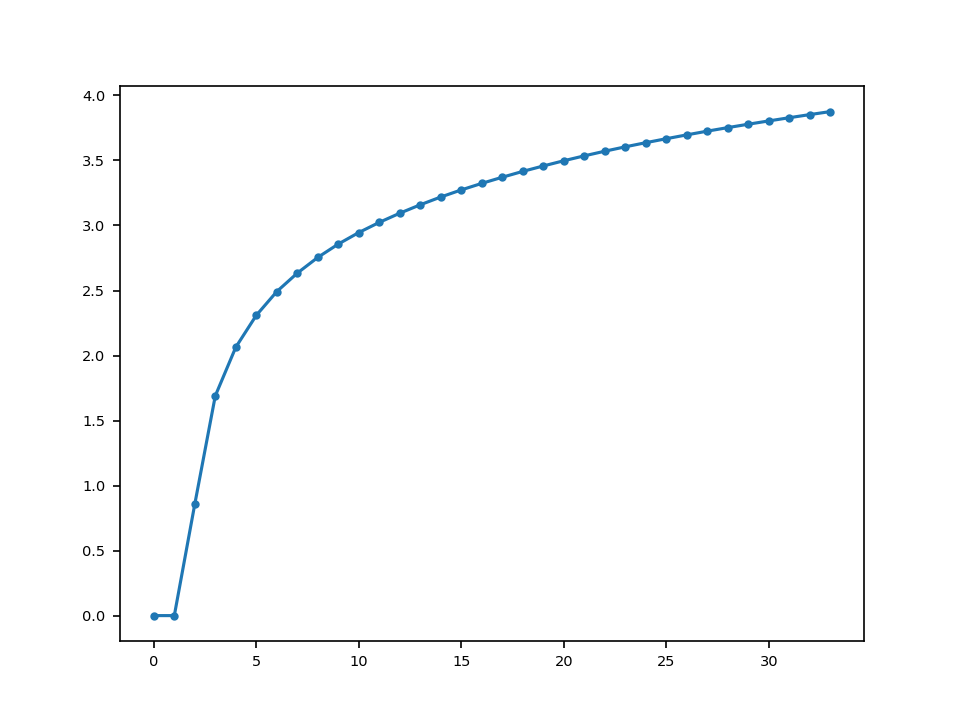

C:\Users\jdh10\AppData\Local\Temp\ipykernel_7288\2525675034.py:3: RuntimeWarning: invalid value encountered in log
  np.log(t_grid - res['step_time'])


array([       nan,        nan, 1.20918211, 2.38127843, 2.90789936,
       3.25329252, 3.51054258, 3.71034073, 3.88066073, 4.02528106,
       4.14995535, 4.26005849, 4.35950326, 4.45078141, 4.53502458,
       4.61180023, 4.68256479, 4.74913272, 4.81248959, 4.87120717,
       4.92770223, 4.98077245, 5.03099867, 5.07849223, 5.12339986,
       5.16642846, 5.20800685, 5.24845945, 5.28663422, 5.32352528,
       5.35924517, 5.39389257, 5.42769851, 5.46030588])

In [4980]:
fig, ax = plt.subplots()
ax.plot(t_trans, marker='.')
np.log(t_grid - res['step_time'])

<IPython.core.display.Javascript object>


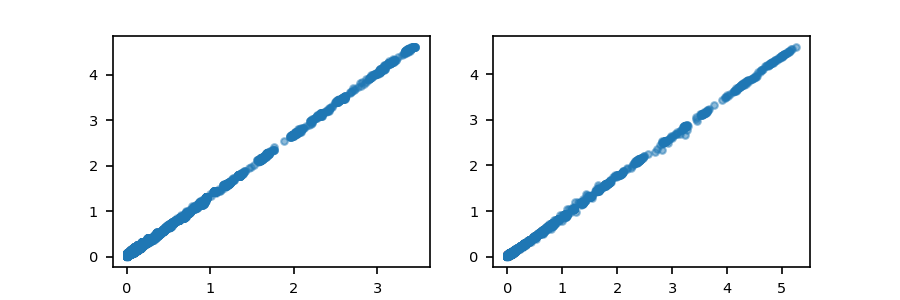

In [702]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2))

for i, key in enumerate(ecr_results.keys()):
    ax = axes[i]
    res = ecr_results[key]
    y = res['struct']['gamma'].copy()
    y /= res['stan']['R_scale']
    
    ax.scatter(y, res['stan']['var']['y_hat'], s=10, alpha=0.5)
    

<IPython.core.display.Javascript object>


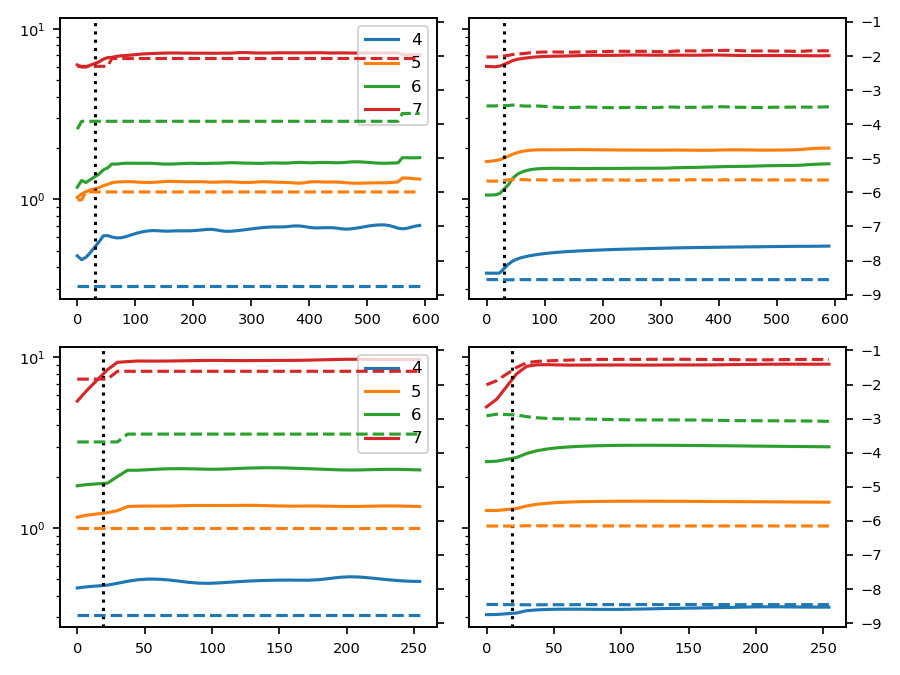

In [763]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4.5), sharey=True)

twin_axes = []
for i, key in enumerate(ecr_results.keys()):
    res = ecr_results[key]
    t_grid = res['struct']['time_grid']

    axt0 = axes[i, 0].twinx()
    axt1 = axes[i, 1].twinx()
    twin_axes += [axt0, axt1]

#     axt0.get_shared_y_axes().join(axt0, axt1)

    for k in range(res['stan']['R_stack'].shape[0]):

        y_k = ecr_results[key]['struct']['path_sizes'][k]
        p = axes[i, 0].plot(t_grid, y_k, label=k + 4)
        axt0.plot(t_grid, np.log(ecr_results[key]['struct']['path_tau'][k]), ls='--')

        axes[i, 1].plot(t_grid, res['stan']['R_stack'][k])
        axt1.plot(t_grid, res['stan']['lt_stack'][k], ls='--')

    for ax in axes[i]:
        ax.axvline(ecr_results[key]['step_time'], c='k', ls=':')
        ax.set_yscale('log')

    axes[i, 0].legend()
    axt0.set_yticklabels([])

twin_axes[0].get_shared_y_axes().join(*twin_axes)

fig.tight_layout()

<IPython.core.display.Javascript object>


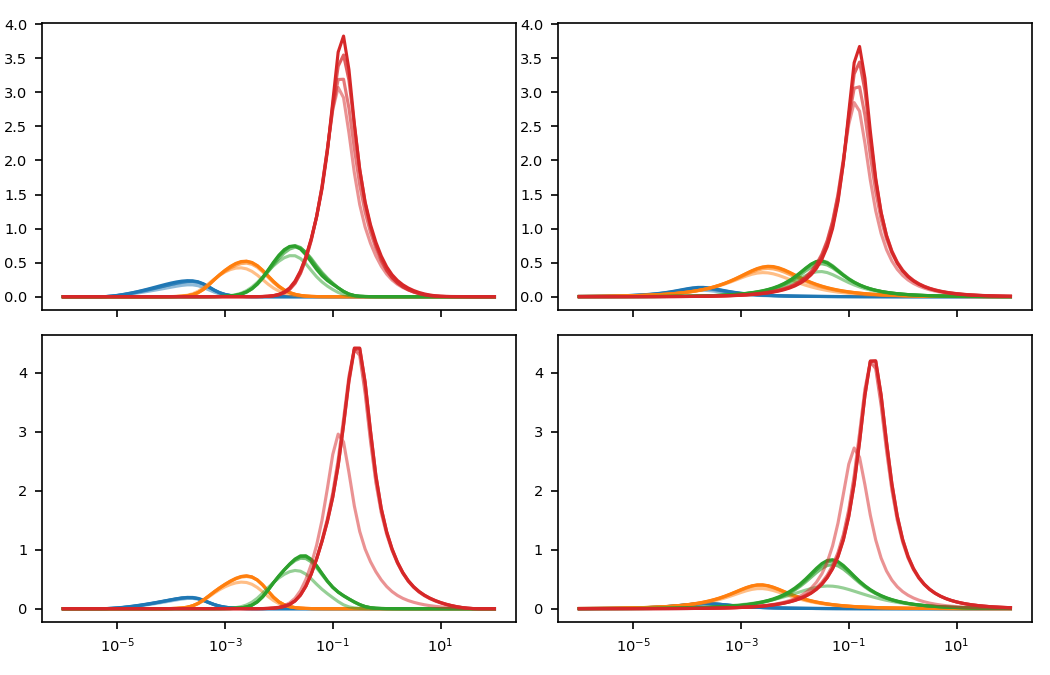

In [4906]:
fig, axes = plt.subplots(2, 2, figsize=(7, 4.5), sharex=True)


for i, key in enumerate(['h2', 'o2']):
    axes[i, 0].get_shared_y_axes().join(*axes[i])
    ecr_path_dist = ecr_results[key]['struct']['path_dist']
    rq_dist = ecr_results[key]['stan']['rq_dist']

    for k in range(4):
        c = default_colors[k]
        for j in [0, 5, 10, 20]:
            axes[i, 0].plot(tau_eval, ecr_path_dist[k, j], c=c, alpha=0.5 + 0.5 * (j / 20))
            axes[i, 1].plot(tau_eval, rq_dist[k, j], c=c, alpha=0.5 + 0.5 * (j / 20))

for ax in axes.ravel():
    ax.set_xscale('log')
    
fig.tight_layout()

<IPython.core.display.Javascript object>


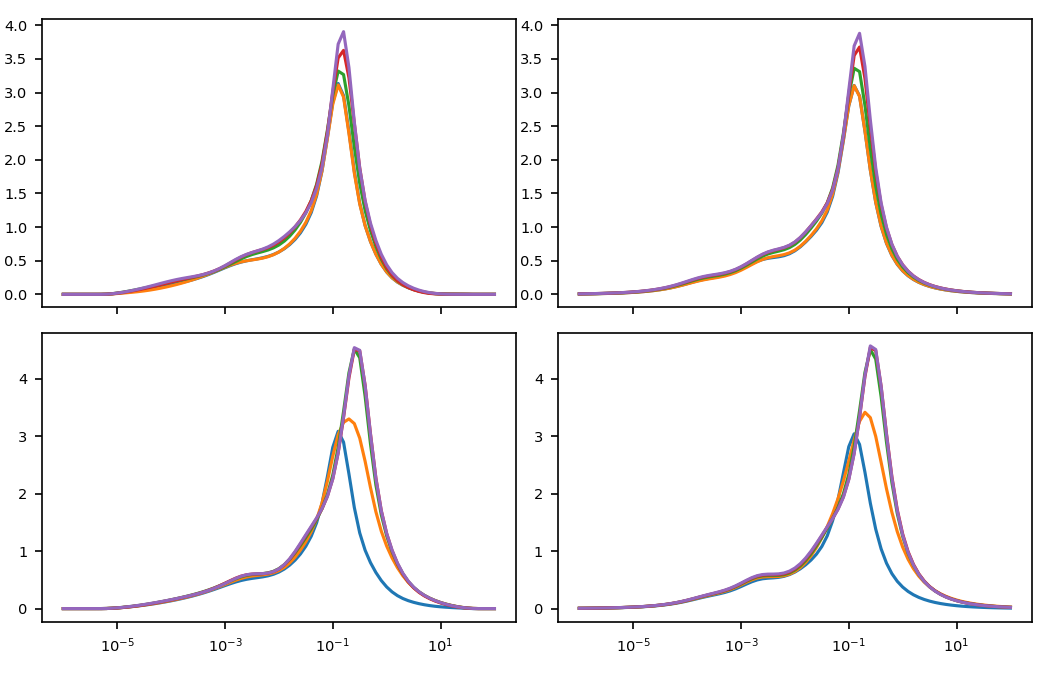

In [2663]:
fig, axes = plt.subplots(2, 2, figsize=(7, 4.5), sharex=True)


for i, key in enumerate(['h2', 'o2']):
    axes[i, 0].get_shared_y_axes().join(*axes[i])
    ecr_path_dist = ecr_results[key]['struct']['path_dist']
    rq_dist = ecr_results[key]['stan']['rq_dist']

    
    for j in [0, 2, 5, 10, 20]:
        axes[i, 0].plot(tau_eval, np.sum(ecr_path_dist[:, j], axis=0))
        axes[i, 1].plot(tau_eval, np.sum(rq_dist[:, j], axis=0))

for ax in axes.ravel():
    ax.set_xscale('log')
    
fig.tight_layout()

In [4814]:
np.mean(ecr_results['o2']['stan']['lt_stack'], axis=1), \
np.nanmean(lt_stack[..., 22], axis=tuple(range(1, np.ndim(lt_stack) - 1)))

(array([-8.34025971, -6.08146   , -3.16648147, -1.33087618]),
 array([-15.86258 , -13.09435 , -10.86346 ,  -9.059267,  -6.109635,
         -3.434335,  -2.176978]))

In [4816]:
ecr_results['o2']['struct'].keys()

dict_keys(['time_grid', 'x_raw', 'x_filt', 'gamma', 'x_norm', 'f', 'fx', 'fxx', 'peak_prob_only', 'trough_prob_only', 'rp_raw', 'tp_raw', 'rp_filt', 'tp_filt', 'rp_mix', 'tp_mix', 'R_inf', 'R_inf_filt', 'paths', 'path_mask', 'path_dist', 'path_sizes', 'path_tau'])

C:\Users\jdh10\AppData\Local\Temp\ipykernel_17284\547058190.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.6), sharey=False)


<IPython.core.display.Javascript object>


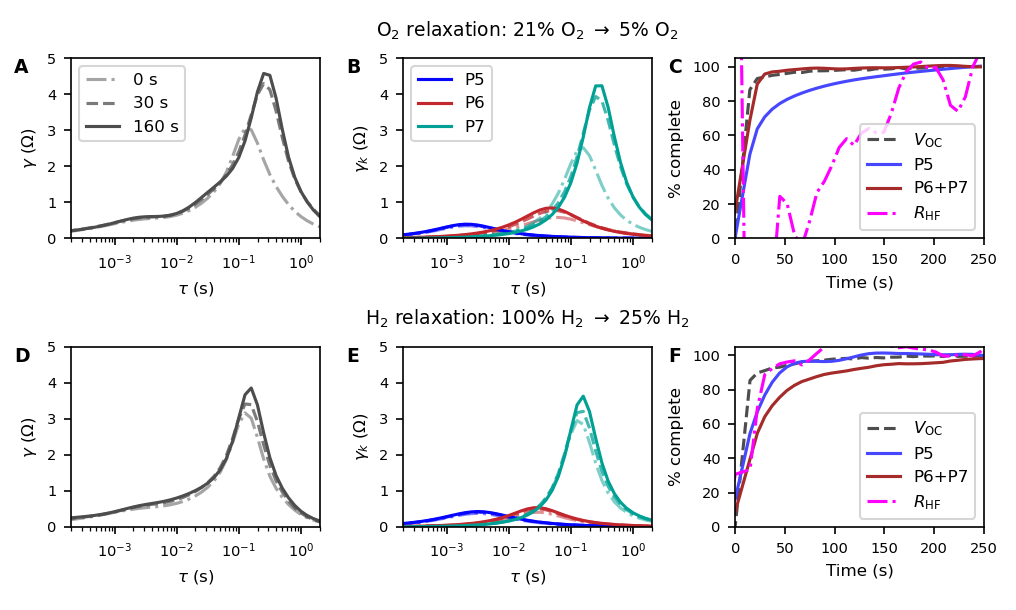

In [227]:
fig, axes = plt.subplots(2, 3, figsize=(full_width, full_width * 0.6), sharey=False)

def get_eq_frac(y, t, t_step, y1=None):
    y0 = np.median(y[t < t_step])
    if y1 is None:
        y1 = np.median(y[-10:])
    return (y - y0) / (y1 - y0)


axes[0, 0].get_shared_y_axes().join(*axes[:, :2].ravel())

tau_plot = mrt_ecr.tau_supergrid
for i, key in enumerate(['o2', 'h2']):
    res = ecr_results[key]
    
    x_filt = res['struct']['x_filt']
    R_p = np.sum(x_filt, axis=-1) * mrt_ecr.tau_basis_area
    
    gamma = res['struct']['gamma']
    t_grid = res['struct']['time_grid']
    rq_dist = res['stan']['rq_dist']
    R_k = res['stan']['R_stack']
#     R_k = res['struct']['path_sizes']
    R_inf = res['struct']['R_inf']
    R_tot = R_p + R_inf
    R_HF = R_tot - np.sum(R_k[1:], axis=0)
    R_inf_filt = ndimage.gaussian_filter1d(R_inf, sigma=2)
    start_index = res['step_file_index'] - 1    
    #     t_step = res['step_time']
    t_step = t_grid[start_index]
    t_plot = t_grid - t_step
    # DRT vs. time
    j_arr = np.array([0, 3, 20])
#     j_arr = np.arange(0, 10, 2)
    for n, (j, ls) in enumerate(zip(j_arr, ['-.', '--', '-'])):
        alpha = 0.5 + 0.5 * n / (len(j_arr) - 1)
        axes[i, 0].plot(tau_plot, gamma[start_index + j], c=(0.3, 0.3, 0.3), alpha=alpha, ls=ls,
                       label='{:.0f} s'.format(round(t_plot[start_index + j], -1)))
#         print(j, t_plot[start_index + j])
        for k in range(rq_dist.shape[0] - 1):
            if n == len(j_arr) - 1:
                label = f'P{k + 1 + 4}'
            else:
                label=''
            axes[i, 1].plot(tau_plot, rq_dist[k + 1, start_index + j], c=base_colors[k], 
                            alpha=alpha, ls=ls, label=label)
            
    v_oc = res['drt_seq'].predict_response(t_grid, subtract_background=False)
    quants = {
            '$V_{\mathrm{OC}}$': (v_oc, {'ls': '--', 'c': (0.3, 0.3, 0.3)}),
            'P5': (R_k[1], {'c': light_colors[0]})
    }
#     if key == 'o2':
#         quants.update({
#             'P6': (R_k[2], {'c': light_colors[1]}),
#             'P7': (R_k[3], {'c': light_colors[2]}),
#         })
#     else:
    quants['P6+P7'] = (np.sum(R_k[2:], axis=0), {'c': 'brown'})
        
    quants['$R_{\mathrm{HF}}$'] = (R_HF, {'c': 'magenta', 'ls': '-.'})
#     if key == 'o2':
#         R_hf = R_inf_filt + np.sum(R_k[:2], axis=0)
# #         quants = {'$R_{\mathrm{HF}}$': R_hf, 'P6': R_k[2], 'P7': R_k[3]}
#         quants = quants | {'P6': R_k[2], 'P7': R_k[3]}
#     else:
#     R_hf = R_inf_filt + np.sum(R_k[:2], axis=0)
#         quants = {'$R_{\mathrm{HF}}$': R_hf, 'P6+P7': np.sum(R_k[2:], axis=0)}
#     quants = quants | {'P6+P7': (np.sum(R_k[2:], axis=0), )}
#         quants = {'$R_{\mathrm{HF}}$': R_hf, 'P6': R_k[2], 'P7': R_k[3]}

    for label, quant in quants.items():
#         if key == 'h2':
        y_end = np.median(quant[0][t_plot >= 225])
#         else:
#             y_end = None
        f_eq = get_eq_frac(quant[0], t_grid, t_step, y1=y_end)
        axes[i, 2].plot(t_plot, 100 * f_eq, label=label, **quant[1])
#         axes[i, 2].plot(t_plot, quant[0], label=label, **quant[1])
#         axes[i, 2].plot(t_plot, quant, label=label)
        
    axes[i, 2].set_xlim(0, t_plot[-1])
            
        
axes[0, 0].legend()
axes[0, 1].legend()
# axes[0, 2].legend()

    

for ax in axes[:, :2].ravel():
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau$ (s)')
    ax.set_xlim(2e-4, 2e0)
    ax.set_ylim(0, 5)
    
for ax in axes[:, 0]:
    ax.set_ylabel(r'$\gamma$ ($\Omega$)')
    
for ax in axes[:, 1]:
    ax.set_ylabel(r'$\gamma_k$ ($\Omega$)')
    
for ax in axes[:, 2]:
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 105)
    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('% complete')
    
axes[0, 1].set_title(r'O$_2$ relaxation: 21% O$_2$ $\rightarrow$ 5% O$_2$', y=1.05, fontsize=9)
axes[1, 1].set_title(r'H$_2$ relaxation: 100% H$_2$ $\rightarrow$ 25% H$_2$', y=1.05, fontsize=9)

    
fig.tight_layout()
fig.subplots_adjust(hspace=0.6)

ff.add_letters(axes[0, :2], loc=(-0.23, 1))
ff.add_letters(axes[0, 2:], start_index=2, loc=(-0.27, 1))
ff.add_letters(axes[1, :2], start_index=3, loc=(-0.23, 1))
ff.add_letters(axes[1, 2:], start_index=5, loc=(-0.27, 1))

# ff.savefig(fig, 'PCEC_relaxation')

<IPython.core.display.Javascript object>


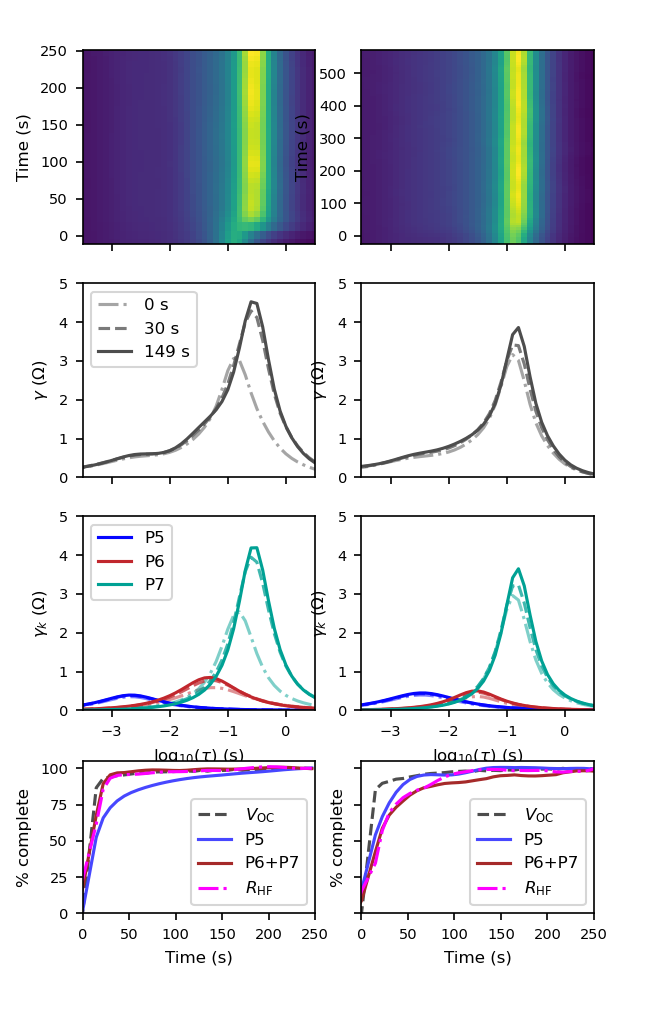

C:\Users\jdh10\AppData\Local\Temp\ipykernel_13216\3080468184.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


In [729]:
# fig, axes = plt.subplots(4, 2, figsize=(half_width, full_width * 0.8), sharey=False)
fig = plt.figure(figsize=(half_width, full_width))
gs_top = fig.add_gridspec(3, 2, top=0.95, bottom=0.3)
gs_bot = fig.add_gridspec(1, 2, top=0.25, bottom=0.1)

axes = []
# for i in range(3):
#     axes.append([fig.add_subplot(gs_top[i, j]) for j in range(2)])
top_axes = gs_top.subplots(sharex=True)
        
# axes.append([fig.add_subplot(gs_bot[j]) for j in range(2)])
bot_axes = gs_bot.subplots(sharex=True, sharey=True)
# axes = np.array(axes)
axes = np.vstack([top_axes, bot_axes])

def get_eq_frac(y, t, t_step, y1=None):
    y0 = np.median(y[t < t_step])
    if y1 is None:
        y1 = np.median(y[-10:])
    return (y - y0) / (y1 - y0)


axes[1, 0].get_shared_y_axes().join(*axes[1:3].ravel())
drt2d_axes = axes[0]
drt1d_axes = axes[1]
rq_axes = axes[2]
time_axes = axes[3]

tau_plot = mrt_ecr.tau_supergrid
for i, key in enumerate(['o2', 'h2']):
    res = ecr_results[key]
    
    x_filt = res['struct']['x_filt']
    R_p = np.sum(x_filt, axis=-1)
    
    gamma = res['struct']['gamma']
    t_grid = res['struct']['time_grid']
    rq_dist = res['stan']['rq_dist']
    R_k = res['stan']['R_stack']
#     R_k = res['struct']['path_sizes']
    R_inf = res['struct']['R_inf']
    R_tot = R_p + R_inf
    R_HF = R_tot - np.sum(R_k[1:], axis=0)
    R_inf_filt = ndimage.gaussian_filter1d(R_inf, sigma=2)
    start_index = res['step_file_index'] - 1    
    #     t_step = res['step_time']
    t_step = t_grid[start_index]
    t_plot = t_grid - t_step
    
    # 2d DRT vs. time
    lt_2d, t_2d = np.meshgrid(np.log10(tau_plot), t_plot)
    drt2d_axes[i].pcolormesh(lt_2d, t_2d, gamma, cmap='viridis')
    
    # 1d DRT vs. time
    j_arr = np.array([0, 3, 19])
#     j_arr = np.arange(0, 10, 2)
    for n, (j, ls) in enumerate(zip(j_arr, ['-.', '--', '-'])):
        alpha = 0.5 + 0.5 * n / (len(j_arr) - 1)
        drt1d_axes[i].plot(np.log10(tau_plot), gamma[start_index + j], c=(0.3, 0.3, 0.3), alpha=alpha, ls=ls,
                       label='{:.0f} s'.format(t_plot[start_index + j]))
#         print(j, t_plot[start_index + j])
        for k in range(rq_dist.shape[0] - 1):
            if n == len(j_arr) - 1:
                label = f'P{k + 1 + 4}'
            else:
                label=''
            rq_axes[i].plot(np.log10(tau_plot), rq_dist[k + 1, start_index + j], c=base_colors[k], 
                            alpha=alpha, ls=ls, label=label)
            
    v_oc = res['drt_seq'].predict_response(t_grid, subtract_background=False)
    quants = {
            '$V_{\mathrm{OC}}$': (v_oc, {'ls': '--', 'c': (0.3, 0.3, 0.3)}),
            'P5': (R_k[1], {'c': light_colors[0]})
    }
#     if key == 'o2':
#         quants.update({
#             'P6': (R_k[2], {'c': light_colors[1]}),
#             'P7': (R_k[3], {'c': light_colors[2]}),
#         })
#     else:
    quants['P6+P7'] = (np.sum(R_k[2:], axis=0), {'c': 'brown'})
        
    quants['$R_{\mathrm{HF}}$'] = (R_HF, {'c': 'magenta', 'ls': '-.'})
#     if key == 'o2':
#         R_hf = R_inf_filt + np.sum(R_k[:2], axis=0)
# #         quants = {'$R_{\mathrm{HF}}$': R_hf, 'P6': R_k[2], 'P7': R_k[3]}
#         quants = quants | {'P6': R_k[2], 'P7': R_k[3]}
#     else:
#     R_hf = R_inf_filt + np.sum(R_k[:2], axis=0)
#         quants = {'$R_{\mathrm{HF}}$': R_hf, 'P6+P7': np.sum(R_k[2:], axis=0)}
#     quants = quants | {'P6+P7': (np.sum(R_k[2:], axis=0), )}
#         quants = {'$R_{\mathrm{HF}}$': R_hf, 'P6': R_k[2], 'P7': R_k[3]}

    for label, quant in quants.items():
#         if key == 'h2':
        y_end = np.median(quant[0][t_plot >= 225])
#         else:
#             y_end = None
        f_eq = get_eq_frac(quant[0], t_grid, t_step, y1=y_end)
        time_axes[i].plot(t_plot, 100 * f_eq, label=label, **quant[1])
#         axes[i, 2].plot(t_plot, quant[0], label=label, **quant[1])
#         axes[i, 2].plot(t_plot, quant, label=label)
        
    time_axes[i].set_xlim(0, t_plot[-1])
            
        
drt1d_axes[0].legend()
rq_axes[0].legend()
# axes[0, 2].legend()

    
drt2d_axes[0].set_xlim(-3.5, 0.5)
# for ax in top_axes.ravel():
# #     ax.set_xlabel(r'$\log_{10}(\tau)$ (s)')
#     ax.set_xlim(-3.5, 0.5)
    
for ax in list(drt1d_axes) + list(rq_axes):
    ax.set_ylim(0, 5)
    
for ax in drt2d_axes:
    ax.set_ylabel('Time (s)')
    
for ax in drt1d_axes:
    ax.set_ylabel(r'$\gamma$ ($\Omega$)')
    
for ax in rq_axes:
    ax.set_xlabel(r'$\log_{10}(\tau)$ (s)')
    ax.set_ylabel(r'$\gamma_k$ ($\Omega$)')
    
for ax in time_axes:
    ax.set_xlim(0, 250)
    ax.set_ylim(0, 105)
    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('% complete')
    
# axes[0, 1].set_title(r'O$_2$ relaxation: 21% O$_2$ $\rightarrow$ 5% O$_2$', y=1.05, fontsize=9)
# axes[1, 1].set_title(r'H$_2$ relaxation: 100% H$_2$ $\rightarrow$ 25% H$_2$', y=1.05, fontsize=9)

    
fig.tight_layout()
# fig.subplots_adjust(hspace=0.6)

# ff.add_letters(axes[0, :2], loc=(-0.23, 1))
# ff.add_letters(axes[0, 2:], start_index=2, loc=(-0.27, 1))
# ff.add_letters(axes[1, :2], start_index=3, loc=(-0.23, 1))
# ff.add_letters(axes[1, 2:], start_index=5, loc=(-0.27, 1))

# ff.savefig(fig, 'PCEC_relaxation')

In [632]:
ecr_results['h2'].keys()

dict_keys(['step_time', 'step_file_index', 'chrono_seq_df', 'drt_seq', 'chrono_reader', 'struct', 'stan'])

<IPython.core.display.Javascript object>


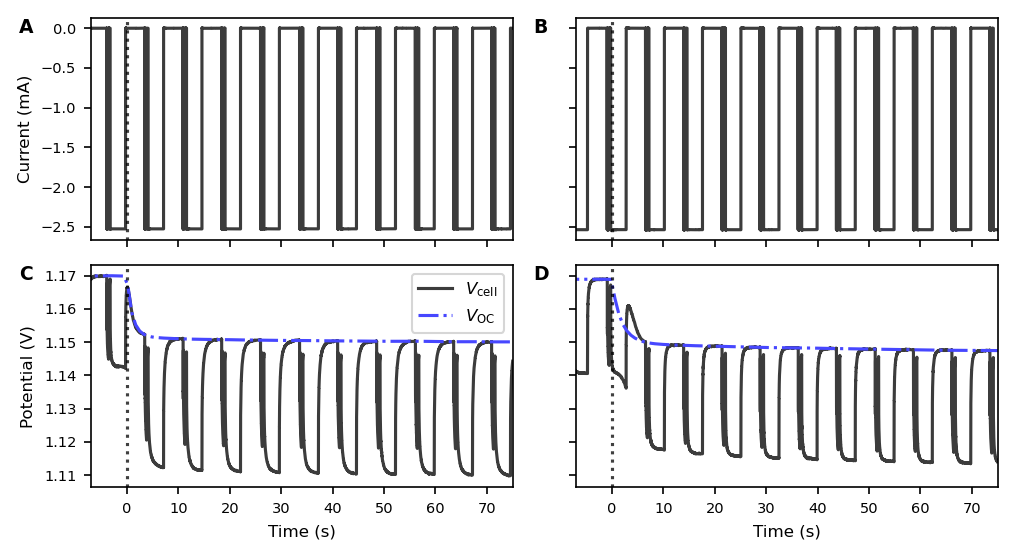

In [718]:
# Show voltage vs. time

fig, axes = plt.subplots(2, 2, figsize=(full_width, full_width * 0.55), sharex=True, sharey=False)

axes[0, 0].get_shared_y_axes().join(*axes[0])
axes[1, 0].get_shared_y_axes().join(*axes[1])

for i, group in enumerate(['o2', 'h2']):
    i_ax = axes[0, i]
    v_ax = axes[1, i]
    res = ecr_results[group]
    
#     t_grid = res['struct']['time_grid']
    start_index = res['step_file_index'] - 1
#     t_step = t_grid[start_index + 1]
    t_step = res['step_time']
    
    
    index = mrt_ecr.get_group_index(group)
    start_file = mrt_ecr.obs_data[index[0]][0]
    init_df = fl.read_chrono(start_file)
    files = [mrt_ecr.obs_data[j][0] for j in index[start_index:start_index + 20]]
    df = fl.concatenate_chrono_data(files)
    dt = fl.get_time_offset(df, init_df)
    
    i_ax.plot(df['elapsed'] + dt - t_step, 1000 * df['Im'], c=data_kw['edgecolors'],
           alpha=0.85)
    
    v_ax.plot(df['elapsed'] + dt - t_step, df['Vf'], c=data_kw['edgecolors'], label='$V_{\mathrm{cell}}$',
           alpha=0.85)
    
    t_grid = np.linspace(-5, 150, 200)
    drt_seq = res['drt_seq']
    v_oc = drt_seq.predict_response(t_grid, subtract_background=False)
    v_ax.plot(t_grid - t_step, v_oc, marker='', c=light_colors[0], label='$V_{\mathrm{OC}}$', ls='-.')
#     ax.plot(drt_seq.t_fit - t_step, drt_seq.raw_response_signal, marker='.')
    
    v_ax.set_xlim(-7, 75)
    
    for ax in [i_ax, v_ax]:
        ax.axvline(0, c='k', ls=':', alpha=0.75)
    
    v_ax.set_xlabel('Time (s)')
    

axes[0, 0].set_ylabel('Current (mA)')

axes[1, 0].legend()
axes[1, 0].set_ylabel('Potential (V)')

for ax in axes[:, 1]:
    ax.set_yticklabels([])

fig.tight_layout()
fig.subplots_adjust(wspace=0.15)

ff.add_letters(axes, loc=[(-0.17, 1), (-0.1, 1)] * 2)
ff.savefig(fig, 'Supp_PCEC_VoltageRelaxation')

<IPython.core.display.Javascript object>


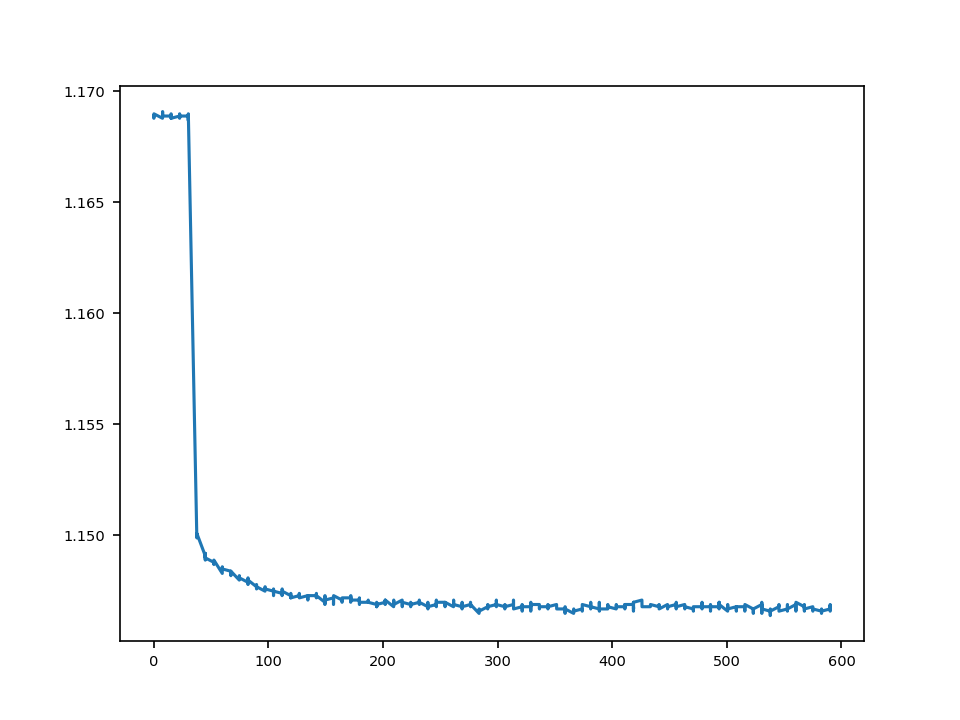

In [658]:
fig, ax = plt.subplots()

drt_seq = res['drt_seq']
ax.plot(drt_seq.t_fit, drt_seq.raw_response_signal)

<IPython.core.display.Javascript object>


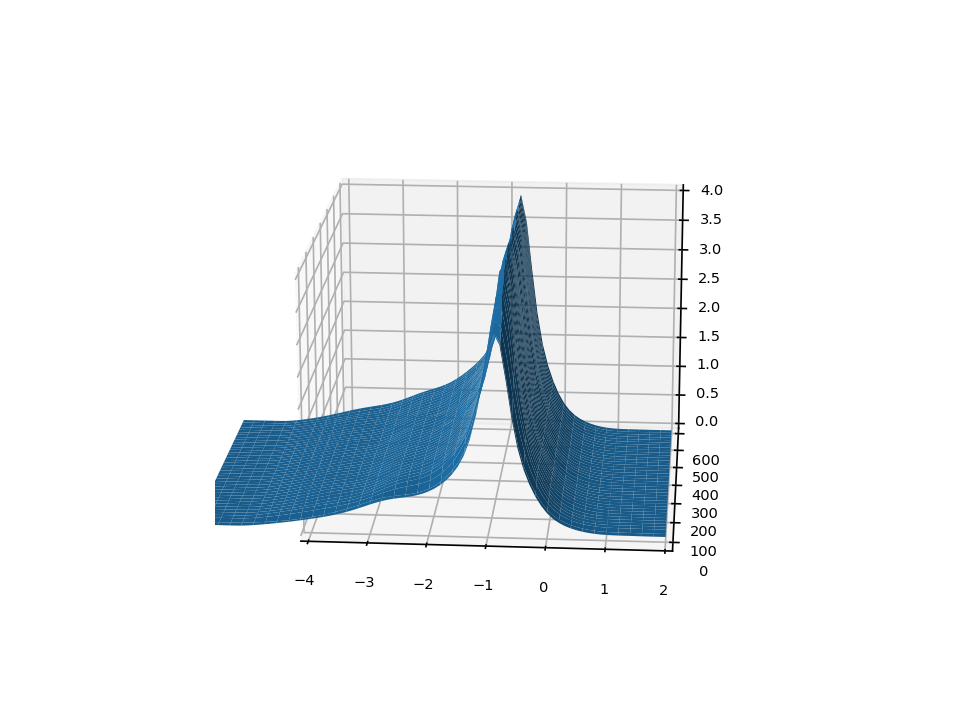

(-4.0, 2.0)

In [2707]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

key = 'h2'
res = ecr_results[key]
gamma = res['struct']['gamma']
lt = np.log10(tau_plot)
t_grid = res['struct']['time_grid']

xx, yy = np.meshgrid(lt, t_grid)
ax.plot_surface(xx, yy, gamma)

# start_index = res['step_file_index'] - 1
# for j in np.arange(0, 20, 3):
#     ax.plot(lt, np.ones_like(lt) * t_grid[start_index + j], gamma[start_index + j])

ax.set_xlim(-4, 2)



<IPython.core.display.Javascript object>


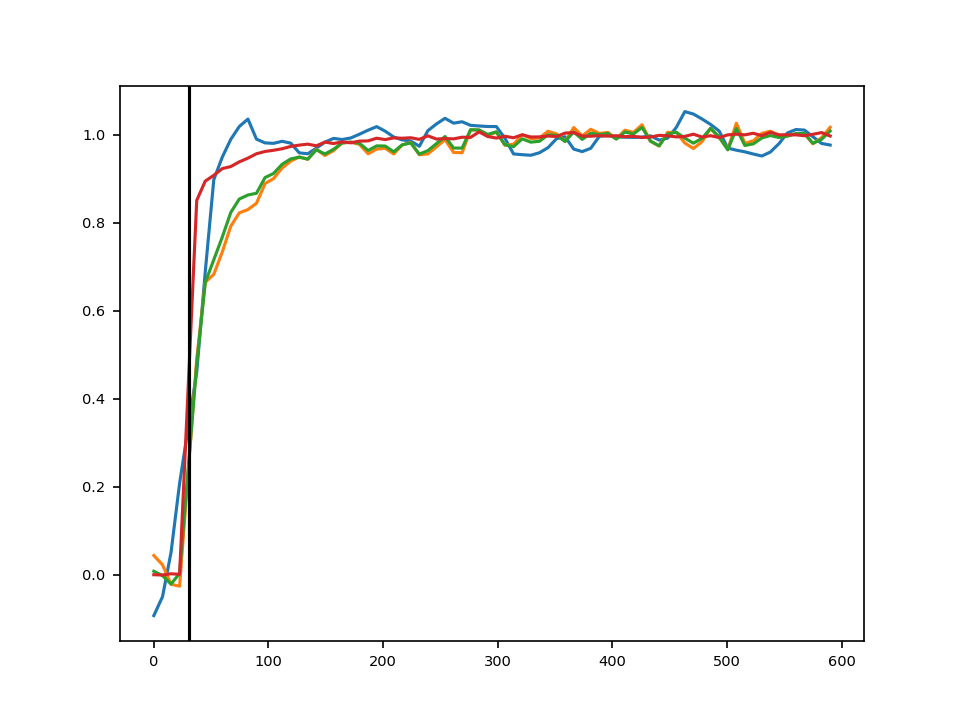

In [2206]:
fig, ax = plt.subplots()

Rp = np.sum(x, axis=-1) * mrt_h2.tau_basis_area
Rp = np.delete(Rp, 4)
R_inf = mrt_h2.obs_special_resolved['R_inf'].copy()
R_inf = np.delete(R_inf, 4)
times = np.delete(mrt_h2.obs_psi[:, 0], 4)
v_pred = drt_seq.predict_response(times, subtract_background=False)

quants = [R_inf, Rp, R_inf + Rp, -v_pred]
t_step = 31
for quant in quants:
    y0 = np.median(quant[times < 31])
    y1 = np.median(quant[times > 550])
    ax.plot(times, (quant - y0) / (y1 - y0))

# ax.plot(times, Rp)
# ax.plot(times, R_inf)
# ax2 = ax.twinx()
# ax2.plot(times, -v_pred, c='r')
ax.axvline(t_step, c='k')

In [2037]:
drt = mrt.get_fit(0)
drt.fit_dop = False
drt2 = drt.copy()
cp_tup = fl.get_chrono_tuple(df1)
drt.fit_chrono(*cp_tup, **mrt.fit_kw | {'subtract_background': True, 'nonneg': True})
drt2.fit_chrono(*cp_tup, **mrt.fit_kw | {'subtract_background': False, 'nonneg': True})

linear downsample size: 136


<IPython.core.display.Javascript object>


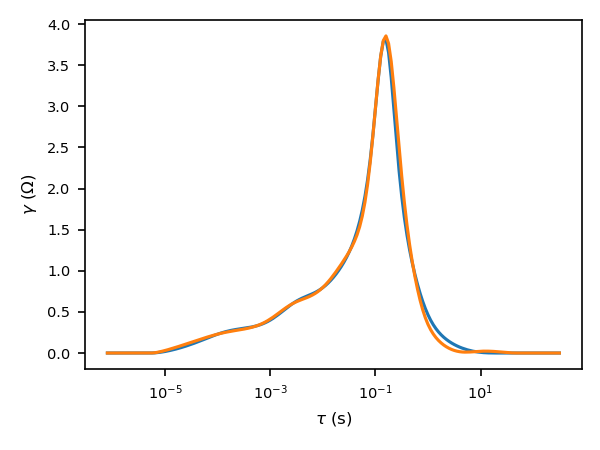

<AxesSubplot:xlabel='$\\tau$ (s)', ylabel='$\\gamma$ ($\\Omega$)'>

In [2038]:
ax = drt.plot_distribution()
drt2.plot_distribution(ax=ax)

<IPython.core.display.Javascript object>


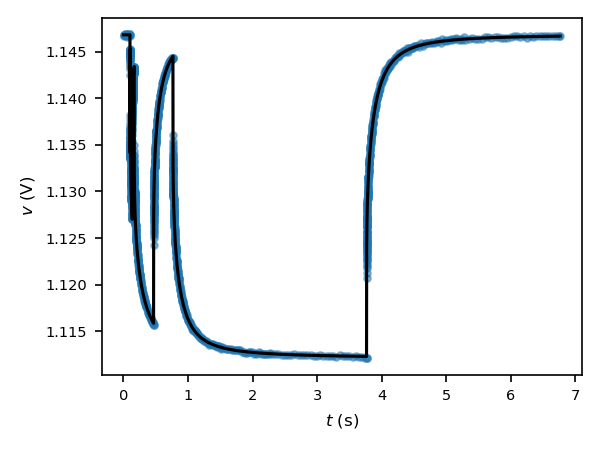

<AxesSubplot:xlabel='$t$ (s)', ylabel='$v$ (V)'>

In [2045]:
drt.plot_chrono_fit(transform_time=False)

<IPython.core.display.Javascript object>


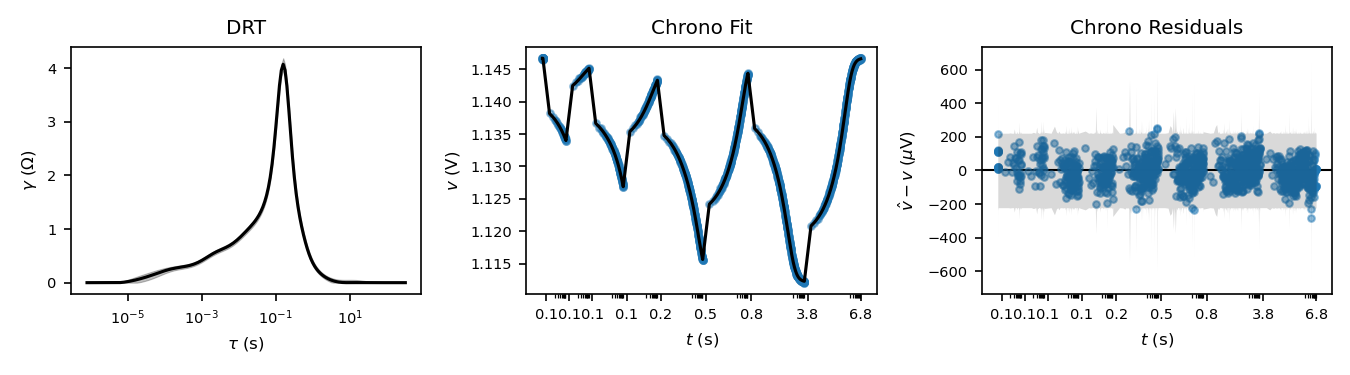

array([<AxesSubplot:title={'center':'DRT'}, xlabel='$\\tau$ (s)', ylabel='$\\gamma$ ($\\Omega$)'>,
       <AxesSubplot:title={'center':'Chrono Fit'}, xlabel='$t$ (s)', ylabel='$v$ (V)'>,
       <AxesSubplot:title={'center':'Chrono Residuals'}, xlabel='$t$ (s)', ylabel='$\\hat{v} - v$ ($\\mu$V)'>],
      dtype=object)

In [2032]:
drt.plot_results()

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


<IPython.core.display.Javascript object>


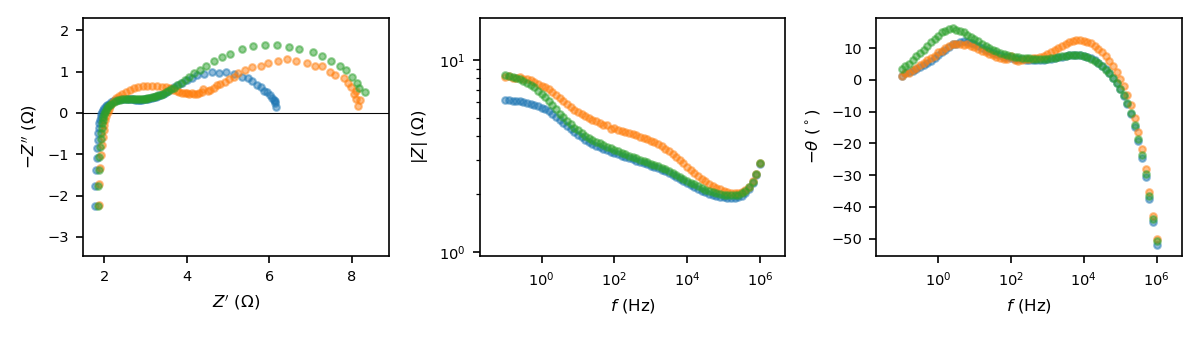

In [2016]:
cell_dir = Path('G:\\My Drive\\Jake\\Gamry data\\CFCC_4-2\\Pub\\Coarse-Fine\\220312_220309-3b')
ecr_dir = cell_dir.joinpath('run6_ecr-450')


static_files = {
    'std': ecr_dir.joinpath('EISPOT_100%H2_21%O2.DTA'),
    'low_h2': ecr_dir.joinpath('EISPOT_25%H2_21%O2.DTA'),
    'low_o2': ecr_dir.joinpath('EISPOT_100%H2_5%O2.DTA')
}


drt = DRT()
static_fits = {}

fig, axes = plt.subplots(1, 3, figsize=(8, 2.25))

for key, file in static_files.items():
    eis_tup = fl.read_eis(file, return_tuple=True)
    hplt.plot_eis(eis_tup, axes=axes)
    drt.fit_eis(*eis_tup, iw_l2_lambda_0=1e-6)
    static_fits[key] = deepcopy(drt)

<IPython.core.display.Javascript object>


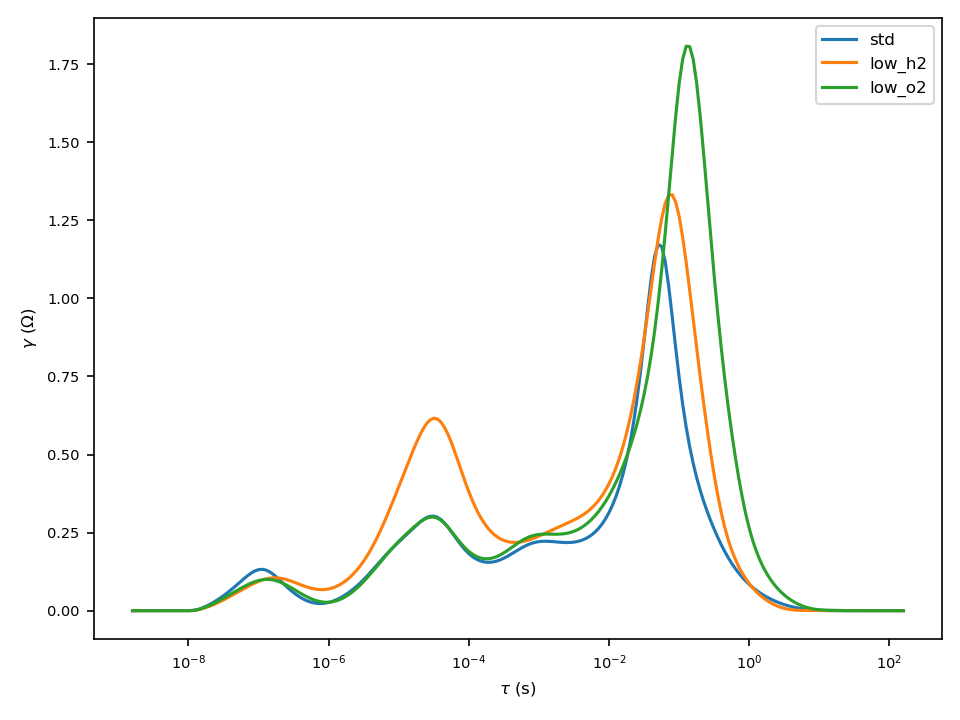

In [17]:
fig, ax = plt.subplots()
for key, fit in static_fits.items():
    fit.plot_distribution(ax=ax, label=key)
    
ax.legend()

# Examine P1-DOP interaction

In [4163]:
np.max(drt.predict_dop(normalize=True, include_ideal=True, normalize_tau=(1e-7, 1e0),
               normalize_quantiles=(0, 1), nu=np.linspace(-1, 1, 101), delta_density=True)), \
np.max(drt2.predict_dop(normalize=True, include_ideal=True, normalize_tau=(1e-7, 1e0),
               normalize_quantiles=(0, 1), nu=np.linspace(-1, 1, 101), delta_density=True))

(83.64541806817901, 91.51205593910726)

In [4210]:
drt2.fit_eis(*zt, **mrt.fit_kw)
drt2.f_fit

C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:206: UserWarning: For best results, set solve_rp=True when performing DRT-DOP fits or DRT fits without a non-negativity constraint
  warnings.warn('For best results, set solve_rp=True when performing DRT-DOP fits '
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:979: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


array([1.000195e+06, 7.944141e+05, 6.310547e+05, 5.012109e+05,
       3.983203e+05, 3.162891e+05, 2.513672e+05, 1.995703e+05,
       1.585547e+05, 1.259766e+05, 1.001953e+05, 7.957031e+04,
       6.316406e+04, 5.027344e+04, 3.996094e+04, 3.175781e+04,
       2.519531e+04, 2.003906e+04, 1.566311e+04, 1.246189e+04,
       9.946646e+03, 7.888720e+03, 6.288110e+03, 5.039062e+03,
       4.001524e+03, 3.164062e+03, 2.507267e+03, 1.979167e+03,
       1.598011e+03, 1.257622e+03, 1.004464e+03, 8.003049e+02,
       6.310096e+02, 4.986702e+02, 3.972458e+02, 3.196023e+02,
       2.511161e+02, 2.008929e+02, 1.580056e+02, 1.255580e+02,
       9.973404e+01, 7.944915e+01, 6.334459e+01, 4.986702e+01,
       3.972458e+01, 3.188775e+01, 2.493351e+01, 1.994681e+01,
       1.594388e+01, 1.270325e+01, 9.910148e+00, 7.971939e+00,
       6.351626e+00, 4.970838e+00, 3.942389e+00, 3.167230e+00,
       2.485419e+00, 1.971194e+00, 1.566154e+00, 1.260081e+00,
       1.001603e+00, 7.971939e-01, 6.334459e-01, 5.0295

In [4227]:
ax = drt.plot_eis_fit(zt[0], plot_data=False)
drt2.plot_eis_fit(axes=ax, c='r', ls='--')
# mrt.fit_kw

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='$Z^\\prime$ ($\\Omega$)', ylabel='$-Z^{\\prime\\prime}$ ($\\Omega$)'>

In [4226]:
for obs_id in [225, 226]:
    _, zt = mrt.get_obs_data(obs_id)
    drt = mrt.get_fit(obs_id)
    fig, axes = plt.subplots(1, 3, figsize=(8, 2.5))
    drt.plot_distribution(ax=axes[0], scale_prefix='')
    drt.plot_dop(ax=axes[1], normalize=True, normalize_tau=1 / omega, normalize_quantiles=(0, 1))
#     drt.fit_parameters['x'] = np.zeros_like(drt.fit_parameters['x'])
    drt.plot_eis_fit(frequencies=zt[0], axes=axes[2], plot_data=False)
    
    drt2 = drt.copy()
    drt2.fit_inductance = True
    drt2.fit_dop = True
    
    drt2.fit_eis(*zt, **mrt.fit_kw | {'remove_extremes': False, 'remove_outliers': False, 'outlier_p': None})
    drt2.plot_distribution(ax=axes[0], scale_prefix='')
    drt2.plot_dop(ax=axes[1], normalize=True, ls='--', normalize_tau=1 / omega, normalize_quantiles=(0, 1))
    print(drt2.fit_parameters['inductance'])
#     drt2.fit_parameters['x'] = np.zeros_like(drt2.fit_parameters['x'])
    drt2.plot_eis_fit(frequencies=zt[0], axes=axes[2], plot_data=False, c='r', ls='--')
#     axes[1].set_ylim(0, 1)

<IPython.core.display.Javascript object>

C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:206: UserWarning: For best results, set solve_rp=True when performing DRT-DOP fits or DRT fits without a non-negativity constraint
  warnings.warn('For best results, set solve_rp=True when performing DRT-DOP fits '
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:979: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


2.8168398851850827e-08


<IPython.core.display.Javascript object>

C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:206: UserWarning: For best results, set solve_rp=True when performing DRT-DOP fits or DRT fits without a non-negativity constraint
  warnings.warn('For best results, set solve_rp=True when performing DRT-DOP fits '
C:\Users\jdh10\OneDrive - Colorado School of Mines\python\projects\hybrid-drt\hybdrt\models\drt1d.py:979: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


2.0459784739230507e-13


In [4219]:
obs_ids = [i for i, d in enumerate(mrt.obs_data) if d[0] is None]
obs_ids

[36,
 37,
 75,
 76,
 112,
 113,
 149,
 150,
 187,
 188,
 225,
 226,
 265,
 266,
 304,
 305,
 343,
 344,
 381,
 382]

In [10]:
for group in np.unique(mrt.obs_group_id):
    index = mrt.get_group_index(group)
    print(group, mrt.obs_psi_df.loc[index[0]])
    x_raw = mrt.obs_x[index]
    eta_vals = mrt.obs_psi[index, mrt.psi_dim_names.index('eta')]
    sort_index = np.argsort(eta_vals)
    eta_vals = eta_vals[sort_index]
    x_raw = x_raw[sort_index]
    index = index[sort_index]
    x_filt = ndimage.median_filter(x_raw, size=(5, 3))

    bad_flag = mapping.nddata.flag_bad_obs(x_raw, x_filt, std_size=(5, 3), thresh=2, 
                                       test_factor_correction=False, test_offset_correction=False,
                                       return_rss=False, robust_std=True)
    
    bad_obs_flag = np.max(bad_flag, axis=1)
#     mrt.obs_ignore_flag[index] = bad_obs_flag
    print(np.where(bad_obs_flag), eta_vals[bad_obs_flag])

    print(f'{group} num bad:', np.sum(np.max(bad_flag, axis=1)))

23d T        450.000000
ph2        1.000000
po2        0.210000
ph2o       0.100000
j         -0.004754
V          1.088135
eta       -0.006747
time    8076.459043
Name: 0, dtype: float64
(array([], dtype=int64),) []
23d num bad: 0
24d T        450.000000
ph2        1.000000
po2        0.050000
ph2o       0.100000
j         -0.003694
V          1.064742
eta       -0.015132
time    8129.633044
Name: 38, dtype: float64
(array([3], dtype=int64),) [-0.51785925]
24d num bad: 1
25d T        450.000000
ph2        1.000000
po2        0.500000
ph2o       0.035000
j         -0.005373
V          1.122912
eta       -0.012881
time    8405.892699
Name: 77, dtype: float64
(array([], dtype=int64),) []
25d num bad: 0
26d T        450.000000
ph2        1.000000
po2        0.210000
ph2o       0.035000
j         -0.004590
V          1.109369
eta       -0.013967
time    8456.720638
Name: 114, dtype: float64
(array([17], dtype=int64),) [-0.09991]
26d num bad: 1
27d T        450.000000
ph2        1.000000
po